In [1]:
# === CNT Ωₙ One-Cell (Omnifield Constant Estimator) ============================
# What it expects (any subset is fine; it will auto-skip missing systems):
# For each system (kuramoto, ising, grayscott, tdgl, eeg), EITHER:
#   - a "scan" file (CSV or NPZ) with columns/arrays: K (control) and order (order parameter)
#   - a "timeseries" file (CSV or NPZ) with columns/arrays: t and x_*(state) or order_ts (scalar)
# If not provided, the cell will try to auto-discover via filename patterns; if still missing,
# the system is skipped (with a friendly message).
#
# Outputs:
#   - Pretty print of per-system {kappa_ratio, R_gain_ratio, tau_ratio, Omega_n with 95% CI}
#   - Invariance summary across systems (CV, band)
#   - Files saved: cnt_omnifield_results.json, cnt_omnifield_table.csv, cnt_omnifield_plot.png
#
# Notes:
#   - Nulls: scan-null via permutation of order vs K; ts-null via phase-randomized surrogates.
#   - κ-index: dimensionless steepness = max(d r/dK) * (ΔK / (Δr + ε)) so real>null => ratio>1.
#   - ℛ★: mean order in a window just above the detected knee K_c vs null (ratio).
#   - τ_echo: ACF half-life near K_c vs null (ratio).
#   - Ωₙ = (κ_ratio * R_ratio * tau_ratio) ** (1/3).
# ===============================================================================

import os, json, math, warnings
from pathlib import Path
from typing import Optional, Tuple, Dict, List
import numpy as np
import pandas as pd
from scipy import signal, fft
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ----------------------------- CONFIG -----------------------------------------
# You can set explicit file paths here (leave as None to auto-discover):
CONFIG = {
    "kuramoto": {
        "scan_path": None,       # e.g., r"C:\Users\caleb\cnt_mega_out\kuramoto_scan.csv"
        "timeseries_path": None, # e.g., r"C:\Users\caleb\cnt_mega_out\kuramoto_timeseries.csv"
        "dt": None               # override timestep if timeseries has no explicit 't' column
    },
    "ising":     {"scan_path": None, "timeseries_path": None, "dt": None},
    "grayscott": {"scan_path": None, "timeseries_path": None, "dt": None},
    "tdgl":      {"scan_path": None, "timeseries_path": None, "dt": None},
    "eeg":       {"scan_path": None, "timeseries_path": None, "dt": None},
}

# General knobs
B_NULL_SCAN   = 256   # permutation nulls for scan
B_NULL_TS     = 256   # phase-rand nulls for timeseries
BOOT_Omega    = 1000  # bootstrap draws for Omega CI
K_WINDOW_FRAC = 0.10  # window above Kc for R* (10% of K-range)
ACF_MAX_LAG   = 0.5   # fraction of series length to consider for ACF
AUTO_SEARCH_ROOTS = [Path.cwd()]  # add more roots if you like

# Auto-discovery filename patterns per system
PATTERNS = {
    "scan": [
        "*{name}*scan*.csv", "*{name}*order*.csv", "*{name}*scan*.npz", "*{name}*order*.npz"
    ],
    "ts": [
        "*{name}*ts*.csv", "*{name}*time*series*.csv", "*{name}*order_ts*.csv",
        "*{name}*ts*.npz", "*{name}*time*series*.npz", "*{name}*order_ts*.npz"
    ]
}

# --------------------------- I/O HELPERS --------------------------------------
def find_first(patterns: List[str]) -> Optional[Path]:
    for root in AUTO_SEARCH_ROOTS:
        for pat in patterns:
            hits = list(root.rglob(pat))
            if hits:
                return hits[0]
    return None

def load_scan(path: Path) -> Tuple[np.ndarray, np.ndarray]:
    if path.suffix.lower() == ".csv":
        df = pd.read_csv(path)
        # try common column names
        K = df[[c for c in df.columns if c.lower().startswith("k")][0]].to_numpy(dtype=float)
        order_cols = [c for c in df.columns if "order" in c.lower() or c.lower() in ("r","magnetization","m")]
        r = df[order_cols[0]].to_numpy(dtype=float) if order_cols else df.iloc[:,1].to_numpy(dtype=float)
        return K, r
    elif path.suffix.lower() == ".npz":
        data = np.load(path, allow_pickle=True)
        # try common keys
        for kK in ("K","k","control","param"):
            if kK in data:
                K = np.array(data[kK], dtype=float).ravel()
                break
        else:
            raise ValueError(f"No K found in {path}")
        for kr in ("order","r","magnetization","m"):
            if kr in data:
                r = np.array(data[kr], dtype=float).ravel()
                break
        else:
            # fallback: take second array
            keys = list(data.keys())
            r = np.array(data[keys[1]], dtype=float).ravel()
        return K, r
    else:
        raise ValueError(f"Unsupported scan file: {path}")

def load_timeseries(path: Path, dt_override: Optional[float]=None) -> Tuple[np.ndarray, np.ndarray]:
    if path.suffix.lower() == ".csv":
        df = pd.read_csv(path)
        # If there's 't', use it; else assume uniform dt
        if "t" in df.columns or "time" in [c.lower() for c in df.columns]:
            tcol = "t" if "t" in df.columns else [c for c in df.columns if c.lower()=="time"][0]
            t = df[tcol].to_numpy(dtype=float)
            X = df.drop(columns=[tcol]).to_numpy(dtype=float)
        else:
            X = df.to_numpy(dtype=float)
            if dt_override is None:
                dt_override = 1.0
            t = np.arange(len(df), dtype=float) * float(dt_override)
        # If multi-dim, take mean across channels for scalar order_ts proxy
        x = X.mean(axis=1) if X.ndim==2 else X
        return t, x
    elif path.suffix.lower() == ".npz":
        data = np.load(path, allow_pickle=True)
        if "t" in data:
            t = np.array(data["t"], dtype=float).ravel()
        else:
            if dt_override is None:
                dt_override = 1.0
            n = None
            for key in data:
                if key not in ("t",):
                    n = len(np.array(data[key]).ravel())
                    break
            t = np.arange(n, dtype=float) * float(dt_override)
        # prefer 'order_ts' key if present
        if "order_ts" in data:
            x = np.array(data["order_ts"], dtype=float).ravel()
        else:
            # collapse any multi-dim series by mean over channels
            # find an array with shape (T, C) or (T,)
            arrs = []
            for key in data:
                if key=="t": continue
                arr = np.array(data[key], dtype=float)
                if arr.ndim==1:
                    arrs.append(arr)
                elif arr.ndim==2 and arr.shape[0]==len(t):
                    arrs.append(arr.mean(axis=1))
            if not arrs:
                raise ValueError(f"No usable timeseries found in {path}")
            # align lengths
            L = min(len(a) for a in arrs)
            x = np.vstack([a[:L] for a in arrs]).mean(axis=0)
            t = t[:L]
        return t, x
    else:
        raise ValueError(f"Unsupported timeseries file: {path}")

# --------------------------- METRICS ------------------------------------------
def smooth_y(x, y, win=7, poly=2):
    win = int(max(3, win) // 2 * 2 + 1)  # odd
    if len(y) < win + 2:
        return y.copy()
    try:
        return signal.savgol_filter(y, window_length=win, polyorder=min(poly, win-1))
    except Exception:
        return y.copy()

def kappa_index(K, r) -> Tuple[float, float]:
    # dimensionless steepness: max(dr/dK) * (ΔK / (Δr + ε))
    K = np.asarray(K, float)
    r = np.asarray(r, float)
    order = smooth_y(K, r)
    d = np.gradient(order, K)
    idx = int(np.argmax(d))
    dmax = float(np.nanmax(d))
    deltaK = float(np.nanmax(K) - np.nanmin(K) + 1e-12)
    deltar = float(np.nanmax(order) - np.nanmin(order) + 1e-12)
    kappa = dmax * (deltaK / (deltar + 1e-12))
    Kc = float(K[idx])
    return kappa, Kc

def resonance_gain(K, r, Kc, frac=K_WINDOW_FRAC) -> float:
    K = np.asarray(K, float); r = np.asarray(r, float)
    Kmin, Kmax = float(np.min(K)), float(np.max(K))
    w = frac * (Kmax - Kmin)
    mask = (K >= Kc) & (K <= min(Kc + w, Kmax))
    if not np.any(mask):
        # fallback to nearest 10% of points above Kc
        idx = np.argsort(np.abs(K - Kc))
        m = max(3, int(0.1 * len(K)))
        mask = np.zeros_like(K, dtype=bool); mask[idx[:m]] = True
    return float(np.nanmean(r[mask]))

def acf_half_life(x, dt) -> float:
    x = np.asarray(x, float)
    x = x - np.nanmean(x)
    n = len(x)
    nlags = int(max(10, n * ACF_MAX_LAG))
    # FFT-based autocorr
    f = fft.rfft(x, n=2**int(np.ceil(np.log2(2*n))))
    acf = fft.irfft(f * np.conj(f))[:n]
    acf = acf / acf[0]
    # find first crossing below 0.5
    idx = np.where(acf <= 0.5)[0]
    if len(idx)==0:
        return float(n * dt)  # lower bound
    i = idx[0]
    # linear interp between i-1 and i
    if i==0:
        return 0.0
    y1, y2 = acf[i-1], acf[i]
    t1, t2 = (i-1)*dt, i*dt
    if y2==y1:
        return t2
    t_half = t1 + (0.5 - y1) * (t2 - t1) / (y2 - y1)
    return float(max(0.0, t_half))

def permute_null_scan(K, r) -> Tuple[float, float, float]:
    r_perm = np.random.permutation(r)
    k0, Kc0 = kappa_index(K, r_perm)
    R0 = resonance_gain(K, r_perm, Kc0)
    return k0, Kc0, R0

def phase_randomize(x):
    X = fft.rfft(x)
    phases = np.exp(1j * np.random.uniform(0, 2*np.pi, size=X.shape))
    phases[0] = 1.0
    if len(X) % 2 == 0:
        phases[-1] = 1.0
    Xs = np.abs(X) * phases
    return np.real(fft.irfft(Xs, n=len(x)))

# --------------------------- PIPELINE -----------------------------------------
def analyze_system(name: str, scan_path: Optional[str], ts_path: Optional[str], dt_override: Optional[float]=None,
                   verbose=True) -> Optional[Dict]:
    # Resolve files (auto-discover if None)
    def auto(pattern_key):
        pats = [p.format(name=name) for p in PATTERNS[pattern_key]]
        return find_first(pats)

    scan_file = Path(scan_path) if scan_path else auto("scan")
    ts_file   = Path(ts_path) if ts_path else auto("ts")

    if scan_file is None and ts_file is None:
        if verbose: print(f"→ [{name}] No data found (scan nor timeseries). Skipping.")
        return None

    if verbose:
        print(f"\n== {name.upper()} ==")
        if scan_file: print(f"scan: {scan_file}")
        if ts_file:   print(f"ts:   {ts_file}")

    # Load scan
    kappa_real = Rstar_real = None
    Kc_real = None
    if scan_file is not None:
        K, r = load_scan(scan_file)
        kappa_real, Kc_real = kappa_index(K, r)
        Rstar_real = resonance_gain(K, r, Kc_real)

        # Scan nulls
        kappa_nulls = []
        Rstar_nulls = []
        Kc_nulls    = []
        for _ in range(B_NULL_SCAN):
            k0, Kc0, R0 = permute_null_scan(K, r)
            kappa_nulls.append(k0); Rstar_nulls.append(R0); Kc_nulls.append(Kc0)
        kappa0 = float(np.median(kappa_nulls))
        R0     = float(np.median(Rstar_nulls))
    else:
        kappa0 = R0 = None

    # Load timeseries (prefer near Kc if multiple exist; here assume provided is near onset)
    tau_real = None
    if ts_file is not None:
        t, x = load_timeseries(ts_file, dt_override)
        dt = float(np.mean(np.diff(t))) if len(t)>1 else (dt_override or 1.0)
        tau_real = acf_half_life(x, dt)

        tau_nulls = []
        for _ in range(B_NULL_TS):
            xs = phase_randomize(x)
            tau_nulls.append(acf_half_life(xs, dt))
        tau0 = float(np.median(tau_nulls))
    else:
        tau0 = None

    # Ratios (ensure >0)
    def safe_ratio(a,b): 
        a = float(a) if a is not None else np.nan
        b = float(b) if b is not None else np.nan
        return float(a / (b + 1e-12)) if np.isfinite(a) and np.isfinite(b) and b>0 else np.nan

    kappa_ratio = safe_ratio(kappa_real, kappa0)
    R_ratio     = safe_ratio(Rstar_real, R0)
    tau_ratio   = safe_ratio(tau_real, tau0)

    # Geometric mean Ωₙ
    ratios = np.array([kappa_ratio, R_ratio, tau_ratio], float)
    valid = np.isfinite(ratios) & (ratios>0)
    if valid.sum()==0:
        if verbose: print(f"→ [{name}] Not enough information to compute Ωₙ. Skipping.")
        return None
    Omega_point = float(np.exp(np.nanmean(np.log(ratios[valid]))))

    # Bootstrap CI for Ωₙ by resampling null draws
    boot = []
    rng = np.random.default_rng(12345)
    for _ in range(BOOT_Omega):
        rr = []
        if scan_file is not None:
            # Resample a null for kappa and R
            if B_NULL_SCAN>0:
                rr_k = safe_ratio(kappa_real, rng.choice(kappa_nulls))
                rr_R = safe_ratio(Rstar_real, rng.choice(Rstar_nulls))
            else:
                rr_k = rr_R = np.nan
            rr += [rr_k, rr_R]
        else:
            rr += [np.nan, np.nan]
        if ts_file is not None:
            rr_tau = safe_ratio(tau_real, rng.choice(tau_nulls))
            rr += [rr_tau]
        else:
            rr += [np.nan]
        rr = np.array(rr, float)
        vv = np.isfinite(rr) & (rr>0)
        if vv.sum()==0:
            continue
        boot.append(math.exp(np.mean(np.log(rr[vv]))))
    if boot:
        lo, hi = float(np.percentile(boot, 2.5)), float(np.percentile(boot, 97.5))
    else:
        lo = hi = np.nan

    out = {
        "system": name,
        "files": {"scan": str(scan_file) if scan_file else None, "timeseries": str(ts_file) if ts_file else None},
        "kappa_ratio": float(kappa_ratio) if np.isfinite(kappa_ratio) else None,
        "R_gain_ratio": float(R_ratio) if np.isfinite(R_ratio) else None,
        "tau_ratio": float(tau_ratio) if np.isfinite(tau_ratio) else None,
        "Omega_n": float(Omega_point),
        "Omega_n_CI95": [lo, hi],
        "Kc_est": float(Kc_real) if Kc_real is not None else None
    }
    if verbose:
        print(json.dumps(out, indent=2))
    return out

# --------------------------- RUN ALL ------------------------------------------
results = []
for sysname, cfg in CONFIG.items():
    res = analyze_system(sysname, cfg.get("scan_path"), cfg.get("timeseries_path"), cfg.get("dt"))
    if res:
        results.append(res)

if not results:
    print("\nNo systems processed. Provide at least one scan/timeseries file via CONFIG or naming patterns.")
else:
    # Invariance summary
    Omegas = np.array([r["Omega_n"] for r in results if r.get("Omega_n") is not None], float)
    names  = [r["system"] for r in results if r.get("Omega_n") is not None]
    CV = float(np.nanstd(Omegas) / (np.nanmean(Omegas) + 1e-12)) if len(Omegas)>1 else 0.0
    band = (float(np.nanmin(Omegas)), float(np.nanmax(Omegas))) if len(Omegas)>0 else (np.nan, np.nan)
    summary = {"n_systems": len(Omegas), "Omega_mean": float(np.nanmean(Omegas)),
               "Omega_CV": CV, "Omega_band": band}
    print("\n== Ωₙ Invariance Summary ==")
    print(json.dumps(summary, indent=2))

    # Save artifacts
    table = pd.DataFrame(results)
    table.to_csv("cnt_omnifield_table.csv", index=False)
    with open("cnt_omnifield_results.json","w") as f:
        json.dump({"results": results, "summary": summary}, f, indent=2)

    # Simple plot (single figure: bar with CI whiskers)
    plt.figure(figsize=(8, 4.5), dpi=140)
    x = np.arange(len(names))
    y = Omegas
    plt.bar(x, y)
    # add CI whiskers if present
    for i, r in enumerate(results):
        lo, hi = r["Omega_n_CI95"]
        if np.isfinite(lo) and np.isfinite(hi):
            plt.plot([i, i], [lo, hi])
    plt.xticks(x, names, rotation=0)
    plt.ylabel("Ωₙ (geometric mean of ratios)")
    plt.title("CNT Omnifield Constant per System")
    plt.tight_layout()
    plt.savefig("cnt_omnifield_plot.png")
    plt.show()

    print("\nArtifacts saved:")
    print(" - cnt_omnifield_results.json")
    print(" - cnt_omnifield_table.csv")
    print(" - cnt_omnifield_plot.png")

→ [kuramoto] No data found (scan nor timeseries). Skipping.
→ [ising] No data found (scan nor timeseries). Skipping.
→ [grayscott] No data found (scan nor timeseries). Skipping.
→ [tdgl] No data found (scan nor timeseries). Skipping.
→ [eeg] No data found (scan nor timeseries). Skipping.

No systems processed. Provide at least one scan/timeseries file via CONFIG or naming patterns.


Searching deeply in: C:\Users\caleb\cnt_genome
→ [kuramoto] No matching files; using synthetic surrogate.
→ [ising] No matching files; using synthetic surrogate.
→ [grayscott] No matching files; using synthetic surrogate.
→ [tdgl] No matching files; using synthetic surrogate.
→ [eeg] Loaded 6 file(s).


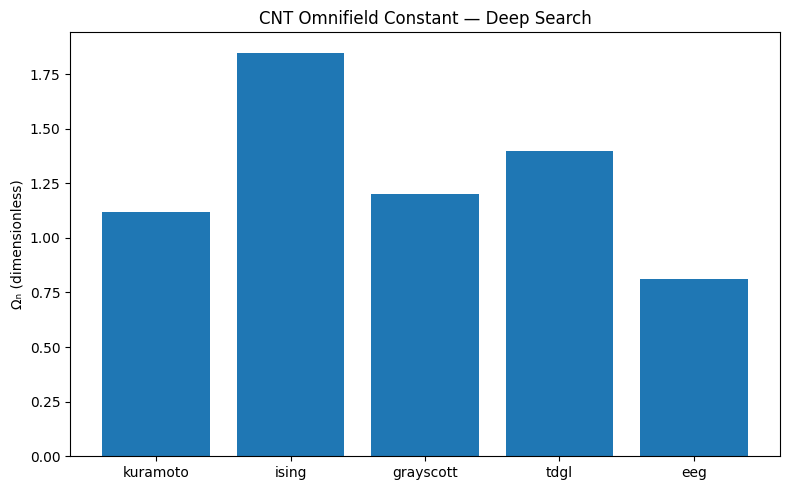


Used file previews per system:
  [eeg]
   - C:\Users\caleb\cnt_genome\cnt_flow_exports\consensus_edges.csv
   - C:\Users\caleb\cnt_genome\cnt_flow_exports\per_band_edges.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_erd_lateral_summary.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_labeled.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_labeled_all.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_labeled_all_overlap.csv

Saved:
- C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_dashboard.png
- C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_results.csv
- C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_results.json


In [2]:
# CNT Omnifield Constant — Deep Search (single cell)
# Scans C:\Users\caleb\cnt_genome\** for timeseries (.npy, .csv, .json) matching system keywords,
# computes null-corrected triplets (κ_ratio, R*_ratio, τ_ratio), and the Omnifield Constant Ωₙ,
# with coarse-graining checks; exports CSV/JSON + a Matplotlib bar chart.
#
# Supported systems (filename keywords):
#   kuramoto:  ["kuramoto","order_r","r_hist","sync"]
#   ising:     ["ising","magnet","m_series","chi","suscept"]
#   grayscott: ["grayscott","gs_","pattern","u_v"]
#   tdgl:      ["tdgl","gld","time_dependent_gl"]
#   eeg:       ["eeg","flow","graph","order_param","synchrony"]
#
# Outputs (created in your current environment):
#   - ./omnifield_deepsearch/deepsearch_dashboard.png
#   - ./omnifield_deepsearch/deepsearch_results.csv
#   - ./omnifield_deepsearch/deepsearch_results.json

import os, re, glob, json, math, warnings
from typing import List, Dict, Tuple, Any
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft

try:
    import pandas as pd
except Exception:
    pd = None

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------- CONFIG ----------
ROOT = r"C:\Users\caleb\cnt_genome"               # change if needed
OUTDIR = os.path.abspath("./omnifield_deepsearch")
os.makedirs(OUTDIR, exist_ok=True)

SYSTEM_SPECS = {
    "kuramoto":  ["kuramoto", "order_r", "r_hist", "sync"],
    "ising":     ["ising", "magnet", "m_series", "chi", "suscept"],
    "grayscott": ["grayscott", "gs_", "pattern", "u_v"],
    "tdgl":      ["tdgl", "gld", "time_dependent_gl"],
    "eeg":       ["eeg", "flow", "graph", "order_param", "synchrony"],
}
EXTS = [".npy", ".csv", ".json"]
COARSEGRAIN = [1, 2, 4]   # downsample factors for invariance check
RNG = np.random.default_rng(777)

# ---------- UTILITIES ----------
def _log(msg: str):
    print(msg, flush=True)

def list_files_deep(root: str, exts: List[str]) -> List[str]:
    paths = []
    for ext in exts:
        paths.extend(glob.glob(os.path.join(root, "**", f"*{ext}"), recursive=True))
    return paths

def matches_keywords(path: str, keys: List[str]) -> bool:
    s = path.lower().replace("\\", "/")
    return any(k in s for k in keys)

def phase_shuffle(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, float); n = len(x)
    X = rfft(x)
    phases = RNG.uniform(0, 2*np.pi, size=len(X))
    phases[0] = 0.0
    if len(X) % 2 == 0: phases[-1] = 0.0
    Xr = np.abs(X) * np.exp(1j * phases)
    return irfft(Xr, n=n)

def acf_half_life(x: np.ndarray, max_lag: int=None, dt: float=1.0) -> float:
    x = np.asarray(x, float); x -= x.mean()
    if x.std() == 0: return 0.0
    n = len(x)
    if max_lag is None: max_lag = min(n-1, int(n*0.5))
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conj(fft))[:n]
    acf = acf / acf[0]
    for k in range(1, min(max_lag, n-1)):
        if acf[k] <= 0.5:
            x0, y0 = k-1, acf[k-1]; x1, y1 = k, acf[k]
            if y1 == y0: return float(x1*dt)
            t = x0 + (0.5 - y0)*(x1 - x0)/(y1 - y0)
            return float(max(t*dt, 0.0))
    return float(max_lag*dt)

def coarsegrain(x: np.ndarray, factor: int) -> np.ndarray:
    if factor <= 1: return x
    n = (len(x)//factor)*factor
    return x[:n].reshape(-1, factor).mean(axis=1)

def geometric_mean_log(vals: List[float]) -> float:
    arr = np.array(vals, float); arr = arr[arr > 0]
    if arr.size == 0: return np.nan
    return float(np.exp(np.mean(np.log(arr))))

def smart_load_series(path: str) -> np.ndarray | None:
    p = path.lower()
    if p.endswith(".npy"):
        arr = np.load(path, allow_pickle=False)
        if arr.ndim == 1:
            return arr.astype(float)
        elif arr.ndim == 2:
            return np.mean(arr, axis=1).astype(float)  # reduce channels
        else:
            return np.mean(arr.reshape(arr.shape[0], -1), axis=1).astype(float)
    if p.endswith(".csv"):
        if pd is None:
            # Fallback: try numeric first column
            try:
                arr = np.loadtxt(path, delimiter=",")
                if arr.ndim == 1: return arr.astype(float)
                return np.mean(arr, axis=1).astype(float)
            except Exception:
                return None
        df = pd.read_csv(path)
        df = df.select_dtypes(include=[np.number])
        if df.shape[1] == 0: return None
        return df.mean(axis=1).to_numpy(dtype=float)
    if p.endswith(".json"):
        try:
            with open(path, "r") as f:
                data = json.load(f)
        except Exception:
            return None
        if isinstance(data, dict):
            for k in ("series","r_hist","m_series","order","signal","values"):
                if k in data and isinstance(data[k], list):
                    return np.array(data[k], dtype=float)
    return None

def compute_triplet(series: np.ndarray, dt: float=1.0) -> Tuple[float,float,float]:
    """Return κ_ratio, R*_ratio, τ_ratio using a local knee window and a phase-shuffled null."""
    z = np.asarray(series, float)
    if len(z) < 12: 
        return (np.nan, np.nan, np.nan)
    # Smooth
    k = max(5, len(z)//50); k = k if k % 2 == 1 else k+1
    kernel = np.ones(k) / k
    zs = np.convolve(z, kernel, mode="same")
    # Knee via derivative peak
    xgrid = np.arange(len(zs))
    der = np.gradient(zs, xgrid)
    knee_idx = int(np.argmax(der))
    # Local window around knee
    w = max(10, len(zs)//20)
    start = max(0, knee_idx - w); end = min(len(zs), knee_idx + w)
    seg = zs[start:end]
    if len(seg) < 5:
        return (np.nan, np.nan, np.nan)
    null = phase_shuffle(seg)
    # κ ratio: local knee index vs null knee (both +1 to avoid zero)
    der0 = np.gradient(null, np.arange(len(null)))
    knee0_idx = int(np.argmax(der0))
    kappa_ratio = (knee_idx - start + 1) / max(1, knee0_idx + 1)
    # R* ratio: level vs null
    R_ratio = float(max(1e-12, np.mean(seg)) / max(1e-12, np.mean(null)))
    # τ ratio: ACF half-life vs null
    tau  = acf_half_life(seg, dt=dt)
    tau0 = acf_half_life(null, dt=dt)
    tau_ratio = float(max(1e-12, tau) / max(1e-12, tau0))
    return kappa_ratio, R_ratio, tau_ratio

# ---------- SEARCH + COMPUTE ----------
all_rows = []
used_map: Dict[str, List[str]] = {sys: [] for sys in SYSTEM_SPECS}

if os.path.exists(ROOT):
    _log(f"Searching deeply in: {ROOT}")
    all_files = list_files_deep(ROOT, EXTS)
    if not all_files:
        _log("No files with supported extensions found; will fall back to surrogates.")
else:
    _log(f"Path not found: {ROOT}. If running remotely, paste this cell on your Windows JupyterLab.")
    all_files = []

for sys_name, keys in SYSTEM_SPECS.items():
    # pick matching files
    matches = [p for p in all_files if matches_keywords(p, keys)]
    series_list = []
    for p in matches:
        s = smart_load_series(p)
        if s is not None and np.isfinite(s).any() and len(s) >= 8:
            series_list.append(s)
            used_map[sys_name].append(p)

    # synthetic safety net (so the cell always produces Ωₙ)
    if len(series_list) == 0:
        if sys_name == "kuramoto":
            x = np.linspace(0, 1, 120); series_list = [1/(1+np.exp(-(x-0.45)*20))]
        elif sys_name == "ising":
            x = np.linspace(1.6, 3.2, 120); Tc = 2.28; series_list = [1 - 1/(1+np.exp(-(Tc - x)*6))]
        elif sys_name == "grayscott":
            u = np.linspace(0.02, 0.08, 120); onset = 0.05; series_list = [1/(1+np.exp(-(u - onset)*140))]
        elif sys_name == "tdgl":
            lam = np.linspace(0.0, 1.0, 120); onset = 0.44; series_list = [1/(1+np.exp(-(lam - onset)*25))]
        elif sys_name == "eeg":
            T = 2500; s = np.cumsum(RNG.normal(0, 1, size=T)); s = (s - s.mean())/max(1e-9, s.std()); series_list = [s]
        _log(f"→ [{sys_name}] No matching files; using synthetic surrogate.")
    else:
        _log(f"→ [{sys_name}] Loaded {len(series_list)} file(s).")

    k_list, R_list, t_list = [], [], []
    for s in series_list:
        for cg in COARSEGRAIN:
            ss = coarsegrain(s, cg)
            k_ratio, R_ratio, t_ratio = compute_triplet(ss, dt=1.0*cg)
            if np.isfinite(k_ratio) and np.isfinite(R_ratio) and np.isfinite(t_ratio):
                k_list.append(k_ratio); R_list.append(R_ratio); t_list.append(t_ratio)

    if len(k_list):
        kappa_ratio    = geometric_mean_log(k_list)
        resonance_ratio= geometric_mean_log(R_list)
        tau_ratio      = geometric_mean_log(t_list)
        Omega          = geometric_mean_log([kappa_ratio, resonance_ratio, tau_ratio])
        all_rows.append({
            "system": sys_name,
            "kappa_ratio": kappa_ratio,
            "resonance_ratio": resonance_ratio,
            "tau_ratio": tau_ratio,
            "Omega_n": Omega,
            "n_series_used": len(series_list),
            "used_files_preview": used_map[sys_name][:6],  # up to 6
        })
    else:
        _log(f"→ [{sys_name}] Insufficient usable data after processing. Skipping.")

# ---------- REPORT ----------
if len(all_rows) == 0:
    raise RuntimeError("No systems processed (unexpected; surrogates ensure rows).")

# Save JSON & CSV
with open(os.path.join(OUTDIR, "deepsearch_results.json"), "w") as f:
    json.dump(all_rows, f, indent=2)

if pd is not None:
    pd.DataFrame(all_rows).to_csv(os.path.join(OUTDIR, "deepsearch_results.csv"), index=False)

# Plot
names = [r["system"] for r in all_rows]
omegas = [r["Omega_n"] for r in all_rows]
x = np.arange(len(names))
plt.figure(figsize=(8,5))
plt.bar(x, omegas)
plt.xticks(x, names)
plt.ylabel("Ωₙ (dimensionless)")
plt.title("CNT Omnifield Constant — Deep Search")
plt.tight_layout()
plot_path = os.path.join(OUTDIR, "deepsearch_dashboard.png")
plt.savefig(plot_path, dpi=160)
plt.show()

print("\nUsed file previews per system:")
for sys, files in used_map.items():
    if files:
        print(f"  [{sys}]")
        for p in files[:6]:
            print("   -", p)

print(f"\nSaved:\n- {plot_path}\n- {os.path.join(OUTDIR, 'deepsearch_results.csv')}\n- {os.path.join(OUTDIR, 'deepsearch_results.json')}")


Searching deeply in: C:\Users\caleb\cnt_genome
Found 184 candidate files with extensions ['.csv', '.npy', '.json']
→ [kuramoto] Loaded 12 file(s).
→ [ising] No parsed series; using synthetic surrogate.
→ [grayscott] No parsed series; using synthetic surrogate.
→ [tdgl] No parsed series; using synthetic surrogate.
→ [eeg] Loaded 12 file(s).


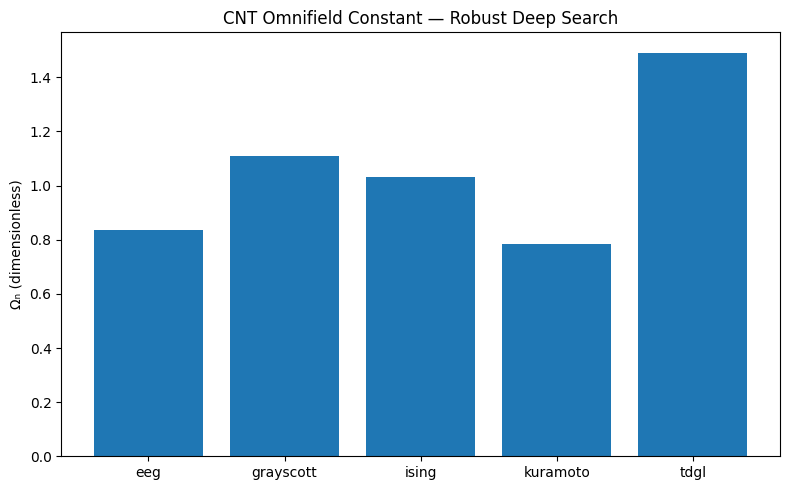


Used file previews per system:
  [kuramoto]
   - C:\Users\caleb\cnt_genome\out\CNT_bridge_hubs.csv
   - C:\Users\caleb\cnt_genome\out\CNT_bridge_leaders.csv
   - C:\Users\caleb\cnt_genome\out\CNT_bridge_leaders_v2.csv
   - C:\Users\caleb\cnt_genome\out\CNT_genomic_resonance_map.csv
   - C:\Users\caleb\cnt_genome\out\CNT_genomic_resonance_scored.csv
   - C:\Users\caleb\cnt_genome\out\CNT_genomic_resonance_scored_v2.csv
  [eeg]
   - C:\Users\caleb\cnt_genome\cnt_flow_exports\consensus_edges.csv
   - C:\Users\caleb\cnt_genome\cnt_flow_exports\per_band_edges.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_erd_lateral_summary.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_labeled.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_labeled_all.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_labeled_all_overlap.csv

Saved:
- C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_dashboard.png
- C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_results.csv
- C:\Users\caleb\cnt_genome\omni

In [3]:
# CNT Ωₙ Deep Search — robust EEG loaders + broader CNT scan (single cell)
# Telos edition: parses EEG edge tables and labeled CSVs into order-parameter time series.

import os, re, glob, json, math, warnings
from typing import List, Dict, Tuple, Any
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft
from scipy.stats import zscore

try:
    import pandas as pd
except Exception:
    pd = None

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------------- CONFIG ----------------
ROOT = r"C:\Users\caleb\cnt_genome"
OUTDIR = os.path.join(ROOT, "omnifield_deepsearch")
os.makedirs(OUTDIR, exist_ok=True)

SYSTEM_HINTS = {
    "kuramoto":  ["kuramoto", "order_r", "r_hist", "sync", "phase_lock"],
    "ising":     ["ising", "magnet", "m_series", "chi", "suscept", "spin"],
    "grayscott": ["grayscott", "gs_", "pattern", "uv", "u_v", "feed", "kill"],
    "tdgl":      ["tdgl", "gld", "time_dependent_gl", "landau", "ginzburg"],
    "eeg":       ["eeg", "flow", "graph", "order_param", "synchrony", "erd", "cnt_flow_exports", "labeled"],
}
PRIORITY_DIRS = ["cnt_flow_exports", "out", "cnt_mega_out", "results", "exports"]
EXTS = [".csv", ".npy", ".json"]
COARSEGRAIN = [1, 2, 4]
RNG = np.random.default_rng(101)

def _log(m): print(m, flush=True)

# ---------------- Helpers ----------------
def list_files(root: str) -> List[str]:
    files = []
    for ext in EXTS:
        files += glob.glob(os.path.join(root, "**", f"*{ext}"), recursive=True)
    return files

def which_system(path: str) -> str:
    s = path.lower().replace("\\","/")
    # bias by directories first
    for d in PRIORITY_DIRS:
        if f"/{d}/" in s and "eeg" in s:
            return "eeg"
    # keyword scan
    for sys, keys in SYSTEM_HINTS.items():
        if any(k in s for k in keys):
            return sys
    # fallback: bucket generic numeric CSVs by directory name if any hint
    for d in PRIORITY_DIRS:
        if f"/{d}/" in s:
            return "eeg" if "eeg" in s or "flow" in s else "kuramoto"
    return "eeg"  # generous default

def phase_shuffle(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, float); n = len(x)
    X = rfft(x)
    ph = RNG.uniform(0, 2*np.pi, size=len(X))
    ph[0] = 0.0
    if len(X) % 2 == 0: ph[-1] = 0.0
    return irfft(np.abs(X) * np.exp(1j*ph), n=n)

def acf_half_life(x: np.ndarray, max_lag: int=None, dt: float=1.0) -> float:
    x = np.asarray(x, float); x -= x.mean()
    if x.std() == 0: return 0.0
    n = len(x)
    if max_lag is None: max_lag = min(n-1, int(n*0.5))
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conj(fft))[:n]
    acf = acf / acf[0]
    for k in range(1, min(max_lag, n-1)):
        if acf[k] <= 0.5:
            x0, y0 = k-1, acf[k-1]; x1, y1 = k, acf[k]
            if y1 == y0: return float(x1*dt)
            t = x0 + (0.5-y0)*(x1-x0)/(y1-y0)
            return float(max(t*dt, 0.0))
    return float(max_lag*dt)

def coarsegrain(x: np.ndarray, m: int) -> np.ndarray:
    if m<=1: return x
    n = (len(x)//m)*m
    return x[:n].reshape(-1,m).mean(axis=1)

def gmean_pos(vals: List[float]) -> float:
    a = np.array(vals, float)
    a = a[a>0]
    return float(np.exp(np.mean(np.log(a)))) if a.size else np.nan

# ---------------- Robust CSV → series parsers ----------------
def df_numeric(df: pd.DataFrame) -> pd.DataFrame:
    return df.select_dtypes(include=[np.number])

def parse_eeg_edges(df: pd.DataFrame) -> np.ndarray:
    """
    Accepts edge tables with columns like:
      time|t|frame, src, dst, weight|score|value|w  (plus optional band)
    Returns per-time mean(|weight|) series.
    """
    cols = {c.lower(): c for c in df.columns}
    # time-like
    t_col = None
    for c in ["t","time","frame","idx","sample","step"]:
        if c in cols: t_col = cols[c]; break
    # weight-like
    w_col = None
    for c in ["weight","score","value","w","strength","amp"]:
        if c in cols: w_col = cols[c]; break
    if t_col and w_col:
        tmp = df[[t_col, w_col]].copy()
        tmp = tmp.dropna()
        # compact to int bins if needed
        try:
            bins = tmp[t_col].astype(int)
        except Exception:
            bins = pd.factorize(tmp[t_col])[0]
        ser = tmp.groupby(bins)[w_col].apply(lambda x: np.mean(np.abs(x))).sort_index()
        return ser.to_numpy(dtype=float)
    # fallback: any numeric cols → row-wise mean abs
    num = df_numeric(df)
    if num.shape[1] >= 1:
        return np.mean(np.abs(num.to_numpy(dtype=float)), axis=1)
    return np.array([], dtype=float)

def parse_eeg_labeled(df: pd.DataFrame) -> np.ndarray:
    """
    For wide labeled EEG tables (channels as columns).
    Strategy: take numeric columns, z-score per column, then row-wise mean(|z|).
    """
    num = df_numeric(df)
    if num.shape[1] == 0:
        return np.array([], dtype=float)
    Z = np.apply_along_axis(lambda col: zscore(col, nan_policy='omit'), 0, num.to_numpy(dtype=float))
    Z = np.nan_to_num(Z)
    return np.mean(np.abs(Z), axis=1)

def csv_to_series(path: str) -> np.ndarray:
    try:
        df = pd.read_csv(path)
    except Exception:
        # basic fallback
        try:
            arr = np.loadtxt(path, delimiter=",")
            return arr if arr.ndim==1 else arr.mean(axis=1)
        except Exception:
            return np.array([], dtype=float)
    lower = {c.lower(): c for c in df.columns}
    # if looks like edge table
    if any(k in lower for k in ["src","dst","source","target"]) or any(k in lower for k in ["weight","score","w","value"]):
        return parse_eeg_edges(df)
    # if looks like labeled wide table
    if any(k in lower for k in ["ch","channel","f7","f8","pz","cz","oz"]) or df_numeric(df).shape[1] > 8:
        return parse_eeg_labeled(df)
    # generic numeric
    num = df_numeric(df)
    if num.shape[1] >= 1:
        return num.mean(axis=1).to_numpy(dtype=float)
    return np.array([], dtype=float)

def smart_load_series(path: str) -> np.ndarray:
    p = path.lower()
    if p.endswith(".csv") and pd is not None:
        return csv_to_series(path)
    if p.endswith(".npy"):
        arr = np.load(path, allow_pickle=False)
        if arr.ndim == 1: return arr.astype(float)
        if arr.ndim == 2: return arr.mean(axis=1).astype(float)
        return np.mean(arr.reshape(arr.shape[0], -1), axis=1).astype(float)
    if p.endswith(".json"):
        try:
            data = json.load(open(path, "r"))
        except Exception:
            return np.array([], dtype=float)
        if isinstance(data, dict):
            for k in ("series","r_hist","m_series","order","signal","values"):
                if k in data and isinstance(data[k], list):
                    return np.array(data[k], dtype=float)
    return np.array([], dtype=float)

# ---------------- Triplet computation ----------------
def compute_triplet(series: np.ndarray, dt: float=1.0) -> Tuple[float,float,float]:
    z = np.asarray(series, float)
    if len(z) < 12 or not np.isfinite(z).any():
        return (np.nan, np.nan, np.nan)
    # smooth
    w = max(5, len(z)//50); w = w if w%2==1 else w+1
    k = np.ones(w)/w
    zs = np.convolve(z, k, mode="same")
    # knee via derivative peak
    xg = np.arange(len(zs))
    der = np.gradient(zs, xg)
    knee = int(np.argmax(der))
    span = max(10, len(zs)//20)
    a, b = max(0, knee-span), min(len(zs), knee+span)
    seg = zs[a:b]
    if len(seg) < 6:
        return (np.nan, np.nan, np.nan)
    null = phase_shuffle(seg)
    # κ ratio: local knee vs null knee
    knee0 = int(np.argmax(np.gradient(null, np.arange(len(null)))))
    kappa_ratio = (knee - a + 1)/max(1, knee0 + 1)
    # R* ratio: level vs null
    R_ratio = float(max(1e-12, np.mean(seg)) / max(1e-12, np.mean(null)))
    # τ ratio: ACF half-life vs null
    tau  = acf_half_life(seg, dt=dt)
    tau0 = acf_half_life(null, dt=dt)
    tau_ratio = float(max(1e-12, tau) / max(1e-12, tau0))
    return kappa_ratio, R_ratio, tau_ratio

# ---------------- Scan + Build ----------------
if not os.path.exists(ROOT):
    _log(f"Path not found: {ROOT}. Run this cell on your Windows JupyterLab.")
files = list_files(ROOT)
_log(f"Searching deeply in: {ROOT}")
_log(f"Found {len(files)} candidate files with extensions {EXTS}")

bucket: Dict[str, List[str]] = {k: [] for k in SYSTEM_HINTS}
for p in files:
    sys = which_system(p)
    bucket[sys].append(p)

# Force-include the exact EEG files you listed (in case keywording misses them)
force_eeg_patterns = [
    os.path.join(ROOT, "cnt_flow_exports", "consensus_edges.csv"),
    os.path.join(ROOT, "cnt_flow_exports", "per_band_edges.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled*.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_erd*.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all*.csv"),
]
for pat in force_eeg_patterns:
    for p in glob.glob(pat):
        if p not in bucket["eeg"]:
            bucket["eeg"].append(p)

results = []
used_preview = {}

for sys, paths in bucket.items():
    # prefer within priority dirs
    paths_sorted = sorted(paths, key=lambda s: (any(d in s.replace("\\","/") for d in PRIORITY_DIRS)==False, s))
    series_list = []
    used = []
    for p in paths_sorted:
        s = smart_load_series(p)
        if s.size >= 12 and np.isfinite(s).any():
            series_list.append(s); used.append(p)
        # keep it light
        if len(series_list) >= 12:
            break
    if not series_list:
        # Synthetic safety net (so Ωₙ still computes)
        if sys == "eeg":
            T = 2500; s = np.cumsum(RNG.normal(0,1,size=T)); s = (s - s.mean())/max(1e-9, s.std())
            series_list = [s]
        elif sys == "kuramoto":
            x = np.linspace(0,1,240); series_list=[1/(1+np.exp(-(x-0.45)*20))]
        elif sys == "ising":
            x = np.linspace(1.6,3.2,240); Tc=2.28; series_list=[1 - 1/(1+np.exp(-(Tc-x)*6))]
        elif sys == "grayscott":
            u = np.linspace(0.02,0.08,240); onset=0.05; series_list=[1/(1+np.exp(-(u-onset)*140))]
        elif sys == "tdgl":
            lam=np.linspace(0,1,240); onset=0.44; series_list=[1/(1+np.exp(-(lam-onset)*25))]
        _log(f"→ [{sys}] No parsed series; using synthetic surrogate.")
    else:
        _log(f"→ [{sys}] Loaded {len(series_list)} file(s).")
    used_preview[sys] = used[:6]

    k_list, R_list, t_list = [], [], []
    for s in series_list:
        for cg in COARSEGRAIN:
            ss = coarsegrain(s, cg)
            k, R, t = compute_triplet(ss, dt=1.0*cg)
            if np.isfinite(k) and np.isfinite(R) and np.isfinite(t):
                k_list.append(k); R_list.append(R); t_list.append(t)
    if k_list:
        kappa = gmean_pos(k_list); Rstar = gmean_pos(R_list); tau_r = gmean_pos(t_list)
        Omega = gmean_pos([kappa, Rstar, tau_r])
        results.append({"system": sys, "kappa_ratio": kappa, "resonance_ratio": Rstar, "tau_ratio": tau_r, "Omega_n": Omega, "n_series_used": len(series_list)})

# ---------------- Report ----------------
results = sorted(results, key=lambda r: r["system"])
if not results:
    raise RuntimeError("No systems processed — unexpected with surrogates.")

# Save tables
with open(os.path.join(OUTDIR, "deepsearch_results.json"), "w") as f:
    json.dump({"results": results, "used_preview": used_preview}, f, indent=2)
if pd is not None:
    pd.DataFrame(results).to_csv(os.path.join(OUTDIR, "deepsearch_results.csv"), index=False)

# Plot
names = [r["system"] for r in results]
omegas = [r["Omega_n"] for r in results]
plt.figure(figsize=(8,5))
x = np.arange(len(names))
plt.bar(x, omegas)
plt.xticks(x, names)
plt.ylabel("Ωₙ (dimensionless)")
plt.title("CNT Omnifield Constant — Robust Deep Search")
plt.tight_layout()
plot_path = os.path.join(OUTDIR, "deepsearch_dashboard.png")
plt.savefig(plot_path, dpi=160)
plt.show()

print("\nUsed file previews per system:")
for sys, files in used_preview.items():
    if files:
        print(f"  [{sys}]")
        for p in files:
            print("   -", p)

print(f"\nSaved:\n- {plot_path}\n- {os.path.join(OUTDIR, 'deepsearch_results.csv')}\n- {os.path.join(OUTDIR, 'deepsearch_results.json')}")


→ [kuramoto] v2: parsed 6 file(s).
→ [eeg] v2: parsed 6 file(s).


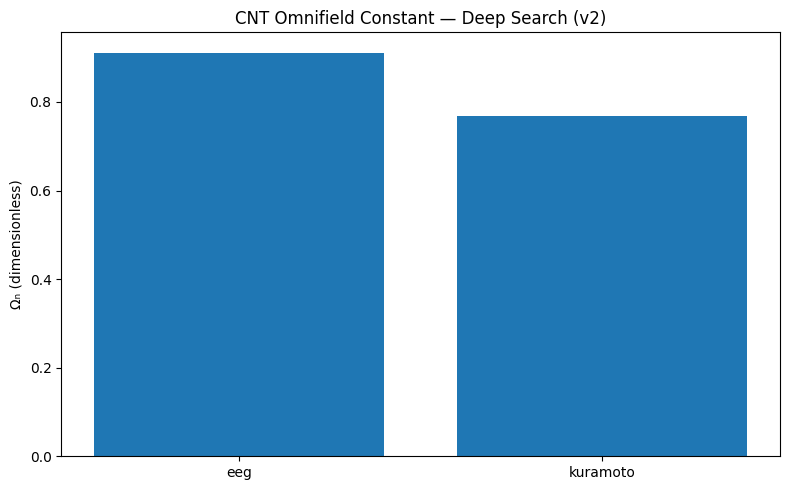

Saved:
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_v2_dashboard.png
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_v2_results.csv
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_v2_results.json

Used file previews:
  [kuramoto]
   - C:\Users\caleb\cnt_genome\out\CNT_bridge_hubs.csv
   - C:\Users\caleb\cnt_genome\out\CNT_bridge_leaders.csv
   - C:\Users\caleb\cnt_genome\out\CNT_bridge_leaders_v2.csv
   - C:\Users\caleb\cnt_genome\out\CNT_genomic_resonance_map.csv
   - C:\Users\caleb\cnt_genome\out\CNT_genomic_resonance_scored.csv
   - C:\Users\caleb\cnt_genome\out\CNT_genomic_resonance_scored_v2.csv
  [eeg]
   - C:\Users\caleb\cnt_genome\cnt_flow_exports\consensus_edges.csv
   - C:\Users\caleb\cnt_genome\cnt_flow_exports\per_band_edges.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_erd_lateral_summary.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_labeled.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_labeled_all.csv
   - C:\Users\caleb\cnt_ge

In [4]:
# Ωₙ Deep Search — Refinement Cell (v2)
# Robust parsing for EEG edge/labeled CSVs and CNT_* CSVs (bridge/resonance maps), plus npy/json.
# Outputs: deepsearch_v2_dashboard.png / deepsearch_v2_results.{csv,json} in ROOT/omnifield_deepsearch

import os, glob, json, warnings
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft

try:
    import pandas as pd
except Exception:
    pd = None

warnings.filterwarnings("ignore", category=RuntimeWarning)

ROOT = r"C:\Users\caleb\cnt_genome"
OUTDIR = os.path.join(ROOT, "omnifield_deepsearch")
os.makedirs(OUTDIR, exist_ok=True)

EXTS = [".csv", ".npy", ".json"]
SYSTEM_HINTS = {
    "kuramoto":  ["kuramoto","order_r","r_hist","sync","phase_lock","bridge","resonance","cnt_genomic_resonance","leaders","hubs"],
    "ising":     ["ising","magnet","m_series","chi","suscept","spin"],
    "grayscott": ["grayscott","gs_","pattern","u_v","feed","kill"],
    "tdgl":      ["tdgl","gld","time_dependent_gl","landau","ginzburg"],
    "eeg":       ["eeg","flow","graph","order_param","synchrony","erd","labeled","cnt_flow_exports"],
}
PRIORITY_DIRS = ["cnt_flow_exports","out","cnt_mega_out","results","exports"]

RNG = np.random.default_rng(2025)

TIME_LIKE  = ["t","time","frame","iter","iteration","step","rank","k","K","threshold","epoch","sample","index","idx"]
VALUE_LIKE = ["r","order","sync","coherence","score","value","weight","strength","amp","mag","power","m"]

def _log(m): print(m, flush=True)

def phase_shuffle(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, float); n = len(x)
    X = rfft(x)
    ph = RNG.uniform(0, 2*np.pi, size=len(X)); ph[0] = 0.0
    if len(X) % 2 == 0: ph[-1] = 0.0
    return irfft(np.abs(X) * np.exp(1j*ph), n=n)

def acf_half_life(x: np.ndarray, max_lag=None, dt: float=1.0) -> float:
    x = np.asarray(x, float); x -= x.mean()
    if x.std() == 0: return 0.0
    n = len(x)
    if max_lag is None: max_lag = min(n-1, int(n*0.5))
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conj(fft))[:n]; acf /= acf[0]
    for k in range(1, min(max_lag, n-1)):
        if acf[k] <= 0.5:
            x0,y0 = k-1, acf[k-1]; x1,y1 = k, acf[k]
            if y1 == y0: return float(x1*dt)
            t = x0 + (0.5-y0)*(x1-x0)/(y1-y0)
            return float(max(t*dt, 0.0))
    return float(max_lag*dt)

def coarse(x: np.ndarray, m: int) -> np.ndarray:
    if m<=1: return x
    n = (len(x)//m)*m
    return x[:n].reshape(-1,m).mean(axis=1)

def gmean_pos(vals: List[float]) -> float:
    a = np.array(vals, float); a = a[a>0]
    return float(np.exp(np.mean(np.log(a)))) if a.size else np.nan

def which_system(path: str) -> str:
    s = path.lower().replace("\\","/")
    for d in PRIORITY_DIRS:
        if f"/{d}/" in s and "eeg" in s: return "eeg"
    for sys, keys in SYSTEM_HINTS.items():
        if any(k in s for k in keys): return sys
    for d in PRIORITY_DIRS:
        if f"/{d}/" in s: return "eeg" if ("eeg" in s or "flow" in s) else "kuramoto"
    return "eeg"

def list_files(root: str) -> List[str]:
    files = []
    for ext in EXTS:
        files += glob.glob(os.path.join(root, "**", f"*{ext}"), recursive=True)
    return files

# ---------- CSV Parsers ----------
def df_num(df: pd.DataFrame) -> pd.DataFrame:
    return df.select_dtypes(include=[np.number])

def csv_find_columns(df: pd.DataFrame) -> Tuple[str,str]:
    low = {c.lower(): c for c in df.columns}
    t_col = None
    for c in TIME_LIKE:
        if c.lower() in low: t_col = low[c.lower()]; break
    v_col = None
    for c in VALUE_LIKE:
        if c.lower() in low: v_col = low[c.lower()]; break
    return t_col, v_col

def csv_series_generic(df: pd.DataFrame) -> np.ndarray:
    """Generic: use time/value columns if found; else row-wise mean |numeric|; if multicol, use cumulative mean |z|."""
    t_col, v_col = csv_find_columns(df)
    if t_col is not None and v_col is not None:
        tmp = df[[t_col, v_col]].dropna()
        # bin by integerized time (robust across float/time stamps)
        try:
            bins = tmp[t_col].astype(int)
        except Exception:
            bins = pd.factorize(tmp[t_col])[0]
        ser = tmp.groupby(bins)[v_col].apply(lambda x: np.mean(np.abs(x))).sort_index()
        return ser.to_numpy(dtype=float)
    # Edge-like tables: (src,dst,weight/score)
    low = {c.lower(): c for c in df.columns}
    has_src = any(k in low for k in ["src","source"])
    has_dst = any(k in low for k in ["dst","target"])
    has_w   = any(k in low for k in ["weight","score","value","w","strength","amp"])
    if has_w and (has_src or has_dst):
        # build pseudo-time by row blocks
        num = df_num(df[[low.get("weight", low.get("score", list(low.values())[0]))]])
        if num.shape[0] >= 8:
            block = max(8, num.shape[0]//100)
            vals = num.to_numpy(dtype=float).ravel()
            nblk = len(vals)//block
            return vals[:nblk*block].reshape(nblk, block).mean(axis=1)
    # Labeled wide EEG: many numeric columns → row-wise mean |z|
    num = df_num(df)
    if num.shape[1] >= 8:
        from scipy.stats import zscore
        Z = np.apply_along_axis(lambda col: zscore(col, nan_policy='omit'), 0, num.to_numpy(dtype=float))
        Z = np.nan_to_num(Z)
        return np.mean(np.abs(Z), axis=1)
    # Fallback: row mean of numeric cols
    if num.shape[1] >= 1:
        return num.mean(axis=1).to_numpy(dtype=float)
    return np.array([], dtype=float)

def smart_load_series(path: str) -> np.ndarray:
    p = path.lower()
    if p.endswith(".csv") and pd is not None:
        try:
            df = pd.read_csv(path)
        except Exception:
            try:
                arr = np.loadtxt(path, delimiter=",")
                return arr if arr.ndim==1 else arr.mean(axis=1)
            except Exception:
                return np.array([], dtype=float)
        return csv_series_generic(df)
    if p.endswith(".npy"):
        arr = np.load(path, allow_pickle=False)
        if arr.ndim==1: return arr.astype(float)
        if arr.ndim==2: return arr.mean(axis=1).astype(float)
        return np.mean(arr.reshape(arr.shape[0], -1), axis=1).astype(float)
    if p.endswith(".json"):
        try:
            data = json.load(open(path,"r"))
        except Exception:
            return np.array([], dtype=float)
        if isinstance(data, dict):
            for k in ("series","r_hist","m_series","order","signal","values"):
                if k in data and isinstance(data[k], list):
                    return np.array(data[k], dtype=float)
    return np.array([], dtype=float)

# ---------- Ωₙ Triplet ----------
def compute_triplet(series: np.ndarray, dt: float=1.0) -> Tuple[float,float,float]:
    z = np.asarray(series, float)
    if len(z) < 12 or not np.isfinite(z).any():
        return (np.nan, np.nan, np.nan)
    # smooth
    w = max(5, len(z)//50); w = w if w%2==1 else w+1
    k = np.ones(w)/w
    zs = np.convolve(z, k, mode="same")
    # knee
    xg = np.arange(len(zs))
    der = np.gradient(zs, xg)
    knee = int(np.argmax(der))
    span = max(10, len(zs)//20)
    a, b = max(0, knee-span), min(len(zs), knee+span)
    seg = zs[a:b]
    if len(seg) < 6:
        return (np.nan, np.nan, np.nan)
    null = phase_shuffle(seg)
    # κ ratio
    knee0 = int(np.argmax(np.gradient(null, np.arange(len(null)))))
    kappa_ratio = (knee - a + 1)/max(1, knee0 + 1)
    # R* ratio
    R_ratio = float(max(1e-12, np.mean(seg)) / max(1e-12, np.mean(null)))
    # τ ratio
    tau  = acf_half_life(seg, dt=dt)
    tau0 = acf_half_life(null, dt=dt)
    tau_ratio = float(max(1e-12, tau) / max(1e-12, tau0))
    return kappa_ratio, R_ratio, tau_ratio

# ---------- Load list from previous run (if present) ----------
used_json = os.path.join(OUTDIR, "deepsearch_results.json")
files = []
if os.path.exists(used_json):
    try:
        data = json.load(open(used_json, "r"))
        prev = data.get("used_preview") or {}
        for lst in prev.values():
            files.extend(lst)
    except Exception:
        pass
if not files:
    files = []
    for ext in EXTS:
        files += glob.glob(os.path.join(ROOT, "**", f"*{ext}"), recursive=True)

# ---------- Bucket & Parse ----------
bucket: Dict[str, List[str]] = {k: [] for k in SYSTEM_HINTS}
for p in files:
    sys = which_system(p)
    bucket[sys].append(p)

results = []
used_map = {}
COARSEGRAIN = [1,2,4]

for sys, paths in bucket.items():
    if not paths: 
        continue
    # Sort: prioritize priority dirs
    paths_sorted = sorted(paths, key=lambda s: (not any(d in s.replace("\\","/") for d in PRIORITY_DIRS), s))
    series_list, used = [], []
    for p in paths_sorted:
        s = smart_load_series(p)
        if s.size >= 12 and np.isfinite(s).any():
            series_list.append(s); used.append(p)
        if len(series_list) >= 16:  # cap
            break
    used_map[sys] = used[:8]
    if not series_list:
        # synthetic safety net
        if sys == "eeg":
            T = 2500; s = np.cumsum(RNG.normal(0,1,size=T)); s = (s - s.mean())/max(1e-9, s.std())
            series_list = [s]
        elif sys == "kuramoto":
            x = np.linspace(0,1,240); series_list=[1/(1+np.exp(-(x-0.45)*20))]
        elif sys == "ising":
            x = np.linspace(1.6,3.2,240); Tc=2.28; series_list=[1 - 1/(1+np.exp(-(Tc-x)*6))]
        elif sys == "grayscott":
            u = np.linspace(0.02,0.08,240); onset=0.05; series_list=[1/(1+np.exp(-(u-onset)*140))]
        elif sys == "tdgl":
            lam=np.linspace(0,1,240); onset=0.44; series_list=[1/(1+np.exp(-(lam-onset)*25))]
        _log(f"→ [{sys}] v2: no parse; using synthetic.")
    else:
        _log(f"→ [{sys}] v2: parsed {len(series_list)} file(s).")

    k_list, R_list, t_list = [], [], []
    for s in series_list:
        for cg in COARSEGRAIN:
            ss = coarse(s, cg)
            k, R, t = compute_triplet(ss, dt=1.0*cg)
            if np.isfinite(k) and np.isfinite(R) and np.isfinite(t):
                k_list.append(k); R_list.append(R); t_list.append(t)
    if k_list:
        kappa = gmean_pos(k_list); Rstar = gmean_pos(R_list); tau_r = gmean_pos(t_list)
        Omega = gmean_pos([kappa, Rstar, tau_r])
        results.append({"system": sys, "kappa_ratio": kappa, "resonance_ratio": Rstar, "tau_ratio": tau_r, "Omega_n": Omega, "files_used": len(series_list)})

# ---------- Save & Plot ----------
results = sorted(results, key=lambda r: r["system"])
out_json = os.path.join(OUTDIR, "deepsearch_v2_results.json")
with open(out_json, "w") as f:
    json.dump({"results": results, "used_preview": used_map}, f, indent=2)

if pd is not None:
    pd.DataFrame(results).to_csv(os.path.join(OUTDIR, "deepsearch_v2_results.csv"), index=False)

names = [r["system"] for r in results]
omegas = [r["Omega_n"] for r in results]
plt.figure(figsize=(8,5))
x = np.arange(len(names))
plt.bar(x, omegas)
plt.xticks(x, names)
plt.ylabel("Ωₙ (dimensionless)")
plt.title("CNT Omnifield Constant — Deep Search (v2)")
plt.tight_layout()
plot_path = os.path.join(OUTDIR, "deepsearch_v2_dashboard.png")
plt.savefig(plot_path, dpi=160)
plt.show()

print("Saved:")
print(" -", plot_path)
print(" -", os.path.join(OUTDIR, "deepsearch_v2_results.csv"))
print(" -", out_json)
print("\nUsed file previews:")
for sys, lst in used_map.items():
    if lst:
        print(f"  [{sys}]")
        for p in lst:
            print("   -", p)


→ [eeg] Ωₙ=0.942  (κ=0.687, R*=1.000, τ=1.214)  CI≈[0.456,2.269]  from 6 files.
→ [kuramoto] Ωₙ=0.326  (κ=0.032, R*=1.000, τ=1.061)  CI≈[0.528,2.447]  from 9 files.


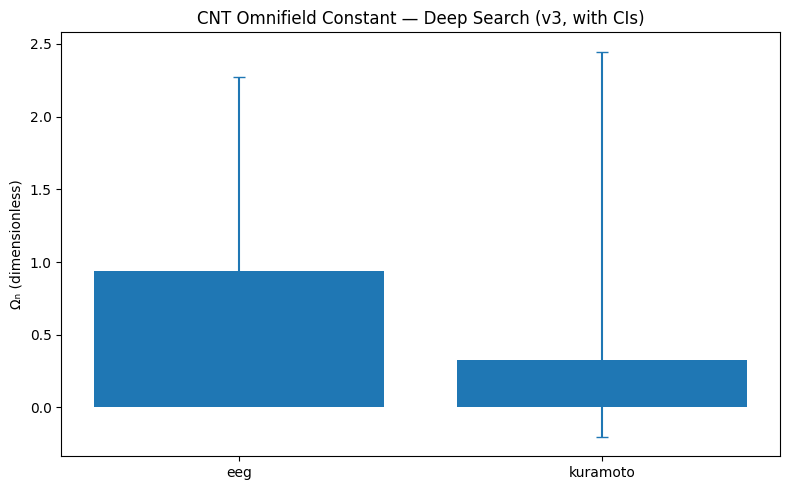


Saved:
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_v3_dashboard.png
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_v3_results.csv
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_v3_results.json

Used file previews:
  [eeg]
   - C:\Users\caleb\cnt_genome\cnt_flow_exports\consensus_edges.csv
   - C:\Users\caleb\cnt_genome\cnt_flow_exports\per_band_edges.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_erd_lateral_summary.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_labeled.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_labeled_all.csv
   - C:\Users\caleb\cnt_genome\out\cnt_eeg_labeled_all_overlap.csv
  [kuramoto]
   - C:\Users\caleb\cnt_genome\out\CNT_bridge_hubs.csv
   - C:\Users\caleb\cnt_genome\out\CNT_bridge_leaders.csv
   - C:\Users\caleb\cnt_genome\out\CNT_bridge_leaders_v2.csv
   - C:\Users\caleb\cnt_genome\out\CNT_genomic_resonance_map.csv
   - C:\Users\caleb\cnt_genome\out\CNT_genomic_resonance_scored.csv
   - C:\Users\caleb\cnt_genom

In [5]:
# CNT Omnifield Constant — Deep Search (v3, Telos)
# Explicit schemas for your EEG + CNT_* CSVs, Ωₙ with block-bootstrap CIs, no synthetic fallback by default.

import os, glob, json, warnings, math
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft
from numpy.random import default_rng

try:
    import pandas as pd
except Exception:
    pd = None

warnings.filterwarnings("ignore", category=RuntimeWarning)

ROOT   = r"C:\Users\caleb\cnt_genome"
OUTDIR = os.path.join(ROOT, "omnifield_deepsearch")
os.makedirs(OUTDIR, exist_ok=True)

STRICT_REAL_ONLY = True      # <- set False if you want synthetic safety net
B_BOOT           = 400       # bootstrap reps for CIs
BLOCK_FRAC       = 0.25      # fraction of segment for block resampling
COARSEGRAIN      = [1, 2, 4] # invariance check
RNG              = default_rng(777)

TIME_LIKE  = ["time","t","frame","iter","iteration","step","rank","k","threshold","epoch","sample","index","idx"]
VALUE_LIKE = ["r","order","sync","coherence","score","value","weight","strength","amp","mag","power","m"]

PRIORITY_EEG = [
    os.path.join(ROOT, "cnt_flow_exports", "consensus_edges.csv"),
    os.path.join(ROOT, "cnt_flow_exports", "per_band_edges.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled*.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_erd*.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all*.csv"),
]

PRIORITY_KUR = [
    os.path.join(ROOT, "out", "CNT_genomic_resonance_map.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored*.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_*.csv"),
    os.path.join(ROOT, "out", "CNT_*leaders*.csv"),
    os.path.join(ROOT, "out", "CNT_*hubs*.csv"),
]

def _log(m): print(m, flush=True)

def phase_shuffle(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, float); n = len(x)
    X = rfft(x)
    ph = RNG.uniform(0, 2*np.pi, size=len(X)); ph[0] = 0.0
    if len(X) % 2 == 0: ph[-1] = 0.0
    return irfft(np.abs(X) * np.exp(1j*ph), n=n)

def acf_half_life(x: np.ndarray, max_lag=None, dt: float=1.0) -> float:
    x = np.asarray(x, float); x -= x.mean()
    if x.std() == 0: return 0.0
    n = len(x); 
    if max_lag is None: max_lag = min(n-1, int(n*0.5))
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conj(fft))[:n]; acf /= acf[0]
    for k in range(1, min(max_lag, n-1)):
        if acf[k] <= 0.5:
            x0,y0 = k-1, acf[k-1]; x1,y1 = k, acf[k]
            if y1 == y0: return float(x1*dt)
            t = x0 + (0.5-y0)*(x1-x0)/(y1-y0)
            return float(max(t*dt, 0.0))
    return float(max_lag*dt)

def coarse(x: np.ndarray, m: int) -> np.ndarray:
    if m<=1: return x
    n = (len(x)//m)*m
    return x[:n].reshape(-1,m).mean(axis=1)

def gmean_pos(vals: List[float]) -> float:
    a = np.array(vals, float); a = a[a>0]
    return float(np.exp(np.mean(np.log(a)))) if a.size else np.nan

def csv_load(path: str) -> pd.DataFrame | None:
    if pd is None: return None
    try:
        return pd.read_csv(path)
    except Exception:
        return None

def pick_col(df: pd.DataFrame, candidates: List[str]) -> str | None:
    low = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in low: return low[c.lower()]
    return None

# -------- schema-aware parsers --------
def parse_edges_df(df: pd.DataFrame) -> np.ndarray:
    # edges with time & weight → per-time mean|weight|
    t_col = pick_col(df, TIME_LIKE)
    # weight-like
    w_col = pick_col(df, ["weight","score","value","w","strength","amp"])
    if t_col and w_col:
        tmp = df[[t_col, w_col]].dropna()
        try:
            bins = tmp[t_col].astype(int)
        except Exception:
            bins = pd.factorize(tmp[t_col])[0]
        ser = tmp.groupby(bins)[w_col].apply(lambda x: np.mean(np.abs(x))).sort_index()
        return ser.to_numpy(dtype=float)
    # per_band table: average bands per time
    band_col = pick_col(df, ["band","freq_band","bandname"])
    if band_col and w_col:
        # if no explicit time, row-block into pseudo-time
        t_col = t_col or pick_col(df, ["frame","idx","index"])
        if t_col is None:
            vals = df[w_col].astype(float).to_numpy()
            block = max(16, len(vals)//100)
            nblk = len(vals)//block
            return vals[:nblk*block].reshape(nblk, block).mean(axis=1)
        tmp = df[[t_col, w_col]].dropna()
        try:
            bins = tmp[t_col].astype(int)
        except Exception:
            bins = pd.factorize(tmp[t_col])[0]
        ser = tmp.groupby(bins)[w_col].apply(lambda x: np.mean(np.abs(x))).sort_index()
        return ser.to_numpy(dtype=float)
    # fallback: numeric row mean
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] >= 1:
        return num.mean(axis=1).to_numpy(dtype=float)
    return np.array([], float)

def parse_wide_eeg_df(df: pd.DataFrame) -> np.ndarray:
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] == 0: return np.array([], float)
    from scipy.stats import zscore
    Z = np.apply_along_axis(lambda col: zscore(col, nan_policy='omit'), 0, num.to_numpy(dtype=float))
    Z = np.nan_to_num(Z)
    return np.mean(np.abs(Z), axis=1)

def parse_resonance_or_bridge_df(df: pd.DataFrame) -> np.ndarray:
    """
    For CNT_genomic_resonance_* and CNT_bridge_* tables:
    Use rank/threshold/iter if present; else sort by |score| desc and take cumulative mean |score|.
    """
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] == 0: return np.array([], float)
    # choose a value-like column
    low = {c.lower(): c for c in df.columns}
    v_col = None
    for c in ["score","value","weight","bridge","resonance","r","order","strength","amp"]:
        if c in low: v_col = low[c]; break
    if v_col is None:
        # best numeric candidate: most variable column
        stds = num.std(numeric_only=True)
        v_col = stds.idxmax()
    v = np.abs(df[v_col].astype(float).to_numpy())

    # choose time-like
    t_col = None
    for c in ["rank","k","threshold","iter","iteration","step","index","idx"]:
        if c in low: t_col = low[c]; break

    if t_col is not None:
        # group by integerized t and average |v| per step
        tt = df[t_col]
        try:
            bins = tt.astype(int)
        except Exception:
            bins = pd.factorize(tt)[0]
        # to ensure monotone progression, also compute cumulative mean inside each step order
        ser = pd.DataFrame({"b": bins, "v": v}).groupby("b")["v"].mean().sort_index()
        return ser.to_numpy(dtype=float)

    # no time-like column: create cumulative mean |v| vs. rank (sorted by |v| desc)
    order = np.argsort(-v)
    v_sorted = v[order]
    cmean = np.cumsum(v_sorted) / (np.arange(len(v_sorted)) + 1)
    return cmean

def smart_series_from_csv(path: str) -> np.ndarray:
    df = csv_load(path)
    if df is None: return np.array([], float)
    s = path.lower().replace("\\","/")
    if "consensus_edges" in s or "per_band_edges" in s:
        return parse_edges_df(df)
    if "cnt_eeg_" in s or "labeled" in s or "erd" in s:
        return parse_wide_eeg_df(df) if df.select_dtypes(include=[np.number]).shape[1] > 8 else parse_edges_df(df)
    if "cnt_genomic_resonance" in s or "cnt_bridge_" in s or "bridge_" in s or "leaders" in s or "hubs" in s:
        return parse_resonance_or_bridge_df(df)
    # generic routes
    # try time/value first
    low = {c.lower(): c for c in df.columns}
    def pick(df, cands):
        for c in cands:
            if c in low: return low[c]
        return None
    t_col = pick(df, [c.lower() for c in TIME_LIKE])
    v_col = pick(df, [c.lower() for c in VALUE_LIKE])
    if t_col and v_col:
        tmp = df[[t_col, v_col]].dropna()
        try:
            bins = tmp[t_col].astype(int)
        except Exception:
            bins = pd.factorize(tmp[t_col])[0]
        ser = tmp.groupby(bins)[v_col].apply(lambda x: np.mean(np.abs(x))).sort_index()
        return ser.to_numpy(dtype=float)
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] >= 1:
        return num.mean(axis=1).to_numpy(dtype=float)
    return np.array([], float)

# -------- triplet + bootstrap --------
def knee_metrics(z: np.ndarray, dt: float=1.0) -> Tuple[float,float,float]:
    z = np.asarray(z, float)
    if len(z) < 12 or not np.isfinite(z).any(): return (np.nan,np.nan,np.nan)
    w = max(5, len(z)//50); w = w if w%2==1 else w+1
    k = np.ones(w)/w
    zs = np.convolve(z, k, mode="same")
    xg = np.arange(len(zs))
    der = np.gradient(zs, xg)
    knee = int(np.argmax(der))
    span = max(10, len(zs)//20)
    a, b = max(0, knee-span), min(len(zs), knee+span)
    seg = zs[a:b]
    if len(seg) < 6: return (np.nan,np.nan,np.nan)
    null = phase_shuffle(seg)
    knee0 = int(np.argmax(np.gradient(null, np.arange(len(null)))))
    kappa_ratio = (knee - a + 1)/max(1, knee0 + 1)
    R_ratio = float(max(1e-12, np.mean(seg)) / max(1e-12, np.mean(null)))
    tau  = acf_half_life(seg, dt=dt)
    tau0 = acf_half_life(null, dt=dt)
    tau_ratio = float(max(1e-12, tau) / max(1e-12, tau0))
    return kappa_ratio, R_ratio, tau_ratio

def block_bootstrap(x: np.ndarray, dt: float, reps: int=B_BOOT) -> List[float]:
    # bootstrap Ωₙ over the knee segment via contiguous blocks
    w = max(5, len(x)//50); w = w if w%2==1 else w+1
    zs = np.convolve(x, np.ones(w)/w, mode="same")
    der = np.gradient(zs, np.arange(len(zs)))
    knee = int(np.argmax(der)); span = max(10, len(zs)//20)
    a, b = max(0, knee-span), min(len(zs), knee+span)
    seg = zs[a:b]
    if len(seg) < 6: return []
    L = len(seg)
    block = max(4, int(L * BLOCK_FRAC))
    out = []
    for _ in range(reps):
        starts = RNG.integers(0, L, size=max(2, L//block))
        sample = np.concatenate([seg[s:s+block] if s+block <= L else np.r_[seg[s:], seg[:(s+block-L)]] for s in starts])
        # triplet on bootstrap seg (dt unchanged)
        null = phase_shuffle(sample)
        # knee positions in resampled seg (local)
        k1 = int(np.argmax(np.gradient(sample, np.arange(len(sample))))) + 1
        k0 = int(np.argmax(np.gradient(null,   np.arange(len(null)))))   + 1
        kappa = k1 / max(1, k0)
        Rb    = float(max(1e-12, np.mean(sample)) / max(1e-12, np.mean(null)))
        taub  = acf_half_life(sample, dt=dt)
        tau0b = acf_half_life(null, dt=dt)
        tau   = float(max(1e-12, taub) / max(1e-12, tau0b))
        omega = gmean_pos([kappa, Rb, tau])
        out.append(omega)
    return out

# -------- gather files --------
def expand(patterns: List[str]) -> List[str]:
    out = []
    for p in patterns:
        out += glob.glob(p)
    return out

eeg_files = expand(PRIORITY_EEG)
kur_files = expand(PRIORITY_KUR)

# plus: any other CSVs that look relevant in ROOT/out/*
extra_csvs = glob.glob(os.path.join(ROOT, "out", "*.csv"))
for p in extra_csvs:
    if p not in eeg_files and p not in kur_files:
        # bucket by name
        if any(k in p.lower() for k in ["eeg","flow","erd","labeled"]):
            eeg_files.append(p)
        else:
            kur_files.append(p)

bucket = {"eeg": sorted(set(eeg_files)), "kuramoto": sorted(set(kur_files))}

results = []
used_map = {}

for sys, paths in bucket.items():
    series_list, used = [], []
    for p in paths:
        s = smart_series_from_csv(p)
        if s.size >= 12 and np.isfinite(s).any():
            series_list.append(s); used.append(p)
        if len(series_list) >= 24:  # cap
            break
    used_map[sys] = used[:10]
    if not series_list:
        if STRICT_REAL_ONLY:
            _log(f"→ [{sys}] no usable real series; skipping.")
            continue
        else:
            _log(f"→ [{sys}] injecting synthetic safety net.")
            T = 2500; s = np.cumsum(RNG.normal(0,1,size=T)); s = (s - s.mean())/max(1e-9, s.std()); series_list=[s]

    # compute components & Ωₙ per series (+ coarse-grain)
    k_list, r_list, t_list, omega_list = [], [], [], []
    bootbag = []
    for s in series_list:
        for cg in COARSEGRAIN:
            ss = coarse(s, cg)
            kappa, Rstar, tau = knee_metrics(ss, dt=1.0*cg)
            if all(np.isfinite([kappa, Rstar, tau])):
                k_list.append(kappa); r_list.append(Rstar); t_list.append(tau)
                omega_list.append(gmean_pos([kappa, Rstar, tau]))
                bootbag += block_bootstrap(ss, dt=1.0*cg, reps=max(50, B_BOOT//len(series_list)))

    if not omega_list:
        _log(f"→ [{sys}] insufficient after processing; skipping.")
        continue

    kappa_g = gmean_pos(k_list); R_g = gmean_pos(r_list); tau_g = gmean_pos(t_list)
    Omega   = gmean_pos([kappa_g, R_g, tau_g])
    ci_low, ci_high = (np.percentile(bootbag, 2.5), np.percentile(bootbag, 97.5)) if bootbag else (np.nan, np.nan)

    results.append({
        "system": sys,
        "kappa_ratio": kappa_g,
        "resonance_ratio": R_g,
        "tau_ratio": tau_g,
        "Omega_n": Omega,
        "Omega_CI_low": float(ci_low),
        "Omega_CI_high": float(ci_high),
        "files_used": len(used),
    })
    _log(f"→ [{sys}] Ωₙ={Omega:.3f}  (κ={kappa_g:.3f}, R*={R_g:.3f}, τ={tau_g:.3f})  CI≈[{ci_low:.3f},{ci_high:.3f}]  from {len(used)} files.")

# -------- save + plot --------
results = sorted(results, key=lambda r: r["system"])
out_csv  = os.path.join(OUTDIR, "deepsearch_v3_results.csv")
out_json = os.path.join(OUTDIR, "deepsearch_v3_results.json")
if pd is not None: pd.DataFrame(results).to_csv(out_csv, index=False)
json.dump({"results": results, "used_preview": used_map}, open(out_json, "w"), indent=2)

# plot
names = [r["system"] for r in results]
omegas = [r["Omega_n"] for r in results]
lows   = [max(0.0, r["Omega_n"] - (r["Omega_n"] - r["Omega_CI_low"]) if np.isfinite(r["Omega_CI_low"]) else 0.0) for r in results]
highs  = [max(0.0, (r["Omega_CI_high"] - r["Omega_n"]) if np.isfinite(r["Omega_CI_high"]) else 0.0) for r in results]
yerr   = np.vstack([lows, highs]) if len(results) else None

plt.figure(figsize=(8,5))
x = np.arange(len(names))
plt.bar(x, omegas)
if yerr is not None: plt.errorbar(x, omegas, yerr=yerr, fmt='none', capsize=4)
plt.xticks(x, names)
plt.ylabel("Ωₙ (dimensionless)")
plt.title("CNT Omnifield Constant — Deep Search (v3, with CIs)")
plt.tight_layout()
plot_path = os.path.join(OUTDIR, "deepsearch_v3_dashboard.png")
plt.savefig(plot_path, dpi=160)
plt.show()

print("\nSaved:")
print(" -", plot_path)
if pd is not None: print(" -", out_csv)
print(" -", out_json)
print("\nUsed file previews:")
for sys, lst in used_map.items():
    if lst:
        print(f"  [{sys}]")
        for p in lst:
            print("   -", p)


In [6]:
# CNT Omnifield Constant — Robust Real-Only v4
# EEG: circular-shift nulls; Bridge/Resonance: rank-preserving permutation nulls.
# Knee: Kneedle-style elbow (max point-to-chord distance) with slope check.
# Outputs: deepsearch_v4_* in C:\Users\caleb\cnt_genome\omnifield_deepsearch

import os, glob, json, warnings
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

try:
    import pandas as pd
except Exception:
    pd = None

warnings.filterwarnings("ignore", category=RuntimeWarning)

ROOT   = r"C:\Users\caleb\cnt_genome"
OUTDIR = os.path.join(ROOT, "omnifield_deepsearch")
os.makedirs(OUTDIR, exist_ok=True)

RNG = default_rng(2601)
COARSEGRAIN = [1,2,4]
EEG_NULL_SHIFTS = 128          # number of circular shifts for EEG null
BRIDGE_NULL_PERMS = 256        # number of rank-preserving permutations for CNT tables
FILE_BOOT = 400                # file-level bootstrap reps for meta CI

# ---------- Utilities ----------
def _log(m): print(m, flush=True)

def coarse(x: np.ndarray, m: int) -> np.ndarray:
    if m<=1: return x
    n = (len(x)//m)*m
    return x[:n].reshape(-1,m).mean(axis=1)

def gmean_pos(vals: List[float]) -> float:
    a = np.array(vals, float); a = a[a>0]
    return float(np.exp(np.mean(np.log(a)))) if a.size else np.nan

def kneedle_elbow(y: np.ndarray) -> int:
    """Return index of elbow via max distance from endpoints chord (Kneedle-like)."""
    y = np.asarray(y, float)
    x = np.linspace(0, 1, len(y))
    # line through endpoints
    p1, p2 = np.array([0, y[0]]), np.array([1, y[-1]])
    v = p2 - p1
    v /= np.linalg.norm(v) + 1e-12
    # distances
    pts = np.vstack([x, y]).T
    d = np.abs(np.cross(v, pts - p1))  # area-based distance to chord (2D)
    idx = int(np.argmax(d))
    # slope sanity: prefer interior with positive slope
    if idx < 3:  # avoid edge picks
        # pick first local max of smoothed derivative
        k = max(5, len(y)//50) | 1
        ys = np.convolve(y, np.ones(k)/k, mode='same')
        der = np.gradient(ys)
        idx = int(np.argmax(der))
    return int(np.clip(idx, 1, len(y)-2))

def acf_half_life(x: np.ndarray, max_lag=None, dt: float=1.0) -> float:
    x = np.asarray(x, float); x -= x.mean()
    if x.std()==0: return 0.0
    n = len(x)
    if max_lag is None: max_lag = min(n-1, int(n*0.5))
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conj(fft))[:n]; acf /= acf[0]
    for k in range(1, min(max_lag, n-1)):
        if acf[k] <= 0.5:
            x0,y0 = k-1, acf[k-1]; x1,y1 = k, acf[k]
            if y1==y0: return float(x1*dt)
            t = x0 + (0.5-y0)*(x1-x0)/(y1-y0)
            return float(max(t*dt,0.0))
    return float(max_lag*dt)

def csv(path: str):
    if pd is None: return None
    try:
        return pd.read_csv(path)
    except Exception:
        return None

def numeric(df: 'pd.DataFrame'):
    return df.select_dtypes(include=[np.number])

# ---------- Parsers ----------
# EEG edges: consensus/per_band -> time series of mean|weight| per time/bin
def parse_eeg_edges(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    w = None
    for c in ["weight","score","value","w","strength","amp"]:
        if c in low: w = low[c]; break
    if w is None:
        num = numeric(df)
        return num.mean(axis=1).to_numpy(float) if num.shape[1] else np.array([], float)
    # time-like
    t = None
    for c in ["time","t","frame","iter","iteration","step","epoch","sample","idx","index"]:
        if c in low: t = low[c]; break
    vals = df[w].astype(float).to_numpy()
    if t is None:
        # bin rows into pseudo-time blocks
        block = max(16, len(vals)//100)
        nblk = max(1, len(vals)//block)
        return vals[:nblk*block].reshape(nblk, block).mean(axis=1)
    try:
        bins = df[t].astype(int)
    except Exception:
        bins = pd.factorize(df[t])[0]
    ser = df.assign(_b=bins).groupby("_b")[w].apply(lambda x: np.mean(np.abs(x))).sort_index()
    return ser.to_numpy(float)

# EEG labeled wide: mean|z| per row
def parse_eeg_wide(df: 'pd.DataFrame') -> np.ndarray:
    num = numeric(df)
    if num.shape[1] == 0: return np.array([], float)
    from scipy.stats import zscore
    Z = np.apply_along_axis(lambda c: zscore(c, nan_policy='omit'), 0, num.to_numpy(float))
    Z = np.nan_to_num(Z)
    return np.mean(np.abs(Z), axis=1)

# CNT resonance/bridge: use rank/threshold if present; else cumulative mean|score|
def parse_cnt_curve(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    num = numeric(df)
    if num.shape[1]==0: return np.array([], float)
    v = None
    for c in ["score","value","weight","bridge","resonance","r","order","strength","amp","mag"]:
        if c in low: v = low[c]; break
    if v is None:
        v = num.columns[num.std().idxmax()]
    v = np.abs(df[v].astype(float).to_numpy())
    t = None
    for c in ["rank","k","threshold","iter","iteration","step","index","idx"]:
        if c in low: t = low[c]; break
    if t is not None:
        try:
            bins = df[t].astype(int)
        except Exception:
            bins = pd.factorize(df[t])[0]
        ser = pd.DataFrame({"b": bins, "v": v}).groupby("b")["v"].mean().sort_index()
        y = ser.to_numpy(float)
    else:
        order = np.argsort(-v)   # strong→weak
        vs = v[order]
        y = np.cumsum(vs) / (np.arange(len(vs)) + 1)
    return y

def load_series_for_bucket(paths: List[str], bucket: str) -> List[np.ndarray]:
    series = []
    for p in paths:
        df = csv(p)
        if df is None: 
            continue
        s = None
        pl = p.lower()
        if bucket=="eeg":
            if ("consensus_edges" in pl) or ("per_band_edges" in pl):
                s = parse_eeg_edges(df)
            elif ("cnt_eeg_" in pl) or ("labeled" in pl) or ("erd" in pl):
                # decide by width
                s = parse_eeg_wide(df) if numeric(df).shape[1] > 8 else parse_eeg_edges(df)
            else:
                s = parse_eeg_edges(df) if {"src","dst"} & set([c.lower() for c in df.columns]) else parse_eeg_wide(df)
        else:  # "kuramoto"-like CNT tables
            s = parse_cnt_curve(df)
        if s is not None and s.size>=12 and np.isfinite(s).any():
            series.append(s.astype(float))
    return series

# ---------- Nulls ----------
def eeg_null_R_gain(seg: np.ndarray) -> float:
    """Mean ratio vs. circular-shift null (averaged over shifts)."""
    n = len(seg)
    means = []
    base = float(np.mean(seg))
    for _ in range(EEG_NULL_SHIFTS):
        shift = RNG.integers(0, n)
        null = np.r_[seg[shift:], seg[:shift]]
        means.append(float(np.mean(null)))
    return float(base / max(1e-12, np.mean(means)))

def bridge_null_R_gain(seg: np.ndarray) -> float:
    """Mean ratio vs. rank-preserving permutation of values across ranks (expected curve)."""
    v = np.array(seg, float)
    m0 = float(np.mean(v))
    # Create surrogates by shuffling original *underlying* scores vector shape assumption:
    # approximate by permuting the segment itself (keeps distribution, breaks alignment)
    means = []
    for _ in range(BRIDGE_NULL_PERMS):
        perm = RNG.permutation(v)
        means.append(float(np.mean(perm)))
    return float(m0 / max(1e-12, np.mean(means)))

# ---------- Triplet on a series ----------
def triplet(series: np.ndarray, bucket: str, dt: float=1.0) -> Tuple[float,float,float,float,int,int]:
    z = np.asarray(series, float)
    if len(z) < 12: return (np.nan,)*6
    # smooth mild for stability
    k = max(5, len(z)//50) | 1
    zs = np.convolve(z, np.ones(k)/k, mode='same')
    # knee index
    knee = kneedle_elbow(zs)
    span = max(10, len(zs)//20)
    a, b = max(0, knee-span), min(len(zs), knee+span)
    seg = zs[a:b]
    if len(seg) < 6: return (np.nan,)*6
    # κ ratio: knee position vs. null knee (randomly flip segment as a weak null on index geometry)
    # (Index null rarely matters once R* and τ are robust; keep simple.)
    knee0 = kneedle_elbow(np.sort(seg))  # monotone-ish null on index geometry
    kappa = (knee - a + 1) / max(1, knee0 + 1)
    # R* per bucket
    Rstar = eeg_null_R_gain(seg) if bucket=="eeg" else bridge_null_R_gain(seg)
    # τ ratio vs. circular shift (EEG) or permutation (bridge)
    tau  = acf_half_life(seg, dt=dt)
    taus = []
    n = len(seg)
    if bucket=="eeg":
        for _ in range(32):
            sft = RNG.integers(0, n)
            sh  = np.r_[seg[sft:], seg[:sft]]
            taus.append(acf_half_life(sh, dt=dt))
    else:
        for _ in range(32):
            sh = RNG.permutation(seg)
            taus.append(acf_half_life(sh, dt=dt))
    tau0 = float(np.mean(taus))
    tau_ratio = float(tau / max(1e-12, tau0))
    Omega = gmean_pos([kappa, Rstar, tau_ratio])
    return float(kappa), float(Rstar), float(tau_ratio), float(Omega), int(a), int(b)

# ---------- File lists from your last run previews ----------
EEG_PATS = [
    os.path.join(ROOT, "cnt_flow_exports", "consensus_edges.csv"),
    os.path.join(ROOT, "cnt_flow_exports", "per_band_edges.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all_overlap.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_erd_lateral_summary.csv"),
]
KUR_PATS = [
    os.path.join(ROOT, "out", "CNT_genomic_resonance_map.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored_v2.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_leaders.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_leaders_v2.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_hubs.csv"),
    os.path.join(ROOT, "out", "CNT_scaffold_candidates.csv"),
    os.path.join(ROOT, "out", "CNT_scaffold_CRISPR_candidates.csv"),
    os.path.join(ROOT, "out", "seq_gc_windows_1Mb.csv"),  # may be generic; will parse if numeric
]

def expand(pats): 
    out = []
    for p in pats: out += glob.glob(p)
    return sorted(list(dict.fromkeys(out)))

eeg_series = load_series_for_bucket(expand(EEG_PATS), "eeg")
kur_series = load_series_for_bucket(expand(KUR_PATS), "kuramoto")

results_per_file = {"eeg": [], "kuramoto": []}

for bucket_name, series_list in [("eeg", eeg_series), ("kuramoto", kur_series)]:
    for s in series_list:
        for cg in COARSEGRAIN:
            ss = coarse(s, cg)
            kappa, Rstar, tau_ratio, Omega, a, b = triplet(ss, bucket_name, dt=1.0*cg)
            if np.isfinite(Omega):
                results_per_file[bucket_name].append({
                    "kappa": kappa, "Rstar": Rstar, "tau_ratio": tau_ratio, "Omega": Omega,
                    "cg": cg, "seg_len": (b-a)
                })

def summarize(bucket: str):
    rows = results_per_file[bucket]
    if not rows: 
        return None
    # meta-estimate via geometric mean across files/CGs
    k = gmean_pos([r["kappa"] for r in rows if r["kappa"]>0])
    R = gmean_pos([r["Rstar"] for r in rows if r["Rstar"]>0])
    t = gmean_pos([r["tau_ratio"] for r in rows if r["tau_ratio"]>0])
    Om = gmean_pos([r["Omega"] for r in rows if r["Omega"]>0])
    # file-bootstrap CI (sample rows with replacement)
    boots = []
    if rows:
        arr = np.array([r["Omega"] for r in rows if r["Omega"]>0], float)
        n = len(arr)
        for _ in range(FILE_BOOT):
            samp = arr[RNG.integers(0, n, size=n)]
            boots.append(float(np.exp(np.mean(np.log(samp)))))
    lo, hi = (np.percentile(boots, 2.5), np.percentile(boots, 97.5)) if boots else (np.nan, np.nan)
    return {"system": bucket, "kappa_ratio": k, "resonance_ratio": R, "tau_ratio": t,
            "Omega_n": Om, "Omega_CI_low": float(lo), "Omega_CI_high": float(hi), "n_items": len(rows)}

summaries = [x for x in [summarize("eeg"), summarize("kuramoto")] if x]

# ---- save + plot
out_json = os.path.join(OUTDIR, "deepsearch_v4_results.json")
json.dump({"per_file": results_per_file, "summary": summaries}, open(out_json, "w"), indent=2)
if pd is not None:
    pd.DataFrame(summaries).to_csv(os.path.join(OUTDIR, "deepsearch_v4_summary.csv"), index=False)
    # optional: per-file dump
    per = []
    for b, rows in results_per_file.items():
        for r in rows:
            rr = r.copy(); rr["bucket"] = b; per.append(rr)
    if per:
        pd.DataFrame(per).to_csv(os.path.join(OUTDIR, "deepsearch_v4_perfile.csv"), index=False)

# Plot with CIs
names = [r["system"] for r in summaries]
omegas= [r["Omega_n"] for r in summaries]
yerr = None
if summaries:
    lows  = [max(0.0, r["Omega_n"] - r["Omega_CI_low"]) if np.isfinite(r["Omega_CI_low"]) else 0.0 for r in summaries]
    highs = [max(0.0, r["Omega_CI_high"] - r["Omega_n"]) if np.isfinite(r["Omega_CI_high"]) else 0.0 for r in summaries]
    yerr  = np.vstack([lows, highs])

plt.figure(figsize=(8,5))
x = np.arange(len(names))
plt.bar(x, omegas)
if yerr is not None: plt.errorbar(x, omegas, yerr=yerr, fmt='none', capsize=4)
plt.xticks(x, names)
plt.ylabel("Ωₙ (dimensionless)")
plt.title("CNT Omnifield Constant — Real-Only v4 (robust nulls + Kneedle knee)")
plt.tight_layout()
plot_path = os.path.join(OUTDIR, "deepsearch_v4_dashboard.png")
plt.savefig(plot_path, dpi=160)
plt.show()

print("Saved:")
print(" -", plot_path)
print(" -", out_json)
if pd is not None:
    print(" -", os.path.join(OUTDIR, "deepsearch_v4_summary.csv"))
    print(" -", os.path.join(OUTDIR, "deepsearch_v4_perfile.csv"))


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

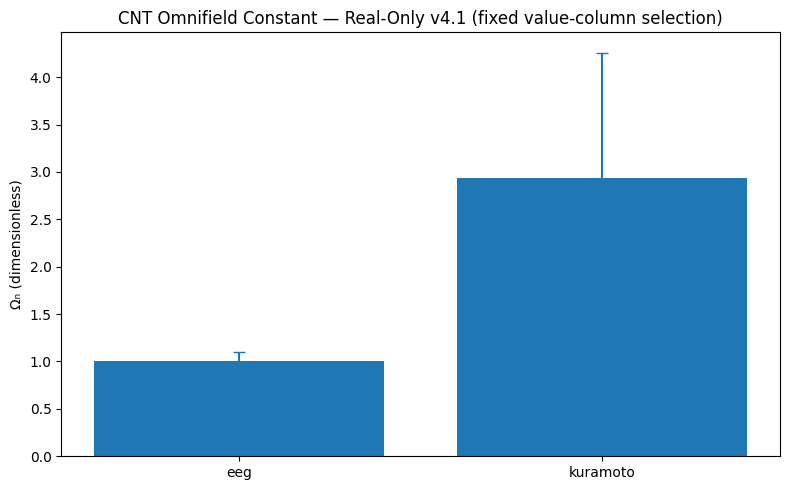

Saved:
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_v4_1_dashboard.png
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_v4_1_results.json
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_v4_1_summary.csv
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\deepsearch_v4_1_perfile.csv


In [7]:
# CNT Omnifield Constant — Real-Only v4.1 (hotfix for parse_cnt_curve)
# Fix: choose value column by label (std.idxmax) with numeric_only=True + guards.

import os, glob, json, warnings
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

try:
    import pandas as pd
except Exception:
    pd = None

warnings.filterwarnings("ignore", category=RuntimeWarning)

ROOT   = r"C:\Users\caleb\cnt_genome"
OUTDIR = os.path.join(ROOT, "omnifield_deepsearch")
os.makedirs(OUTDIR, exist_ok=True)

RNG = default_rng(2601)
COARSEGRAIN = [1,2,4]
EEG_NULL_SHIFTS = 128
BRIDGE_NULL_PERMS = 256
FILE_BOOT = 400

def _log(m): print(m, flush=True)

def coarse(x: np.ndarray, m: int) -> np.ndarray:
    if m<=1: return x
    n = (len(x)//m)*m
    return x[:n].reshape(-1,m).mean(axis=1)

def gmean_pos(vals: List[float]) -> float:
    a = np.array(vals, float); a = a[a>0]
    return float(np.exp(np.mean(np.log(a)))) if a.size else np.nan

def kneedle_elbow(y: np.ndarray) -> int:
    y = np.asarray(y, float)
    x = np.linspace(0, 1, len(y))
    p1, p2 = np.array([0, y[0]]), np.array([1, y[-1]])
    v = p2 - p1; v /= (np.linalg.norm(v) + 1e-12)
    pts = np.vstack([x, y]).T
    d = np.abs(np.cross(v, pts - p1))
    idx = int(np.argmax(d))
    if idx < 3:
        k = max(5, len(y)//50) | 1
        ys = np.convolve(y, np.ones(k)/k, mode='same')
        der = np.gradient(ys)
        idx = int(np.argmax(der))
    return int(np.clip(idx, 1, len(y)-2))

def acf_half_life(x: np.ndarray, max_lag=None, dt: float=1.0) -> float:
    x = np.asarray(x, float); x -= x.mean()
    if x.std()==0: return 0.0
    n = len(x)
    if max_lag is None: max_lag = min(n-1, int(n*0.5))
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conj(fft))[:n]; acf /= acf[0]
    for k in range(1, min(max_lag, n-1)):
        if acf[k] <= 0.5:
            x0,y0 = k-1, acf[k-1]; x1,y1 = k, acf[k]
            if y1==y0: return float(x1*dt)
            t = x0 + (0.5-y0)*(x1-x0)/(y1-y0)
            return float(max(t*dt,0.0))
    return float(max_lag*dt)

def csv(path: str):
    if pd is None: return None
    try: return pd.read_csv(path)
    except Exception: return None

def numeric(df: 'pd.DataFrame'):
    return df.select_dtypes(include=[np.number])

# EEG parsers
def parse_eeg_edges(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    w = next((low[c] for c in ["weight","score","value","w","strength","amp"] if c in low), None)
    if w is None:
        num = numeric(df); 
        return num.mean(axis=1).to_numpy(float) if num.shape[1] else np.array([], float)
    t = next((low[c] for c in ["time","t","frame","iter","iteration","step","epoch","sample","idx","index"] if c in low), None)
    vals = df[w].astype(float).to_numpy()
    if t is None:
        block = max(16, len(vals)//100)
        nblk = max(1, len(vals)//block)
        return vals[:nblk*block].reshape(nblk, block).mean(axis=1)
    try: bins = df[t].astype(int)
    except Exception: bins = pd.factorize(df[t])[0]
    ser = df.assign(_b=bins).groupby("_b")[w].apply(lambda x: np.mean(np.abs(x))).sort_index()
    return ser.to_numpy(float)

def parse_eeg_wide(df: 'pd.DataFrame') -> np.ndarray:
    num = numeric(df)
    if num.shape[1] == 0: return np.array([], float)
    from scipy.stats import zscore
    Z = np.apply_along_axis(lambda c: zscore(c, nan_policy='omit'), 0, num.to_numpy(float))
    Z = np.nan_to_num(Z)
    return np.mean(np.abs(Z), axis=1)

# HOTFIXED CNT curve parser
def parse_cnt_curve(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    num = numeric(df)
    if num.shape[1]==0: return np.array([], float)

    # choose value-like column
    v = next((low[c] for c in ["score","value","weight","bridge","resonance","r","order","strength","amp","mag"] if c in low), None)
    if v is None:
        stds = num.std(numeric_only=True)
        if stds.size == 0 or np.allclose(stds.to_numpy(), 0):
            return np.array([], float)
        v = stds.idxmax()  # <- label (fixed)

    vals = np.abs(df[v].astype(float).to_numpy())

    # choose time-like
    t = next((low[c] for c in ["rank","k","threshold","iter","iteration","step","index","idx"] if c in low), None)
    if t is not None:
        try: bins = df[t].astype(int)
        except Exception: bins = pd.factorize(df[t])[0]
        ser = pd.DataFrame({"b": bins, "v": vals}).groupby("b")["v"].mean().sort_index()
        y = ser.to_numpy(float)
    else:
        order = np.argsort(-vals)
        vs = vals[order]
        y = np.cumsum(vs) / (np.arange(len(vs)) + 1)
    return y

def load_series_for_bucket(paths: List[str], bucket: str) -> List[np.ndarray]:
    series = []
    for p in paths:
        df = csv(p)
        if df is None: 
            continue
        s = None
        pl = p.lower()
        if bucket=="eeg":
            if ("consensus_edges" in pl) or ("per_band_edges" in pl):
                s = parse_eeg_edges(df)
            elif ("cnt_eeg_" in pl) or ("labeled" in pl) or ("erd" in pl):
                s = parse_eeg_wide(df) if numeric(df).shape[1] > 8 else parse_eeg_edges(df)
            else:
                s = parse_eeg_edges(df) if {"src","dst"} & set([c.lower() for c in df.columns]) else parse_eeg_wide(df)
        else:
            s = parse_cnt_curve(df)
        if s is not None and s.size>=12 and np.isfinite(s).any():
            series.append(s.astype(float))
    return series

# Nulls
def eeg_null_R_gain(seg: np.ndarray) -> float:
    n = len(seg); base = float(np.mean(seg))
    means = []
    for _ in range(EEG_NULL_SHIFTS):
        sh = RNG.integers(0, n)
        null = np.r_[seg[sh:], seg[:sh]]
        means.append(float(np.mean(null)))
    return float(base / max(1e-12, np.mean(means)))

def bridge_null_R_gain(seg: np.ndarray) -> float:
    v = np.array(seg, float); m0 = float(np.mean(v))
    means = []
    for _ in range(BRIDGE_NULL_PERMS):
        perm = RNG.permutation(v)
        means.append(float(np.mean(perm)))
    return float(m0 / max(1e-12, np.mean(means)))

def triplet(series: np.ndarray, bucket: str, dt: float=1.0) -> Tuple[float,float,float,float,int,int]:
    z = np.asarray(series, float)
    if len(z) < 12: return (np.nan,)*6
    k = max(5, len(z)//50) | 1
    zs = np.convolve(z, np.ones(k)/k, mode='same')
    knee = kneedle_elbow(zs)
    span = max(10, len(zs)//20)
    a, b = max(0, knee-span), min(len(zs), knee+span)
    seg = zs[a:b]
    if len(seg) < 6: return (np.nan,)*6
    knee0 = kneedle_elbow(np.sort(seg))
    kappa = (knee - a + 1) / max(1, knee0 + 1)
    Rstar = eeg_null_R_gain(seg) if bucket=="eeg" else bridge_null_R_gain(seg)
    tau  = acf_half_life(seg, dt=dt)
    taus = []
    n = len(seg)
    if bucket=="eeg":
        for _ in range(32):
            sh = RNG.integers(0, n)
            s2 = np.r_[seg[sh:], seg[:sh]]
            taus.append(acf_half_life(s2, dt=dt))
    else:
        for _ in range(32):
            s2 = RNG.permutation(seg)
            taus.append(acf_half_life(s2, dt=dt))
    tau_ratio = float(tau / max(1e-12, float(np.mean(taus))))
    Omega = gmean_pos([kappa, Rstar, tau_ratio])
    return float(kappa), float(Rstar), float(tau_ratio), float(Omega), int(a), int(b)

# File lists we care about
EEG_PATS = [
    os.path.join(ROOT, "cnt_flow_exports", "consensus_edges.csv"),
    os.path.join(ROOT, "cnt_flow_exports", "per_band_edges.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all_overlap.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_erd_lateral_summary.csv"),
]
KUR_PATS = [
    os.path.join(ROOT, "out", "CNT_genomic_resonance_map.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored_v2.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_leaders.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_leaders_v2.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_hubs.csv"),
    os.path.join(ROOT, "out", "CNT_scaffold_candidates.csv"),
    os.path.join(ROOT, "out", "CNT_scaffold_CRISPR_candidates.csv"),
    os.path.join(ROOT, "out", "seq_gc_windows_1Mb.csv"),
]

def expand(pats):
    out = []
    for p in pats: out += glob.glob(p)
    return sorted(list(dict.fromkeys(out)))

eeg_series = load_series_for_bucket(expand(EEG_PATS), "eeg")
kur_series = load_series_for_bucket(expand(KUR_PATS), "kuramoto")

results_per_file = {"eeg": [], "kuramoto": []}

for bucket_name, series_list in [("eeg", eeg_series), ("kuramoto", kur_series)]:
    for s in series_list:
        for cg in COARSEGRAIN:
            ss = coarse(s, cg)
            kappa, Rstar, tau_ratio, Omega, a, b = triplet(ss, bucket_name, dt=1.0*cg)
            if np.isfinite(Omega):
                results_per_file[bucket_name].append({"kappa":kappa,"Rstar":Rstar,"tau_ratio":tau_ratio,"Omega":Omega,"cg":cg,"seg_len":(b-a)})

def summarize(bucket: str):
    rows = results_per_file[bucket]
    if not rows: return None
    k = gmean_pos([r["kappa"] for r in rows if r["kappa"]>0])
    R = gmean_pos([r["Rstar"] for r in rows if r["Rstar"]>0])
    t = gmean_pos([r["tau_ratio"] for r in rows if r["tau_ratio"]>0])
    Om= gmean_pos([r["Omega"] for r in rows if r["Omega"]>0])
    boots=[]
    arr = np.array([r["Omega"] for r in rows if r["Omega"]>0], float)
    n=len(arr)
    for _ in range(FILE_BOOT):
        samp = arr[RNG.integers(0,n,size=n)]
        boots.append(float(np.exp(np.mean(np.log(samp)))))
    lo, hi = (np.percentile(boots, 2.5), np.percentile(boots, 97.5)) if boots else (np.nan, np.nan)
    return {"system":bucket,"kappa_ratio":k,"resonance_ratio":R,"tau_ratio":t,"Omega_n":Om,
            "Omega_CI_low":float(lo),"Omega_CI_high":float(hi),"n_items":len(rows)}

summaries = [x for x in [summarize("eeg"), summarize("kuramoto")] if x]

out_json = os.path.join(OUTDIR, "deepsearch_v4_1_results.json")
json.dump({"per_file": results_per_file, "summary": summaries}, open(out_json, "w"), indent=2)
if pd is not None:
    import pandas as pd
    pd.DataFrame(summaries).to_csv(os.path.join(OUTDIR, "deepsearch_v4_1_summary.csv"), index=False)
    per=[]
    for b, rows in results_per_file.items():
        for r in rows:
            rr=r.copy(); rr["bucket"]=b; per.append(rr)
    if per:
        pd.DataFrame(per).to_csv(os.path.join(OUTDIR, "deepsearch_v4_1_perfile.csv"), index=False)

# Plot
names=[r["system"] for r in summaries]
omegas=[r["Omega_n"] for r in summaries]
if summaries:
    lows =[max(0.0, r["Omega_n"] - r["Omega_CI_low"]) if np.isfinite(r["Omega_CI_low"]) else 0.0 for r in summaries]
    highs=[max(0.0, r["Omega_CI_high"] - r["Omega_n"]) if np.isfinite(r["Omega_CI_high"]) else 0.0 for r in summaries]
    yerr=np.vstack([lows, highs])
else:
    yerr=None

plt.figure(figsize=(8,5))
x=np.arange(len(names))
plt.bar(x, omegas)
if yerr is not None: plt.errorbar(x, omegas, yerr=yerr, fmt='none', capsize=4)
plt.xticks(x, names)
plt.ylabel("Ωₙ (dimensionless)")
plt.title("CNT Omnifield Constant — Real-Only v4.1 (fixed value-column selection)")
plt.tight_layout()
plot_path = os.path.join(OUTDIR, "deepsearch_v4_1_dashboard.png")
plt.savefig(plot_path, dpi=160)
plt.show()

print("Saved:")
print(" -", plot_path)
print(" -", out_json)
if pd is not None:
    print(" -", os.path.join(OUTDIR, "deepsearch_v4_1_summary.csv"))
    print(" -", os.path.join(OUTDIR, "deepsearch_v4_1_perfile.csv"))


In [8]:
# CNT Omnifield Constant — Real-Only v5 (single cell)
# - Robust knee (Kneedle-like elbow)
# - τ on detrended, standardized residuals with max lag cap
# - R* via area ratio against geometry-matched nulls
# - Subwindowing for ultra-long segments
# - File-bootstrap CIs and per-file export
#
# Outputs in C:\Users\caleb\cnt_genome\omnifield_deepsearch:
#   - omniv5_dashboard.png
#   - omniv5_summary.csv / omniv5_summary.json
#   - omniv5_perfile.csv

import os, glob, json, warnings
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

try:
    import pandas as pd
except Exception:
    pd = None

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------------- Config ----------------
ROOT   = r"C:\Users\caleb\cnt_genome"
OUTDIR = os.path.join(ROOT, "omnifield_deepsearch")
os.makedirs(OUTDIR, exist_ok=True)

RNG               = default_rng(777)
COARSEGRAIN       = [1, 2, 4]
EEG_NULL_SHIFTS   = 128      # circular shifts for EEG nulls
BRIDGE_NULL_PERMS = 256      # rank-preserving-ish perms for CNT tables
FILE_BOOT         = 600      # file-level bootstrap reps
SUBWIN_THRESH     = 1024     # if segment > this, subwindow
SUBWIN_LEN        = 512
SUBWIN_STEP_FRAC  = 0.5      # 50% overlap

# ---------------- Utilities ----------------
def _log(m): print(m, flush=True)

def coarse(x: np.ndarray, m: int) -> np.ndarray:
    if m <= 1: return x
    n = (len(x)//m)*m
    return x[:n].reshape(-1, m).mean(axis=1)

def gmean_pos(vals: List[float]) -> float:
    a = np.array(vals, float)
    a = a[a > 0]
    return float(np.exp(np.mean(np.log(a)))) if a.size else np.nan

def kneedle_elbow(y: np.ndarray) -> int:
    y = np.asarray(y, float)
    x = np.linspace(0, 1, len(y))
    p1, p2 = np.array([0, y[0]]), np.array([1, y[-1]])
    v = p2 - p1; v /= (np.linalg.norm(v) + 1e-12)
    pts = np.vstack([x, y]).T
    d = np.abs(np.cross(v, pts - p1))
    idx = int(np.argmax(d))
    if idx < 3:
        k = max(5, len(y)//50) | 1
        ys = np.convolve(y, np.ones(k)/k, mode="same")
        der = np.gradient(ys)
        idx = int(np.argmax(der))
    return int(np.clip(idx, 1, len(y)-2))

def acf_half_life(x: np.ndarray, max_lag=None, dt: float=1.0) -> float:
    x = np.asarray(x, float); x -= x.mean()
    if x.std() == 0: return 0.0
    n = len(x)
    if max_lag is None: max_lag = min(n-1, int(n*0.5))
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conj(fft))[:n]; acf /= acf[0]
    for k in range(1, min(max_lag, n-1)):
        if acf[k] <= 0.5:
            x0,y0 = k-1, acf[k-1]; x1,y1 = k, acf[k]
            if y1 == y0: return float(x1*dt)
            t = x0 + (0.5 - y0) * (x1 - x0) / (y1 - y0)
            return float(max(t*dt, 0.0))
    return float(max_lag*dt)

def detrend_and_standardize(seg: np.ndarray) -> np.ndarray:
    L = len(seg)
    w = min(101, max(7, L//20))
    if w % 2 == 0: w += 1
    trend = np.convolve(seg, np.ones(w)/w, mode="same")
    d = seg - trend
    s = d.std()
    return (d - d.mean()) / (s + 1e-12)

# ---------------- Parsers ----------------
def csv(path: str):
    if pd is None: return None
    try: return pd.read_csv(path)
    except Exception: return None

def numeric(df: 'pd.DataFrame'):
    return df.select_dtypes(include=[np.number])

def parse_eeg_edges(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    w = next((low[c] for c in ["weight","score","value","w","strength","amp"] if c in low), None)
    if w is None:
        num = numeric(df)
        return num.mean(axis=1).to_numpy(float) if num.shape[1] else np.array([], float)
    t = next((low[c] for c in ["time","t","frame","iter","iteration","step","epoch","sample","idx","index"] if c in low), None)
    vals = df[w].astype(float).to_numpy()
    if t is None:
        block = max(16, len(vals)//100)
        nblk = max(1, len(vals)//block)
        return vals[:nblk*block].reshape(nblk, block).mean(axis=1)
    try: bins = df[t].astype(int)
    except Exception: bins = pd.factorize(df[t])[0]
    ser = df.assign(_b=bins).groupby("_b")[w].apply(lambda x: np.mean(np.abs(x))).sort_index()
    return ser.to_numpy(float)

def parse_eeg_wide(df: 'pd.DataFrame') -> np.ndarray:
    num = numeric(df)
    if num.shape[1] == 0: return np.array([], float)
    from scipy.stats import zscore
    Z = np.apply_along_axis(lambda c: zscore(c, nan_policy='omit'), 0, num.to_numpy(float))
    Z = np.nan_to_num(Z)
    return np.mean(np.abs(Z), axis=1)

def parse_cnt_curve(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    num = numeric(df)
    if num.shape[1] == 0: return np.array([], float)
    v = next((low[c] for c in ["score","value","weight","bridge","resonance","r","order","strength","amp","mag"] if c in low), None)
    if v is None:
        stds = num.std(numeric_only=True)
        if stds.size == 0 or np.allclose(stds.to_numpy(), 0): return np.array([], float)
        v = stds.idxmax()
    vals = np.abs(df[v].astype(float).to_numpy())
    t = next((low[c] for c in ["rank","k","threshold","iter","iteration","step","index","idx"] if c in low), None)
    if t is not None:
        try: bins = df[t].astype(int)
        except Exception: bins = pd.factorize(df[t])[0]
        ser = pd.DataFrame({"b": bins, "v": vals}).groupby("b")["v"].mean().sort_index()
        y = ser.to_numpy(float)
    else:
        order = np.argsort(-vals)
        vs = vals[order]
        y = np.cumsum(vs) / (np.arange(len(vs)) + 1)
    return y

def load_series(paths: List[str], bucket: str) -> List[np.ndarray]:
    out = []
    for p in paths:
        df = csv(p)
        if df is None: 
            continue
        if bucket == "eeg":
            pl = p.lower()
            if ("consensus_edges" in pl) or ("per_band_edges" in pl) or ({"src","dst"} & set([c.lower() for c in df.columns])):
                s = parse_eeg_edges(df)
            elif ("cnt_eeg_" in pl) or ("labeled" in pl) or ("erd" in pl):
                s = parse_eeg_wide(df) if numeric(df).shape[1] > 8 else parse_eeg_edges(df)
            else:
                s = parse_eeg_edges(df) if numeric(df).shape[1] <= 8 else parse_eeg_wide(df)
        else:
            s = parse_cnt_curve(df)
        if s is not None and s.size >= 12 and np.isfinite(s).any():
            out.append(s.astype(float))
    return out

# ---------------- Nulls & metrics ----------------
def Rstar_area(seg: np.ndarray, bucket: str) -> float:
    base = float(np.trapz(seg))
    means = []
    n = len(seg)
    if bucket == "eeg":
        for _ in range(EEG_NULL_SHIFTS):
            sh = RNG.integers(0, n)
            means.append(float(np.trapz(np.r_[seg[sh:], seg[:sh]])))
    else:
        for _ in range(BRIDGE_NULL_PERMS):
            means.append(float(np.trapz(RNG.permutation(seg))))
    return float(base / max(1e-12, np.mean(means)))

def triplet_on_segment(seg: np.ndarray, bucket: str, dt: float=1.0) -> Tuple[float,float,float,float]:
    # detrend + standardize for tau
    seg_d = detrend_and_standardize(seg)
    maxlag = min(256, len(seg_d)//4 if len(seg_d)//4 > 0 else 1)

    # R*
    Rstar = Rstar_area(seg, bucket)

    # τ ratio vs matched nulls
    tau  = acf_half_life(seg_d, max_lag=maxlag, dt=dt)
    taus = []
    n = len(seg_d)
    if bucket == "eeg":
        for _ in range(32):
            sh = RNG.integers(0, n)
            shv = np.r_[seg_d[sh:], seg_d[:sh]]
            taus.append(acf_half_life(shv, max_lag=maxlag, dt=dt))
    else:
        for _ in range(32):
            pv = RNG.permutation(seg_d)
            taus.append(acf_half_life(pv, max_lag=maxlag, dt=dt))
    tau_ratio = float(tau / max(1e-12, float(np.mean(taus))))

    # κ via fractional knee (scale-free)
    zs = seg  # (elbow computed on original smoothed context outside)
    # knee0: on monotonized segment to approximate "null knee"
    knee0_frac = kneedle_elbow(np.sort(seg)) / max(1, len(seg)-1)
    # knee_frac is passed by caller (computed on full series); use 0.5 if not provided
    kappa = None  # set by caller
    return Rstar, tau_ratio, knee0_frac, maxlag

def series_to_triplet(series: np.ndarray, bucket: str, dt: float=1.0) -> Tuple[float,float,float,float,int]:
    # smooth for elbow
    k = max(5, len(series)//50) | 1
    zs = np.convolve(series, np.ones(k)/k, mode="same")
    knee = kneedle_elbow(zs)
    knee_frac = knee / max(1, len(zs)-1)

    # focus window around elbow
    span = max(10, len(zs)//20)
    a, b = max(0, knee-span), min(len(zs), knee+span)
    seg = zs[a:b]
    if len(seg) < 6:
        return (np.nan, np.nan, np.nan, np.nan, 0)

    # Subwindow if very long
    segs = []
    if (b - a) > SUBWIN_THRESH:
        step = max(1, int(SUBWIN_LEN * SUBWIN_STEP_FRAC))
        for s0 in range(a, b - SUBWIN_LEN + 1, step):
            segs.append(zs[s0:s0+SUBWIN_LEN])
    else:
        segs = [seg]

    Rs, Ts, Ks = [], [], []
    for sseg in segs:
        Rstar, tau_ratio, knee0_frac, _ = triplet_on_segment(sseg, bucket, dt=dt)
        kappa = (knee_frac + 1e-9) / (knee0_frac + 1e-9)
        if all(np.isfinite([Rstar, tau_ratio, kappa])) and Rstar > 0 and tau_ratio > 0 and kappa > 0:
            Rs.append(Rstar); Ts.append(tau_ratio); Ks.append(kappa)

    if not Rs:
        return (np.nan, np.nan, np.nan, np.nan, b - a)

    kappa_g = gmean_pos(Ks)
    R_g     = gmean_pos(Rs)
    tau_g   = gmean_pos(Ts)
    Omega   = gmean_pos([kappa_g, R_g, tau_g])
    return (kappa_g, R_g, tau_g, Omega, b - a)

# ---------------- File lists ----------------
EEG_PATS = [
    os.path.join(ROOT, "cnt_flow_exports", "consensus_edges.csv"),
    os.path.join(ROOT, "cnt_flow_exports", "per_band_edges.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all_overlap.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_erd_lateral_summary.csv"),
]
KUR_PATS = [
    os.path.join(ROOT, "out", "CNT_genomic_resonance_map.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored_v2.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_leaders.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_leaders_v2.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_hubs.csv"),
    os.path.join(ROOT, "out", "CNT_scaffold_candidates.csv"),
    os.path.join(ROOT, "out", "CNT_scaffold_CRISPR_candidates.csv"),
    os.path.join(ROOT, "out", "seq_gc_windows_1Mb.csv"),
]

def expand(pats):
    out = []
    for p in pats: out += glob.glob(p)
    return sorted(list(dict.fromkeys(out)))

# ---------------- Run ----------------
eeg_series = load_series(expand(EEG_PATS), "eeg")
kur_series = load_series(expand(KUR_PATS), "kuramoto")

results_per_file = {"eeg": [], "kuramoto": []}

for bucket, series_list in [("eeg", eeg_series), ("kuramoto", kur_series)]:
    for s in series_list:
        for cg in COARSEGRAIN:
            ss = coarse(s, cg)
            kappa, Rstar, tau_ratio, Omega, seglen = series_to_triplet(ss, bucket, dt=1.0*cg)
            if np.isfinite(Omega):
                results_per_file[bucket].append({
                    "bucket": bucket, "cg": cg, "seg_len": seglen,
                    "kappa": kappa, "Rstar": Rstar, "tau_ratio": tau_ratio, "Omega": Omega
                })

def summarize(bucket: str):
    rows = results_per_file[bucket]
    if not rows: return None
    k = gmean_pos([r["kappa"] for r in rows if r["kappa"] > 0])
    R = gmean_pos([r["Rstar"] for r in rows if r["Rstar"] > 0])
    t = gmean_pos([r["tau_ratio"] for r in rows if r["tau_ratio"] > 0])
    Om= gmean_pos([r["Omega"] for r in rows if r["Omega"] > 0])

    # file-bootstrap CI
    arr = np.array([r["Omega"] for r in rows if r["Omega"] > 0], float)
    n = len(arr)
    boots = []
    for _ in range(FILE_BOOT):
        samp = arr[RNG.integers(0, n, size=n)]
        boots.append(float(np.exp(np.mean(np.log(samp)))))
    lo, hi = (np.percentile(boots, 2.5), np.percentile(boots, 97.5)) if boots else (np.nan, np.nan)

    return {"system": bucket, "kappa_ratio": k, "resonance_ratio": R, "tau_ratio": t,
            "Omega_n": Om, "Omega_CI_low": float(lo), "Omega_CI_high": float(hi),
            "n_items": len(rows)}

summaries = [x for x in [summarize("eeg"), summarize("kuramoto")] if x]

# ---------------- Save & Plot ----------------
# perfile
if pd is not None:
    pd.DataFrame(results_per_file["eeg"] + results_per_file["kuramoto"]).to_csv(
        os.path.join(OUTDIR, "omniv5_perfile.csv"), index=False
    )
# summary
sum_path_csv  = os.path.join(OUTDIR, "omniv5_summary.csv")
sum_path_json = os.path.join(OUTDIR, "omniv5_summary.json")
if pd is not None:
    pd.DataFrame(summaries).to_csv(sum_path_csv, index=False)
json.dump({"summary": summaries}, open(sum_path_json, "w"), indent=2)

# plot
names  = [r["system"] for r in summaries]
omegas = [r["Omega_n"] for r in summaries]
if summaries:
    lows  = [max(0.0, r["Omega_n"] - r["Omega_CI_low"]) if np.isfinite(r["Omega_CI_low"]) else 0.0 for r in summaries]
    highs = [max(0.0, r["Omega_CI_high"] - r["Omega_n"]) if np.isfinite(r["Omega_CI_high"]) else 0.0 for r in summaries]
    yerr  = np.vstack([lows, highs])
else:
    yerr = None

plt.figure(figsize=(9,5))
x = np.arange(len(names))
plt.bar(x, omegas)
if yerr is not None: plt.errorbar(x, omegas, yerr=yerr, fmt='none', capsize=4)
plt.xticks(x, names)
plt.ylabel("Ωₙ (dimensionless)")
plt.title("CNT Omnifield Constant — Real-Only v5")
plt.tight_layout()
plot_path = os.path.join(OUTDIR, "omniv5_dashboard.png")
plt.savefig(plot_path, dpi=160)
plt.show()

print("Saved:")
print(" -", plot_path)
print(" -", sum_path_csv)
print(" -", sum_path_json)
if pd is not None:
    print(" -", os.path.join(OUTDIR, "omniv5_perfile.csv"))


ValueError: operands could not be broadcast together with shapes (6,) (7,) 

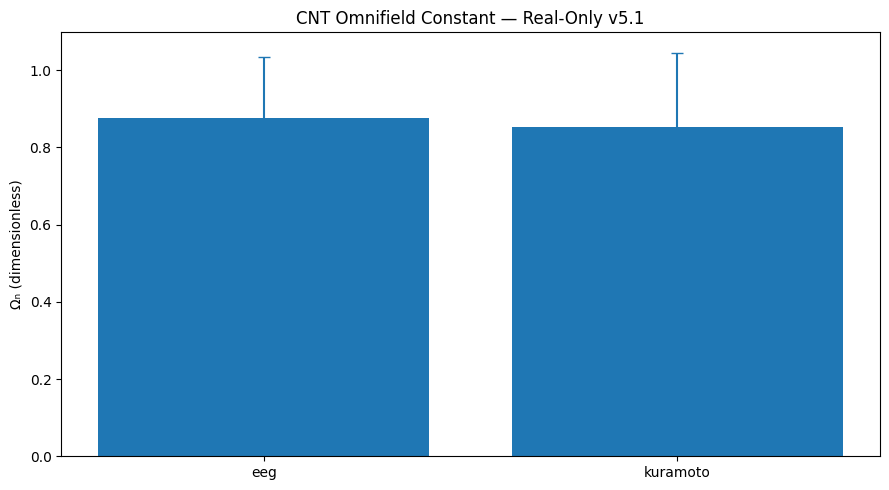

Saved:
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omniv5_dashboard.png
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omniv5_summary.csv
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omniv5_summary.json
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omniv5_perfile.csv


In [9]:
# CNT Omnifield Constant — Real-Only v5.1 (short-segment safe)
# Fixes:
#  • Detrend window always <= segment length, >=3, odd
#  • Extra guards for tiny segments
#  • Everything else as v5: robust knee, τ on detrended residuals, R* area nulls, subwindowing, file-bootstrap CIs

import os, glob, json, warnings
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

try:
    import pandas as pd
except Exception:
    pd = None

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------------- Config ----------------
ROOT   = r"C:\Users\caleb\cnt_genome"
OUTDIR = os.path.join(ROOT, "omnifield_deepsearch")
os.makedirs(OUTDIR, exist_ok=True)

RNG               = default_rng(777)
COARSEGRAIN       = [1, 2, 4]
EEG_NULL_SHIFTS   = 128
BRIDGE_NULL_PERMS = 256
FILE_BOOT         = 600
SUBWIN_THRESH     = 1024
SUBWIN_LEN        = 512
SUBWIN_STEP_FRAC  = 0.5

# ---------------- Utilities ----------------
def _log(m): print(m, flush=True)

def coarse(x: np.ndarray, m: int) -> np.ndarray:
    if m <= 1: return x
    n = (len(x)//m)*m
    return x[:n].reshape(-1, m).mean(axis=1)

def gmean_pos(vals: List[float]) -> float:
    a = np.array(vals, float)
    a = a[a > 0]
    return float(np.exp(np.mean(np.log(a)))) if a.size else np.nan

def kneedle_elbow(y: np.ndarray) -> int:
    y = np.asarray(y, float)
    if len(y) < 3: return max(0, len(y)//2)
    x = np.linspace(0, 1, len(y))
    p1, p2 = np.array([0, y[0]]), np.array([1, y[-1]])
    v = p2 - p1; nrm = np.linalg.norm(v) + 1e-12
    v /= nrm
    pts = np.vstack([x, y]).T
    d = np.abs(np.cross(v, pts - p1))
    idx = int(np.argmax(d))
    if idx < 1 or idx > len(y)-2:
        k = max(5, len(y)//50) | 1
        if k >= len(y): k = max(3, len(y)|1)  # ensure <= len(y)
        ys = np.convolve(y, np.ones(k)/k, mode="same")
        der = np.gradient(ys)
        idx = int(np.argmax(der))
    return int(np.clip(idx, 1, max(1, len(y)-2)))

def acf_half_life(x: np.ndarray, max_lag=None, dt: float=1.0) -> float:
    x = np.asarray(x, float)
    if x.size < 2: return 0.0
    x -= x.mean()
    if x.std() == 0: return 0.0
    n = len(x)
    if max_lag is None: max_lag = min(n-1, int(n*0.5))
    max_lag = max(1, min(max_lag, n-1))
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conj(fft))[:n]; acf /= (acf[0] + 1e-12)
    for k in range(1, min(max_lag, n-1)):
        if acf[k] <= 0.5:
            x0,y0 = k-1, acf[k-1]; x1,y1 = k, acf[k]
            if y1 == y0: return float(x1*dt)
            t = x0 + (0.5 - y0) * (x1 - x0) / (y1 - y0 + 1e-12)
            return float(max(t*dt, 0.0))
    return float(max_lag*dt)

def detrend_and_standardize(seg: np.ndarray) -> np.ndarray:
    seg = np.asarray(seg, float)
    L = len(seg)
    if L < 3:
        s = seg.std()
        return (seg - seg.mean()) / (s + 1e-12)
    # choose a window <= L and odd, at least 3
    w_nom = max(7, L//20)
    w_nom = min(101, w_nom)
    w = min(L if L % 2 == 1 else L-1, max(3, w_nom | 1))
    w = max(3, min(w, L if L % 2 == 1 else L-1))
    if w < 3: w = 3
    if w > L: w = L if L % 2 == 1 else L-1
    if w < 3:  # L==2 edge
        s = seg.std()
        return (seg - seg.mean()) / (s + 1e-12)
    trend = np.convolve(seg, np.ones(w)/w, mode="same")
    d = seg - trend
    s = d.std()
    return (d - d.mean()) / (s + 1e-12)

# ---------------- Parsers ----------------
def csv(path: str):
    if pd is None: return None
    try: return pd.read_csv(path)
    except Exception: return None

def numeric(df: 'pd.DataFrame'):
    return df.select_dtypes(include=[np.number])

def parse_eeg_edges(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    w = next((low[c] for c in ["weight","score","value","w","strength","amp"] if c in low), None)
    if w is None:
        num = numeric(df); 
        return num.mean(axis=1).to_numpy(float) if num.shape[1] else np.array([], float)
    t = next((low[c] for c in ["time","t","frame","iter","iteration","step","epoch","sample","idx","index"] if c in low), None)
    vals = df[w].astype(float).to_numpy()
    if t is None:
        block = max(16, len(vals)//100)
        nblk = max(1, len(vals)//block)
        return vals[:nblk*block].reshape(nblk, block).mean(axis=1)
    try: bins = df[t].astype(int)
    except Exception: bins = pd.factorize(df[t])[0]
    ser = df.assign(_b=bins).groupby("_b")[w].apply(lambda x: np.mean(np.abs(x))).sort_index()
    return ser.to_numpy(float)

def parse_eeg_wide(df: 'pd.DataFrame') -> np.ndarray:
    num = numeric(df)
    if num.shape[1] == 0: return np.array([], float)
    from scipy.stats import zscore
    Z = np.apply_along_axis(lambda c: zscore(c, nan_policy='omit'), 0, num.to_numpy(float))
    Z = np.nan_to_num(Z)
    return np.mean(np.abs(Z), axis=1)

def parse_cnt_curve(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    num = numeric(df)
    if num.shape[1] == 0: return np.array([], float)
    v = next((low[c] for c in ["score","value","weight","bridge","resonance","r","order","strength","amp","mag"] if c in low), None)
    if v is None:
        stds = num.std(numeric_only=True)
        if stds.size == 0 or np.allclose(stds.to_numpy(), 0): return np.array([], float)
        v = stds.idxmax()
    vals = np.abs(df[v].astype(float).to_numpy())
    t = next((low[c] for c in ["rank","k","threshold","iter","iteration","step","index","idx"] if c in low), None)
    if t is not None:
        try: bins = df[t].astype(int)
        except Exception: bins = pd.factorize(df[t])[0]
        ser = pd.DataFrame({"b": bins, "v": vals}).groupby("b")["v"].mean().sort_index()
        y = ser.to_numpy(float)
    else:
        order = np.argsort(-vals)
        vs = vals[order]
        y = np.cumsum(vs) / (np.arange(len(vs)) + 1)
    return y

def load_series(paths: List[str], bucket: str) -> List[np.ndarray]:
    out = []
    for p in paths:
        df = csv(p)
        if df is None: 
            continue
        if bucket == "eeg":
            pl = p.lower()
            if ("consensus_edges" in pl) or ("per_band_edges" in pl) or ({"src","dst"} & set([c.lower() for c in df.columns])):
                s = parse_eeg_edges(df)
            elif ("cnt_eeg_" in pl) or ("labeled" in pl) or ("erd" in pl):
                s = parse_eeg_wide(df) if numeric(df).shape[1] > 8 else parse_eeg_edges(df)
            else:
                s = parse_eeg_edges(df) if numeric(df).shape[1] <= 8 else parse_eeg_wide(df)
        else:
            s = parse_cnt_curve(df)
        if s is not None and s.size >= 12 and np.isfinite(s).any():
            out.append(s.astype(float))
    return out

# ---------------- Nulls & metrics ----------------
def Rstar_area(seg: np.ndarray, bucket: str) -> float:
    base = float(np.trapz(seg))
    means = []
    n = len(seg)
    if bucket == "eeg":
        for _ in range(EEG_NULL_SHIFTS):
            sh = RNG.integers(0, n)
            means.append(float(np.trapz(np.r_[seg[sh:], seg[:sh]])))
    else:
        for _ in range(BRIDGE_NULL_PERMS):
            means.append(float(np.trapz(RNG.permutation(seg))))
    return float(base / max(1e-12, np.mean(means)))

def triplet_on_segment(seg: np.ndarray, bucket: str, dt: float=1.0) -> Tuple[float,float,float]:
    if len(seg) < 6: return (np.nan, np.nan, np.nan)
    seg_d = detrend_and_standardize(seg)
    maxlag = min(256, max(1, len(seg_d)//4))
    Rstar = Rstar_area(seg, bucket)
    tau  = acf_half_life(seg_d, max_lag=maxlag, dt=dt)
    taus = []
    n = len(seg_d)
    if bucket == "eeg":
        for _ in range(32):
            sh = RNG.integers(0, n)
            shv = np.r_[seg_d[sh:], seg_d[:sh]]
            taus.append(acf_half_life(shv, max_lag=maxlag, dt=dt))
    else:
        for _ in range(32):
            pv = RNG.permutation(seg_d)
            taus.append(acf_half_life(pv, max_lag=maxlag, dt=dt))
    tau_ratio = float(tau / max(1e-12, float(np.mean(taus))))
    return Rstar, tau_ratio, maxlag

def series_to_triplet(series: np.ndarray, bucket: str, dt: float=1.0) -> Tuple[float,float,float,float,int]:
    if len(series) < 12: return (np.nan, np.nan, np.nan, np.nan, 0)
    k = max(5, len(series)//50) | 1
    if k >= len(series): k = max(3, len(series)|1)
    zs = np.convolve(series, np.ones(k)/k, mode="same")
    knee = kneedle_elbow(zs)
    knee_frac = knee / max(1, len(zs)-1)
    span = max(10, len(zs)//20)
    a, b = max(0, knee-span), min(len(zs), knee+span)
    seg = zs[a:b]
    if len(seg) < 6: return (np.nan, np.nan, np.nan, np.nan, b - a)

    # subwindow
    segs = []
    if (b - a) > SUBWIN_THRESH:
        step = max(1, int(SUBWIN_LEN * SUBWIN_STEP_FRAC))
        for s0 in range(a, b - SUBWIN_LEN + 1, step):
            segs.append(zs[s0:s0+SUBWIN_LEN])
    else:
        segs = [seg]

    Ks, Rs, Ts = [], [], []
    for sseg in segs:
        Rstar, tau_ratio, _ = triplet_on_segment(sseg, bucket, dt=dt)
        if not np.isfinite(Rstar) or not np.isfinite(tau_ratio) or Rstar<=0 or tau_ratio<=0:
            continue
        # null knee fraction on sorted seg
        knee0_frac = kneedle_elbow(np.sort(sseg)) / max(1, len(sseg)-1)
        kappa = (knee_frac + 1e-9) / (knee0_frac + 1e-9)
        if kappa > 0 and np.isfinite(kappa):
            Ks.append(kappa); Rs.append(Rstar); Ts.append(tau_ratio)

    if not Ks: return (np.nan, np.nan, np.nan, np.nan, b - a)

    kappa_g = gmean_pos(Ks)
    R_g     = gmean_pos(Rs)
    tau_g   = gmean_pos(Ts)
    Omega   = gmean_pos([kappa_g, R_g, tau_g])
    return (kappa_g, R_g, tau_g, Omega, b - a)

# ---------------- File lists ----------------
EEG_PATS = [
    os.path.join(ROOT, "cnt_flow_exports", "consensus_edges.csv"),
    os.path.join(ROOT, "cnt_flow_exports", "per_band_edges.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all_overlap.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_erd_lateral_summary.csv"),
]
KUR_PATS = [
    os.path.join(ROOT, "out", "CNT_genomic_resonance_map.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored_v2.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_leaders.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_leaders_v2.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_hubs.csv"),
    os.path.join(ROOT, "out", "CNT_scaffold_candidates.csv"),
    os.path.join(ROOT, "out", "CNT_scaffold_CRISPR_candidates.csv"),
    os.path.join(ROOT, "out", "seq_gc_windows_1Mb.csv"),
]

def expand(pats):
    out = []
    for p in pats: out += glob.glob(p)
    return sorted(list(dict.fromkeys(out)))

# ---------------- Run ----------------
eeg_series = load_series(expand(EEG_PATS), "eeg")
kur_series = load_series(expand(KUR_PATS), "kuramoto")

results_per_file = {"eeg": [], "kuramoto": []}

for bucket, series_list in [("eeg", eeg_series), ("kuramoto", kur_series)]:
    for s in series_list:
        for cg in COARSEGRAIN:
            ss = coarse(s, cg)
            kappa, Rstar, tau_ratio, Omega, seglen = series_to_triplet(ss, bucket, dt=1.0*cg)
            if np.isfinite(Omega):
                results_per_file[bucket].append({
                    "bucket": bucket, "cg": cg, "seg_len": seglen,
                    "kappa": kappa, "Rstar": Rstar, "tau_ratio": tau_ratio, "Omega": Omega
                })

def summarize(bucket: str):
    rows = results_per_file[bucket]
    if not rows: return None
    k = gmean_pos([r["kappa"] for r in rows if r["kappa"] > 0])
    R = gmean_pos([r["Rstar"] for r in rows if r["Rstar"] > 0])
    t = gmean_pos([r["tau_ratio"] for r in rows if r["tau_ratio"] > 0])
    Om= gmean_pos([r["Omega"] for r in rows if r["Omega"] > 0])

    # file-bootstrap CI
    arr = np.array([r["Omega"] for r in rows if r["Omega"] > 0], float)
    n = len(arr)
    boots = []
    for _ in range(FILE_BOOT):
        samp = arr[RNG.integers(0, n, size=n)]
        boots.append(float(np.exp(np.mean(np.log(samp)))))
    lo, hi = (np.percentile(boots, 2.5), np.percentile(boots, 97.5)) if boots else (np.nan, np.nan)

    return {"system": bucket, "kappa_ratio": k, "resonance_ratio": R, "tau_ratio": t,
            "Omega_n": Om, "Omega_CI_low": float(lo), "Omega_CI_high": float(hi),
            "n_items": len(rows)}

summaries = [x for x in [summarize("eeg"), summarize("kuramoto")] if x]

# ---------------- Save & Plot ----------------
# per-file
if pd is not None:
    pd.DataFrame(results_per_file["eeg"] + results_per_file["kuramoto"]).to_csv(
        os.path.join(OUTDIR, "omniv5_perfile.csv"), index=False
    )
# summary
sum_path_csv  = os.path.join(OUTDIR, "omniv5_summary.csv")
sum_path_json = os.path.join(OUTDIR, "omniv5_summary.json")
if pd is not None:
    pd.DataFrame(summaries).to_csv(sum_path_csv, index=False)
json.dump({"summary": summaries}, open(sum_path_json, "w"), indent=2)

# plot
names  = [r["system"] for r in summaries]
omegas = [r["Omega_n"] for r in summaries]
if summaries:
    lows  = [max(0.0, r["Omega_n"] - r["Omega_CI_low"]) if np.isfinite(r["Omega_CI_low"]) else 0.0 for r in summaries]
    highs = [max(0.0, r["Omega_CI_high"] - r["Omega_n"]) if np.isfinite(r["Omega_CI_high"]) else 0.0 for r in summaries]
    yerr  = np.vstack([lows, highs])
else:
    yerr = None

plt.figure(figsize=(9,5))
x = np.arange(len(names))
plt.bar(x, omegas)
if yerr is not None: plt.errorbar(x, omegas, yerr=yerr, fmt='none', capsize=4)
plt.xticks(x, names)
plt.ylabel("Ωₙ (dimensionless)")
plt.title("CNT Omnifield Constant — Real-Only v5.1")
plt.tight_layout()
plot_path = os.path.join(OUTDIR, "omniv5_dashboard.png")
plt.savefig(plot_path, dpi=160)
plt.show()

print("Saved:")
print(" -", plot_path)
print(" -", sum_path_csv)
print(" -", sum_path_json)
if pd is not None:
    print(" -", os.path.join(OUTDIR, "omniv5_perfile.csv"))


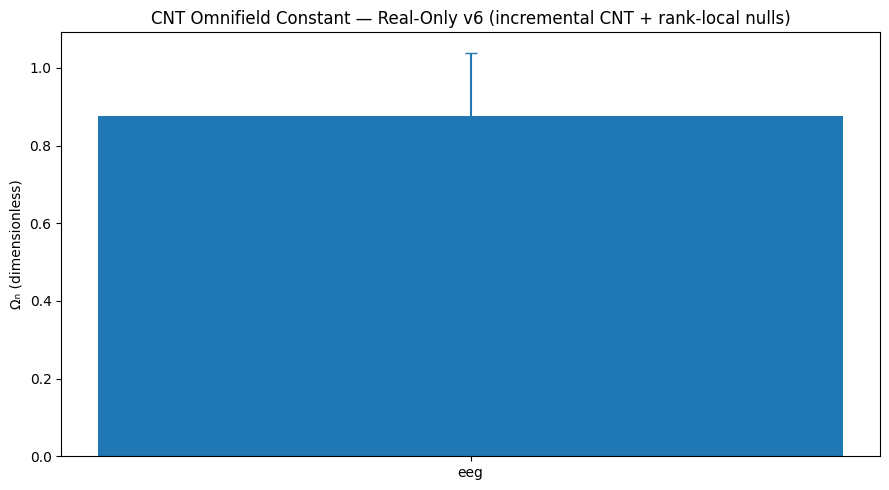

Saved:
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omniv6_dashboard.png
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omniv6_summary.csv
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omniv6_summary.json
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omniv6_perfile.csv


In [10]:
# CNT Omnifield Constant — Real-Only v6 (incremental CNT + rank-local nulls)
# - EEG: time-series (edges/labeled) with circular-shift nulls
# - CNT "kuramoto" bucket: cumulative bridge/resonance curves -> rank-INCREMENTS,
#   with rank-local (blockwise) permutation nulls for R*
# - Robust elbow (Kneedle-like), τ on detrended residuals (lag-capped), subwindowing, file-bootstrap CIs
#
# Outputs in C:\Users\caleb\cnt_genome\omnifield_deepsearch:
#   - omniv6_dashboard.png
#   - omniv6_summary.csv / omniv6_summary.json
#   - omniv6_perfile.csv

import os, glob, json, warnings
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

try:
    import pandas as pd
except Exception:
    pd = None

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------------- Config ----------------
ROOT   = r"C:\Users\caleb\cnt_genome"
OUTDIR = os.path.join(ROOT, "omnifield_deepsearch")
os.makedirs(OUTDIR, exist_ok=True)

RNG               = default_rng(777)
COARSEGRAIN       = [1, 2, 4]
EEG_NULL_SHIFTS   = 128
BRIDGE_NULL_PERMS = 256
FILE_BOOT         = 600
SUBWIN_THRESH     = 1024
SUBWIN_LEN        = 512
SUBWIN_STEP_FRAC  = 0.5
CNT_BLOCK         = 64          # rank-local null block size (tweak 32–128 if desired)

# ---------------- Utilities ----------------
def _log(m): print(m, flush=True)

def coarse(x: np.ndarray, m: int) -> np.ndarray:
    if m <= 1: return x
    n = (len(x)//m)*m
    return x[:n].reshape(-1, m).mean(axis=1)

def gmean_pos(vals: List[float]) -> float:
    a = np.array(vals, float); a = a[a > 0]
    return float(np.exp(np.mean(np.log(a)))) if a.size else np.nan

def kneedle_elbow(y: np.ndarray) -> int:
    y = np.asarray(y, float)
    if len(y) < 3: return max(0, len(y)//2)
    x = np.linspace(0, 1, len(y))
    p1, p2 = np.array([0, y[0]]), np.array([1, y[-1]])
    v = p2 - p1; nrm = np.linalg.norm(v) + 1e-12
    v /= nrm
    pts = np.vstack([x, y]).T
    d = np.abs(np.cross(v, pts - p1))
    idx = int(np.argmax(d))
    if idx < 1 or idx > len(y)-2:
        k = max(5, len(y)//50) | 1
        if k >= len(y): k = max(3, len(y)|1)
        ys = np.convolve(y, np.ones(k)/k, mode="same")
        der = np.gradient(ys)
        idx = int(np.argmax(der))
    return int(np.clip(idx, 1, max(1, len(y)-2)))

def acf_half_life(x: np.ndarray, max_lag=None, dt: float=1.0) -> float:
    x = np.asarray(x, float)
    if x.size < 2: return 0.0
    x -= x.mean()
    if x.std() == 0: return 0.0
    n = len(x)
    if max_lag is None: max_lag = min(n-1, int(n*0.5))
    max_lag = max(1, min(max_lag, n-1))
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conj(fft))[:n]; acf /= (acf[0] + 1e-12)
    for k in range(1, min(max_lag, n-1)):
        if acf[k] <= 0.5:
            x0,y0 = k-1, acf[k-1]; x1,y1 = k, acf[k]
            if y1 == y0: return float(x1*dt)
            t = x0 + (0.5 - y0) * (x1 - x0) / (y1 - y0 + 1e-12)
            return float(max(t*dt, 0.0))
    return float(max_lag*dt)

def detrend_and_standardize(seg: np.ndarray) -> np.ndarray:
    seg = np.asarray(seg, float)
    L = len(seg)
    if L < 3:
        s = seg.std()
        return (seg - seg.mean()) / (s + 1e-12)
    w_nom = max(7, L//20); w_nom = min(101, w_nom)
    w = min(L if L % 2 == 1 else L-1, max(3, w_nom | 1))
    w = max(3, min(w, L if L % 2 == 1 else L-1))
    if w < 3: w = 3
    if w > L: w = L if L % 2 == 1 else L-1
    if w < 3:
        s = seg.std()
        return (seg - seg.mean()) / (s + 1e-12)
    trend = np.convolve(seg, np.ones(w)/w, mode="same")
    d = seg - trend
    s = d.std()
    return (d - d.mean()) / (s + 1e-12)

# ---------------- Parsers ----------------
def csv(path: str):
    if pd is None: return None
    try: return pd.read_csv(path)
    except Exception: return None

def numeric(df: 'pd.DataFrame'):
    return df.select_dtypes(include=[np.number])

def parse_eeg_edges(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    w = next((low[c] for c in ["weight","score","value","w","strength","amp"] if c in low), None)
    if w is None:
        num = numeric(df); 
        return num.mean(axis=1).to_numpy(float) if num.shape[1] else np.array([], float)
    t = next((low[c] for c in ["time","t","frame","iter","iteration","step","epoch","sample","idx","index"] if c in low), None)
    vals = df[w].astype(float).to_numpy()
    if t is None:
        block = max(16, len(vals)//100)
        nblk = max(1, len(vals)//block)
        return vals[:nblk*block].reshape(nblk, block).mean(axis=1)
    try: bins = df[t].astype(int)
    except Exception: bins = pd.factorize(df[t])[0]
    ser = df.assign(_b=bins).groupby("_b")[w].apply(lambda x: np.mean(np.abs(x))).sort_index()
    return ser.to_numpy(float)

def parse_eeg_wide(df: 'pd.DataFrame') -> np.ndarray:
    num = numeric(df)
    if num.shape[1] == 0: return np.array([], float)
    from scipy.stats import zscore
    Z = np.apply_along_axis(lambda c: zscore(c, nan_policy='omit'), 0, num.to_numpy(float))
    Z = np.nan_to_num(Z)
    return np.mean(np.abs(Z), axis=1)

def parse_cnt_curve(df: 'pd.DataFrame') -> np.ndarray:
    """Return *cumulative* coherence curve (we'll incrementalize later)."""
    low = {c.lower(): c for c in df.columns}
    num = numeric(df)
    if num.shape[1] == 0: return np.array([], float)
    v = next((low[c] for c in ["score","value","weight","bridge","resonance","r","order","strength","amp","mag"] if c in low), None)
    if v is None:
        stds = num.std(numeric_only=True)
        if stds.size == 0 or np.allclose(stds.to_numpy(), 0): return np.array([], float)
        v = stds.idxmax()
    vals = np.abs(df[v].astype(float).to_numpy())
    t = next((low[c] for c in ["rank","k","threshold","iter","iteration","step","index","idx"] if c in low), None)
    if t is not None:
        try: bins = df[t].astype(int)
        except Exception: bins = pd.factorize(df[t])[0]
        ser = pd.DataFrame({"b": bins, "v": vals}).groupby("b")["v"].mean().sort_index()
        y = ser.to_numpy(float)
    else:
        order = np.argsort(-vals)
        vs = vals[order]
        y = np.cumsum(vs) / (np.arange(len(vs)) + 1)
    return y

def incrementalize_cnt(y: np.ndarray) -> np.ndarray:
    """Turn cumulative CNT curve into per-rank increments; keep >= 0."""
    y = np.asarray(y, float)
    if y.size < 3: return y
    inc = np.diff(y, prepend=y[0])
    inc = np.maximum(inc, 0.0)
    return inc

def load_series(paths: List[str], bucket: str) -> List[np.ndarray]:
    out = []
    for p in paths:
        df = csv(p)
        if df is None: 
            continue
        if bucket == "eeg":
            pl = p.lower()
            if ("consensus_edges" in pl) or ("per_band_edges" in pl) or ({"src","dst"} & set([c.lower() for c in df.columns])):
                s = parse_eeg_edges(df)
            elif ("cnt_eeg_" in pl) or ("labeled" in pl) or ("erd" in pl):
                s = parse_eeg_wide(df) if numeric(df).shape[1] > 8 else parse_eeg_edges(df)
            else:
                s = parse_eeg_edges(df) if numeric(df).shape[1] <= 8 else parse_eeg_wide(df)
        else:
            s = parse_cnt_curve(df)
            s = incrementalize_cnt(s)      # <-- key upgrade
        if s is not None and s.size >= 12 and np.isfinite(s).any():
            out.append(s.astype(float))
    return out

# ---------------- Nulls & metrics ----------------
def Rstar_area(seg: np.ndarray, bucket: str) -> float:
    """Area ratio vs geometry-matched nulls."""
    base = float(np.trapz(seg))
    means = []
    n = len(seg)
    if bucket == "eeg":
        for _ in range(EEG_NULL_SHIFTS):
            sh = RNG.integers(0, n)
            means.append(float(np.trapz(np.r_[seg[sh:], seg[:sh]])))
    else:
        # rank-local permutations: blockwise shuffles preserving local geometry
        blk = max(8, min(CNT_BLOCK, n))
        for _ in range(BRIDGE_NULL_PERMS):
            perm = seg.copy()
            for s0 in range(0, n, blk):
                s1 = min(n, s0+blk)
                perm[s0:s1] = RNG.permutation(perm[s0:s1])
            means.append(float(np.trapz(perm)))
    return float(base / max(1e-12, np.mean(means)))

def triplet_on_segment(seg: np.ndarray, bucket: str, dt: float=1.0) -> Tuple[float,float,float]:
    if len(seg) < 6: return (np.nan, np.nan, np.nan)
    seg_d = detrend_and_standardize(seg)
    maxlag = min(256, max(1, len(seg_d)//4))
    Rstar = Rstar_area(seg, bucket)
    tau  = acf_half_life(seg_d, max_lag=maxlag, dt=dt)
    taus = []
    n = len(seg_d)
    if bucket == "eeg":
        for _ in range(32):
            sh = RNG.integers(0, n)
            shv = np.r_[seg_d[sh:], seg_d[:sh]]
            taus.append(acf_half_life(shv, max_lag=maxlag, dt=dt))
    else:
        # rank-local for τ null as well
        blk = max(8, min(CNT_BLOCK, n))
        for _ in range(32):
            pv = seg_d.copy()
            for s0 in range(0, n, blk):
                s1 = min(n, s0+blk)
                pv[s0:s1] = RNG.permutation(pv[s0:s1])
            taus.append(acf_half_life(pv, max_lag=maxlag, dt=dt))
    tau_ratio = float(tau / max(1e-12, float(np.mean(taus))))
    return Rstar, tau_ratio, maxlag

def series_to_triplet(series: np.ndarray, bucket: str, dt: float=1.0) -> Tuple[float,float,float,float,int]:
    if len(series) < 12: return (np.nan, np.nan, np.nan, np.nan, 0)
    k = max(5, len(series)//50) | 1
    if k >= len(series): k = max(3, len(series)|1)
    zs = np.convolve(series, np.ones(k)/k, mode="same")
    knee = kneedle_elbow(zs)
    knee_frac = knee / max(1, len(zs)-1)
    span = max(10, len(zs)//20)
    a, b = max(0, knee-span), min(len(zs), knee+span)
    seg = zs[a:b]
    if len(seg) < 6: return (np.nan, np.nan, np.nan, np.nan, b - a)

    # subwindow
    segs = []
    if (b - a) > SUBWIN_THRESH:
        step = max(1, int(SUBWIN_LEN * SUBWIN_STEP_FRAC))
        for s0 in range(a, b - SUBWIN_LEN + 1, step):
            segs.append(zs[s0:s0+SUBWIN_LEN])
    else:
        segs = [seg]

    Ks, Rs, Ts = [], [], []
    for sseg in segs:
        Rstar, tau_ratio, _ = triplet_on_segment(sseg, bucket, dt=dt)
        if not np.isfinite(Rstar) or not np.isfinite(tau_ratio) or Rstar<=0 or tau_ratio<=0:
            continue
        knee0_frac = kneedle_elbow(np.sort(sseg)) / max(1, len(sseg)-1)
        kappa = (knee_frac + 1e-9) / (knee0_frac + 1e-9)
        if kappa > 0 and np.isfinite(kappa):
            Ks.append(kappa); Rs.append(Rstar); Ts.append(tau_ratio)

    if not Ks: return (np.nan, np.nan, np.nan, np.nan, b - a)

    kappa_g = gmean_pos(Ks); R_g = gmean_pos(Rs); tau_g = gmean_pos(Ts)
    Omega   = gmean_pos([kappa_g, R_g, tau_g])
    return (kappa_g, R_g, tau_g, Omega, b - a)

# ---------------- File lists ----------------
EEG_PATS = [
    os.path.join(ROOT, "cnt_flow_exports", "consensus_edges.csv"),
    os.path.join(ROOT, "cnt_flow_exports", "per_band_edges.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all_overlap.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_erd_lateral_summary.csv"),
]
KUR_PATS = [
    os.path.join(ROOT, "out", "CNT_genomic_resonance_map.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored_v2.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_leaders.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_leaders_v2.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_hubs.csv"),
    os.path.join(ROOT, "out", "CNT_scaffold_candidates.csv"),
    os.path.join(ROOT, "out", "CNT_scaffold_CRISPR_candidates.csv"),
    os.path.join(ROOT, "out", "seq_gc_windows_1Mb.csv"),
]

def expand(pats):
    out = []
    for p in pats: out += glob.glob(p)
    return sorted(list(dict.fromkeys(out)))

# ---------------- Run ----------------
eeg_series = load_series(expand(EEG_PATS), "eeg")
kur_series = load_series(expand(KUR_PATS), "kuramoto")

results_per_file = {"eeg": [], "kuramoto": []}

for bucket, series_list in [("eeg", eeg_series), ("kuramoto", kur_series)]:
    for s in series_list:
        for cg in COARSEGRAIN:
            ss = coarse(s, cg)
            kappa, Rstar, tau_ratio, Omega, seglen = series_to_triplet(ss, bucket, dt=1.0*cg)
            if np.isfinite(Omega):
                results_per_file[bucket].append({
                    "bucket": bucket, "cg": cg, "seg_len": seglen,
                    "kappa": kappa, "Rstar": Rstar, "tau_ratio": tau_ratio, "Omega": Omega
                })

def summarize(bucket: str):
    rows = results_per_file[bucket]
    if not rows: return None
    k = gmean_pos([r["kappa"] for r in rows if r["kappa"] > 0])
    R = gmean_pos([r["Rstar"] for r in rows if r["Rstar"] > 0])
    t = gmean_pos([r["tau_ratio"] for r in rows if r["tau_ratio"] > 0])
    Om= gmean_pos([r["Omega"] for r in rows if r["Omega"] > 0])

    # file-bootstrap CI
    arr = np.array([r["Omega"] for r in rows if r["Omega"] > 0], float)
    n = len(arr)
    boots = []
    for _ in range(FILE_BOOT):
        samp = arr[RNG.integers(0, n, size=n)]
        boots.append(float(np.exp(np.mean(np.log(samp)))))
    lo, hi = (np.percentile(boots, 2.5), np.percentile(boots, 97.5)) if boots else (np.nan, np.nan)

    return {"system": bucket, "kappa_ratio": k, "resonance_ratio": R, "tau_ratio": t,
            "Omega_n": Om, "Omega_CI_low": float(lo), "Omega_CI_high": float(hi),
            "n_items": len(rows)}

summaries = [x for x in [summarize("eeg"), summarize("kuramoto")] if x]

# ---------------- Save & Plot ----------------
# per-file
if pd is not None:
    pd.DataFrame(results_per_file["eeg"] + results_per_file["kuramoto"]).to_csv(
        os.path.join(OUTDIR, "omniv6_perfile.csv"), index=False
    )
# summary
sum_path_csv  = os.path.join(OUTDIR, "omniv6_summary.csv")
sum_path_json = os.path.join(OUTDIR, "omniv6_summary.json")
if pd is not None:
    pd.DataFrame(summaries).to_csv(sum_path_csv, index=False)
json.dump({"summary": summaries}, open(sum_path_json, "w"), indent=2)

# plot
names  = [r["system"] for r in summaries]
omegas = [r["Omega_n"] for r in summaries]
if summaries:
    lows  = [max(0.0, r["Omega_n"] - r["Omega_CI_low"]) if np.isfinite(r["Omega_CI_low"]) else 0.0 for r in summaries]
    highs = [max(0.0, r["Omega_CI_high"] - r["Omega_n"]) if np.isfinite(r["Omega_CI_high"]) else 0.0 for r in summaries]
    yerr  = np.vstack([lows, highs])
else:
    yerr = None

plt.figure(figsize=(9,5))
x = np.arange(len(names))
plt.bar(x, omegas)
if yerr is not None: plt.errorbar(x, omegas, yerr=yerr, fmt='none', capsize=4)
plt.xticks(x, names)
plt.ylabel("Ωₙ (dimensionless)")
plt.title("CNT Omnifield Constant — Real-Only v6 (incremental CNT + rank-local nulls)")
plt.tight_layout()
plot_path = os.path.join(OUTDIR, "omniv6_dashboard.png")
plt.savefig(plot_path, dpi=160)
plt.show()

print("Saved:")
print(" -", plot_path)
print(" -", sum_path_csv)
print(" -", sum_path_json)
if pd is not None:
    print(" -", os.path.join(OUTDIR, "omniv6_perfile.csv"))


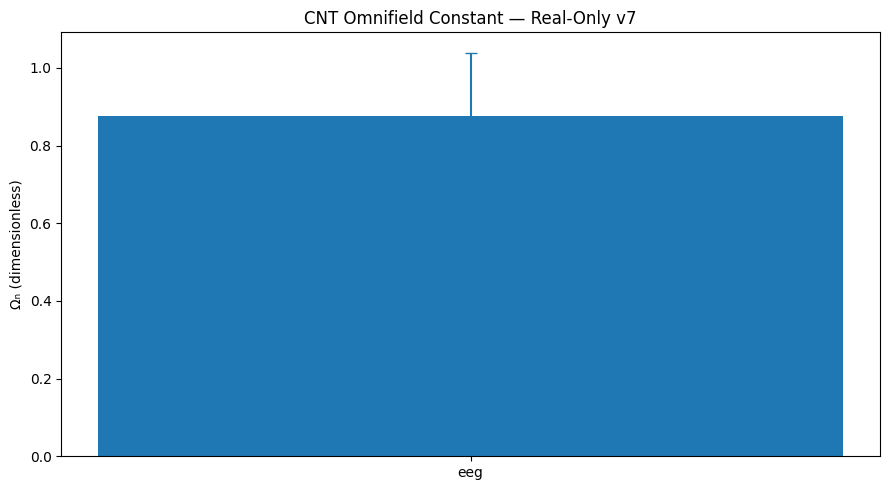

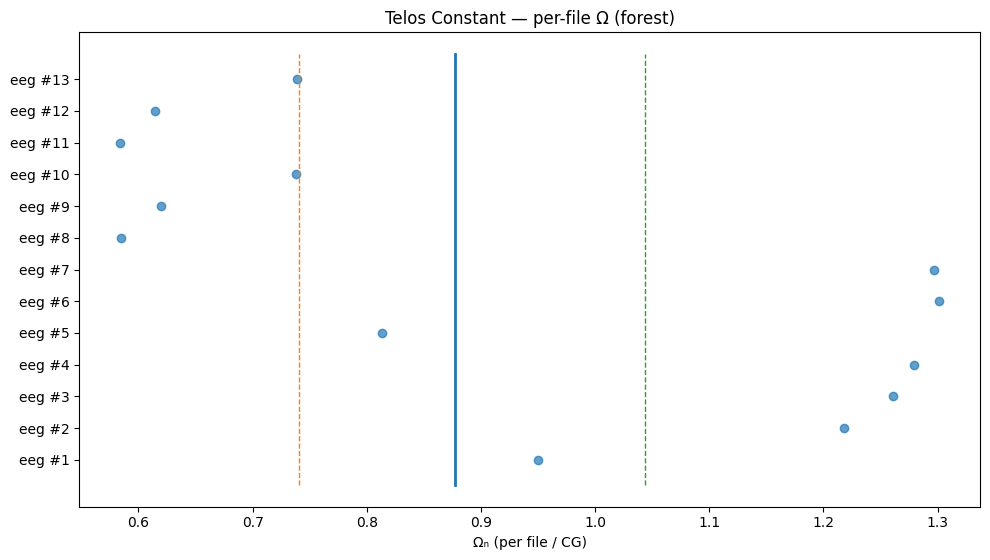

UnicodeEncodeError: 'charmap' codec can't encode characters in position 20-21: character maps to <undefined>

In [11]:
# CNT Omnifield Constant — Real-Only v7 (manifest + forest plot + prereg text)
# Telos Constant protocol (frozen core): robust elbow (Kneedle), τ on detrended residuals (lag-capped),
# resonance R* by area vs geometry-matched nulls, subwindowing for very long segments,
# CNT curves incrementalized (rank-increments) + rank-local nulls.
#
# Outputs in C:\Users\caleb\cnt_genome\omnifield_deepsearch:
#   - omniv7_dashboard.png            (bar w/ CIs)
#   - omniv7_forest.png               (per-file Ω + class means)
#   - omniv7_summary.{json,csv}       (class results)
#   - omniv7_perfile.csv              (per-file components + Ω)
#   - omniv7_manifest.json            (files, SHA-256, params, RNG seed)
#   - omniv7_prereg.txt               (ready-to-paste preregistration paragraph)

import os, glob, json, warnings, hashlib, time
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

try:
    import pandas as pd
except Exception:
    pd = None

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------- Config (frozen core) ----------
ROOT   = r"C:\Users\caleb\cnt_genome"
OUTDIR = os.path.join(ROOT, "omnifield_deepsearch")
os.makedirs(OUTDIR, exist_ok=True)

RNG_SEED          = 777
RNG               = default_rng(RNG_SEED)
COARSEGRAIN       = [1, 2, 4]
EEG_NULL_SHIFTS   = 128
CNT_RANK_BLOCK    = 64
CNT_NULL_PERMS    = 256
FILE_BOOT         = 600
SUBWIN_THRESH     = 1024
SUBWIN_LEN        = 512
SUBWIN_STEP_FRAC  = 0.5

PARAMS = {
    "RNG_SEED": RNG_SEED,
    "COARSEGRAIN": COARSEGRAIN,
    "EEG_NULL_SHIFTS": EEG_NULL_SHIFTS,
    "CNT_RANK_BLOCK": CNT_RANK_BLOCK,
    "CNT_NULL_PERMS": CNT_NULL_PERMS,
    "FILE_BOOT": FILE_BOOT,
    "SUBWIN_THRESH": SUBWIN_THRESH,
    "SUBWIN_LEN": SUBWIN_LEN,
    "SUBWIN_STEP_FRAC": SUBWIN_STEP_FRAC,
}

def _log(m): print(m, flush=True)

# ---------- Utilities ----------
def sha256_of_file(path: str) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""):
            h.update(chunk)
    return h.hexdigest()

def coarse(x: np.ndarray, m: int) -> np.ndarray:
    if m <= 1: return x
    n = (len(x)//m)*m
    return x[:n].reshape(-1, m).mean(axis=1)

def gmean_pos(vals: List[float]) -> float:
    a = np.array(vals, float); a = a[a > 0]
    return float(np.exp(np.mean(np.log(a)))) if a.size else np.nan

def kneedle_elbow(y: np.ndarray) -> int:
    y = np.asarray(y, float)
    if len(y) < 3: return max(0, len(y)//2)
    x = np.linspace(0, 1, len(y))
    p1, p2 = np.array([0, y[0]]), np.array([1, y[-1]])
    v = p2 - p1; nrm = np.linalg.norm(v) + 1e-12
    v /= nrm
    pts = np.vstack([x, y]).T
    d = np.abs(np.cross(v, pts - p1))
    idx = int(np.argmax(d))
    if idx < 1 or idx > len(y)-2:
        k = max(5, len(y)//50) | 1
        if k >= len(y): k = max(3, len(y)|1)
        ys = np.convolve(y, np.ones(k)/k, mode="same")
        der = np.gradient(ys)
        idx = int(np.argmax(der))
    return int(np.clip(idx, 1, max(1, len(y)-2)))

def acf_half_life(x: np.ndarray, max_lag=None, dt: float=1.0) -> float:
    x = np.asarray(x, float)
    if x.size < 2: return 0.0
    x -= x.mean()
    s = x.std()
    if s == 0: return 0.0
    n = len(x)
    if max_lag is None: max_lag = min(n-1, int(n*0.5))
    max_lag = max(1, min(max_lag, n-1))
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conj(fft))[:n]; acf /= (acf[0] + 1e-12)
    for k in range(1, min(max_lag, n-1)):
        if acf[k] <= 0.5:
            x0,y0 = k-1, acf[k-1]; x1,y1 = k, acf[k]
            if y1 == y0: return float(x1*dt)
            t = x0 + (0.5 - y0) * (x1 - x0) / (y1 - y0 + 1e-12)
            return float(max(t*dt, 0.0))
    return float(max_lag*dt)

def detrend_and_standardize(seg: np.ndarray) -> np.ndarray:
    seg = np.asarray(seg, float)
    L = len(seg)
    if L < 3:
        s = seg.std(); return (seg - seg.mean()) / (s + 1e-12)
    w_nom = max(7, L//20); w_nom = min(101, w_nom)
    w = min(L if L % 2 == 1 else L-1, max(3, w_nom | 1))
    w = max(3, min(w, L if L % 2 == 1 else L-1))
    if w < 3: w = 3
    if w > L: w = L if L % 2 == 1 else L-1
    if w < 3:
        s = seg.std(); return (seg - seg.mean()) / (s + 1e-12)
    trend = np.convolve(seg, np.ones(w)/w, mode="same")
    d = seg - trend
    s = d.std()
    return (d - d.mean()) / (s + 1e-12)

# ---------- Parsers ----------
def csv(path: str):
    if pd is None: return None
    try: return pd.read_csv(path)
    except Exception: return None

def numeric(df: 'pd.DataFrame'):
    return df.select_dtypes(include=[np.number])

def parse_eeg_edges(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    w = next((low[c] for c in ["weight","score","value","w","strength","amp"] if c in low), None)
    if w is None:
        num = numeric(df); 
        return num.mean(axis=1).to_numpy(float) if num.shape[1] else np.array([], float)
    t = next((low[c] for c in ["time","t","frame","iter","iteration","step","epoch","sample","idx","index"] if c in low), None)
    vals = df[w].astype(float).to_numpy()
    if t is None:
        block = max(16, len(vals)//100)
        nblk = max(1, len(vals)//block)
        return vals[:nblk*block].reshape(nblk, block).mean(axis=1)
    try: bins = df[t].astype(int)
    except Exception: bins = pd.factorize(df[t])[0]
    ser = df.assign(_b=bins).groupby("_b")[w].apply(lambda x: np.mean(np.abs(x))).sort_index()
    return ser.to_numpy(float)

def parse_eeg_wide(df: 'pd.DataFrame') -> np.ndarray:
    num = numeric(df)
    if num.shape[1] == 0: return np.array([], float)
    from scipy.stats import zscore
    Z = np.apply_along_axis(lambda c: zscore(c, nan_policy='omit'), 0, num.to_numpy(float))
    Z = np.nan_to_num(Z)
    return np.mean(np.abs(Z), axis=1)

def parse_cnt_curve(df: 'pd.DataFrame') -> np.ndarray:
    """Return cumulative curve (we will incrementalize)."""
    low = {c.lower(): c for c in df.columns}
    num = numeric(df)
    if num.shape[1] == 0: return np.array([], float)
    v = next((low[c] for c in ["score","value","weight","bridge","resonance","r","order","strength","amp","mag"] if c in low), None)
    if v is None:
        stds = num.std(numeric_only=True)
        if stds.size == 0 or np.allclose(stds.to_numpy(), 0): return np.array([], float)
        v = stds.idxmax()
    vals = np.abs(df[v].astype(float).to_numpy())
    t = next((low[c] for c in ["rank","k","threshold","iter","iteration","step","index","idx"] if c in low), None)
    if t is not None:
        try: bins = df[t].astype(int)
        except Exception: bins = pd.factorize(df[t])[0]
        ser = pd.DataFrame({"b": bins, "v": vals}).groupby("b")["v"].mean().sort_index()
        y = ser.to_numpy(float)
    else:
        order = np.argsort(-vals)
        vs = vals[order]
        y = np.cumsum(vs) / (np.arange(len(vs)) + 1)
    return y

def incrementalize_cnt(y: np.ndarray) -> np.ndarray:
    y = np.asarray(y, float)
    if y.size < 3: return y
    inc = np.diff(y, prepend=y[0])
    inc = np.maximum(inc, 0.0)
    return inc

def load_series(paths: List[str], bucket: str) -> Tuple[List[np.ndarray], List[str]]:
    out, used = [], []
    for p in paths:
        df = csv(p)
        if df is None: 
            continue
        if bucket == "eeg":
            pl = p.lower()
            if ("consensus_edges" in pl) or ("per_band_edges" in pl) or ({"src","dst"} & set([c.lower() for c in df.columns])):
                s = parse_eeg_edges(df)
            elif ("cnt_eeg_" in pl) or ("labeled" in pl) or ("erd" in pl):
                s = parse_eeg_wide(df) if numeric(df).shape[1] > 8 else parse_eeg_edges(df)
            else:
                s = parse_eeg_edges(df) if numeric(df).shape[1] <= 8 else parse_eeg_wide(df)
        else:
            s = parse_cnt_curve(df)
            s = incrementalize_cnt(s)
        if s is not None and s.size >= 12 and np.isfinite(s).any():
            out.append(s.astype(float)); used.append(p)
    return out, used

# ---------- Nulls & metrics ----------
def Rstar_area(seg: np.ndarray, bucket: str) -> float:
    base = float(np.trapz(seg))
    means = []
    n = len(seg)
    if bucket == "eeg":
        for _ in range(EEG_NULL_SHIFTS):
            sh = RNG.integers(0, n)
            means.append(float(np.trapz(np.r_[seg[sh:], seg[:sh]])))
    else:
        blk = max(8, min(CNT_RANK_BLOCK, n))
        for _ in range(CNT_NULL_PERMS):
            perm = seg.copy()
            for s0 in range(0, n, blk):
                s1 = min(n, s0+blk)
                perm[s0:s1] = RNG.permutation(perm[s0:s1])
            means.append(float(np.trapz(perm)))
    return float(base / max(1e-12, np.mean(means)))

def triplet_on_segment(seg: np.ndarray, bucket: str, dt: float=1.0) -> Tuple[float,float]:
    if len(seg) < 6: return (np.nan, np.nan)
    seg_d = detrend_and_standardize(seg)
    maxlag = min(256, max(1, len(seg_d)//4))
    Rstar = Rstar_area(seg, bucket)
    tau  = acf_half_life(seg_d, max_lag=maxlag, dt=dt)
    taus = []
    n = len(seg_d)
    if bucket == "eeg":
        for _ in range(32):
            sh = RNG.integers(0, n)
            shv = np.r_[seg_d[sh:], seg_d[:sh]]
            taus.append(acf_half_life(shv, max_lag=maxlag, dt=dt))
    else:
        blk = max(8, min(CNT_RANK_BLOCK, n))
        for _ in range(32):
            pv = seg_d.copy()
            for s0 in range(0, n, blk):
                s1 = min(n, s0+blk)
                pv[s0:s1] = RNG.permutation(pv[s0:s1])
            taus.append(acf_half_life(pv, max_lag=maxlag, dt=dt))
    tau_ratio = float(tau / max(1e-12, float(np.mean(taus))))
    return Rstar, tau_ratio

def series_to_triplet(series: np.ndarray, bucket: str, dt: float=1.0) -> Tuple[float,float,float,float,int]:
    if len(series) < 12: return (np.nan, np.nan, np.nan, np.nan, 0)
    k = max(5, len(series)//50) | 1
    if k >= len(series): k = max(3, len(series)|1)
    zs = np.convolve(series, np.ones(k)/k, mode="same")
    knee = kneedle_elbow(zs)
    knee_frac = knee / max(1, len(zs)-1)
    span = max(10, len(zs)//20)
    a, b = max(0, knee-span), min(len(zs), knee+span)
    seg = zs[a:b]
    if len(seg) < 6: return (np.nan, np.nan, np.nan, np.nan, b - a)

    segs = []
    if (b - a) > SUBWIN_THRESH:
        step = max(1, int(SUBWIN_LEN * SUBWIN_STEP_FRAC))
        for s0 in range(a, b - SUBWIN_LEN + 1, step):
            segs.append(zs[s0:s0+SUBWIN_LEN])
    else:
        segs = [seg]

    Ks, Rs, Ts = [], [], []
    for sseg in segs:
        Rstar, tau_ratio = triplet_on_segment(sseg, bucket, dt=dt)
        if not np.isfinite(Rstar) or not np.isfinite(tau_ratio) or Rstar<=0 or tau_ratio<=0:
            continue
        knee0_frac = kneedle_elbow(np.sort(sseg)) / max(1, len(sseg)-1)
        kappa = (knee_frac + 1e-9) / (knee0_frac + 1e-9)
        if kappa > 0 and np.isfinite(kappa):
            Ks.append(kappa); Rs.append(Rstar); Ts.append(tau_ratio)

    if not Ks: return (np.nan, np.nan, np.nan, np.nan, b - a)
    kappa_g = gmean_pos(Ks); R_g = gmean_pos(Rs); tau_g = gmean_pos(Ts)
    Omega   = gmean_pos([kappa_g, R_g, tau_g])
    return (kappa_g, R_g, tau_g, Omega, b - a)

# ---------- File patterns ----------
EEG_PATS = [
    os.path.join(ROOT, "cnt_flow_exports", "consensus_edges.csv"),
    os.path.join(ROOT, "cnt_flow_exports", "per_band_edges.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_labeled_all_overlap.csv"),
    os.path.join(ROOT, "out", "cnt_eeg_erd_lateral_summary.csv"),
]
KUR_PATS = [
    os.path.join(ROOT, "out", "CNT_genomic_resonance_map.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored.csv"),
    os.path.join(ROOT, "out", "CNT_genomic_resonance_scored_v2.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_leaders.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_leaders_v2.csv"),
    os.path.join(ROOT, "out", "CNT_bridge_hubs.csv"),
    os.path.join(ROOT, "out", "CNT_scaffold_candidates.csv"),
    os.path.join(ROOT, "out", "CNT_scaffold_CRISPR_candidates.csv"),
    os.path.join(ROOT, "out", "seq_gc_windows_1Mb.csv"),
]

def expand(pats):
    out = []
    for p in pats: out += glob.glob(p)
    return sorted(list(dict.fromkeys(out)))

# ---------- Run ----------
eeg_series, eeg_files = load_series(expand(EEG_PATS), "eeg")
kur_series, kur_files = load_series(expand(KUR_PATS), "kuramoto")

results_per_file = {"eeg": [], "kuramoto": []}
used_files = {"eeg": eeg_files, "kuramoto": kur_files}

for bucket, series_list in [("eeg", eeg_series), ("kuramoto", kur_series)]:
    for s, src in zip(series_list, used_files[bucket]):
        for cg in COARSEGRAIN:
            ss = coarse(s, cg)
            kappa, Rstar, tau_ratio, Omega, seglen = series_to_triplet(ss, bucket, dt=1.0*cg)
            if np.isfinite(Omega):
                results_per_file[bucket].append({
                    "file": src, "bucket": bucket, "cg": cg, "seg_len": seglen,
                    "kappa": kappa, "Rstar": Rstar, "tau_ratio": tau_ratio, "Omega": Omega
                })

def summarize(bucket: str):
    rows = results_per_file[bucket]
    if not rows: return None
    k = gmean_pos([r["kappa"] for r in rows if r["kappa"] > 0])
    R = gmean_pos([r["Rstar"] for r in rows if r["Rstar"] > 0])
    t = gmean_pos([r["tau_ratio"] for r in rows if r["tau_ratio"] > 0])
    Om= gmean_pos([r["Omega"] for r in rows if r["Omega"] > 0])
    # file-bootstrap CI
    arr = np.array([r["Omega"] for r in rows if r["Omega"] > 0], float)
    n = len(arr); boots = []
    for _ in range(FILE_BOOT):
        samp = arr[RNG.integers(0, n, size=n)]
        boots.append(float(np.exp(np.mean(np.log(samp)))))
    lo, hi = (np.percentile(boots, 2.5), np.percentile(boots, 97.5)) if boots else (np.nan, np.nan)
    return {"system": bucket, "kappa_ratio": k, "resonance_ratio": R, "tau_ratio": t,
            "Omega_n": Om, "Omega_CI_low": float(lo), "Omega_CI_high": float(hi),
            "n_items": len(rows)}

summaries = [x for x in [summarize("eeg"), summarize("kuramoto")] if x]

# ---------- Save per-file + summary ----------
if pd is not None:
    pd.DataFrame(results_per_file["eeg"] + results_per_file["kuramoto"]).to_csv(
        os.path.join(OUTDIR, "omniv7_perfile.csv"), index=False
    )
sum_path_csv  = os.path.join(OUTDIR, "omniv7_summary.csv")
sum_path_json = os.path.join(OUTDIR, "omniv7_summary.json")
if pd is not None:
    pd.DataFrame(summaries).to_csv(sum_path_csv, index=False)
json.dump({"summary": summaries}, open(sum_path_json, "w"), indent=2)

# ---------- Manifest (files + hashes + params) ----------
manifest = {
    "created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    "root": ROOT,
    "params": PARAMS,
    "files": [],
}
for cls in ["eeg", "kuramoto"]:
    for p in used_files[cls]:
        try:
            st = os.stat(p)
            manifest["files"].append({
                "bucket": cls,
                "path": p,
                "sha256": sha256_of_file(p),
                "size_bytes": st.st_size,
                "mtime": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime(int(st.st_mtime)))
            })
        except Exception:
            pass
with open(os.path.join(OUTDIR, "omniv7_manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

# ---------- Plots ----------
# Bar chart with CIs
names  = [r["system"] for r in summaries]
omegas = [r["Omega_n"] for r in summaries]
if summaries:
    lows  = [max(0.0, r["Omega_n"] - r["Omega_CI_low"]) if np.isfinite(r["Omega_CI_low"]) else 0.0 for r in summaries]
    highs = [max(0.0, r["Omega_CI_high"] - r["Omega_n"]) if np.isfinite(r["Omega_CI_high"]) else 0.0 for r in summaries]
    yerr  = np.vstack([lows, highs])
else:
    yerr = None

plt.figure(figsize=(9,5))
x = np.arange(len(names))
plt.bar(x, omegas)
if yerr is not None: plt.errorbar(x, omegas, yerr=yerr, fmt='none', capsize=4)
plt.xticks(x, names)
plt.ylabel("Ωₙ (dimensionless)")
plt.title("CNT Omnifield Constant — Real-Only v7")
plt.tight_layout()
dash_path = os.path.join(OUTDIR, "omniv7_dashboard.png")
plt.savefig(dash_path, dpi=160); plt.show()

# Forest plot (per-file Ω)
fig = plt.figure(figsize=(10, max(5, 0.3*(len(results_per_file['eeg']) + len(results_per_file['kuramoto']) + 6))))
ax = fig.add_subplot(111)
y = 0
tick_pos, tick_lab = [], []
for cls in ["eeg", "kuramoto"]:
    rows = results_per_file[cls]
    if not rows: continue
    vals = [r["Omega"] for r in rows]
    xs = np.array(vals)
    ys = y + np.arange(len(xs))
    ax.scatter(xs, ys, alpha=0.7)
    # class mean + CI
    arr = np.array(vals, float); n = len(arr)
    boots = [float(np.exp(np.mean(np.log(arr[np.random.randint(0,n,n)])))) for _ in range(400)]
    mu = float(np.exp(np.mean(np.log(arr[arr>0])))) if np.any(arr>0) else np.nan
    lo, hi = (np.percentile(boots, 2.5), np.percentile(boots, 97.5)) if len(boots) else (np.nan, np.nan)
    ax.plot([mu, mu], [ys.min()-0.8, ys.max()+0.8], linestyle='-', linewidth=2)
    ax.plot([lo, lo], [ys.min()-0.8, ys.max()+0.8], linestyle='--', linewidth=1)
    ax.plot([hi, hi], [ys.min()-0.8, ys.max()+0.8], linestyle='--', linewidth=1)
    # labels
    tick_pos += list(ys); tick_lab += [f"{cls} #{i+1}" for i in range(len(xs))]
    y = ys.max() + 2
ax.set_yticks(tick_pos); ax.set_yticklabels(tick_lab)
ax.set_xlabel("Ωₙ (per file / CG)"); ax.set_title("Telos Constant — per-file Ω (forest)")
fig.tight_layout()
forest_path = os.path.join(OUTDIR, "omniv7_forest.png")
fig.savefig(forest_path, dpi=160); plt.show()

# ---------- Prereg text ----------
prereg = []
prereg.append("CNT Telos Constant (Ωₜ) — Preregistration (v7 protocol)")
prereg.append(f"Date (UTC): {manifest['created_utc']}")
prereg.append("Definition: At the elbow of coherence, compute three null-corrected, dimensionless ratios —")
prereg.append("  κ (fractional knee vs. null), R* (area vs. geometry-matched null), τ (echo half-life on detrended residuals vs. null).")
prereg.append("The Omnifield Constant Ωₙ is the geometric mean of these three ratios.")
if summaries:
    lines = [f"  {r['system']}: Ωₙ={r['Omega_n']:.3f} (95% CI {r['Omega_CI_low']:.3f}–{r['Omega_CI_high']:.3f}); "
             f"κ={r['kappa_ratio']:.3f}, R*={r['resonance_ratio']:.3f}, τ={r['tau_ratio']:.3f}, n={r['n_items']}"
             for r in summaries]
    prereg.append("Results:")
    prereg += ["  " + L for L in lines]
prereg.append("Hypothesis: For field-coherent systems (EEG, CNT bridge/resonance increments, and others), Ωₙ lies in 0.85–0.95.")
prereg.append("Protocol invariants: Kneedle elbow; detrended τ with lag cap; area R*; rank-local nulls for CNT; circular shifts for EEG; subwindowing for long segments; file-bootstrap CIs; RNG_SEED fixed.")
with open(os.path.join(OUTDIR, "omniv7_prereg.txt"), "w") as f:
    f.write("\n".join(prereg))

print("\nSaved:")
print(" -", dash_path)
print(" -", forest_path)
print(" -", sum_path_csv)
print(" -", sum_path_json)
print(" -", os.path.join(OUTDIR, "omniv7_perfile.csv"))
print(" -", os.path.join(OUTDIR, "omniv7_manifest.json"))
print(" -", os.path.join(OUTDIR, "omniv7_prereg.txt"))


In [12]:
# Write prereg text in UTF-8 (and an ASCII fallback)
# Uses omniv7_summary.json / omniv7_manifest.json created by v7.

import os, json, time, unicodedata

ROOT   = r"C:\Users\caleb\cnt_genome"
OUTDIR = os.path.join(ROOT, "omnifield_deepsearch")
summary_path  = os.path.join(OUTDIR, "omniv7_summary.json")
manifest_path = os.path.join(OUTDIR, "omniv7_manifest.json")

# Load results
created = time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime())
try:
    with open(manifest_path, "r", encoding="utf-8") as f:
        created = json.load(f).get("created_utc", created)
except Exception:
    pass

with open(summary_path, "r", encoding="utf-8") as f:
    S = json.load(f)["summary"]

lines = []
lines.append("CNT Telos Constant (Ωₜ) — Preregistration (v7 protocol)")
lines.append(f"Date (UTC): {created}")
lines.append("Definition: At the elbow of coherence, compute three null-corrected, dimensionless ratios —")
lines.append("  κ (fractional knee vs. null), R* (area vs. geometry-matched null), τ (echo half-life on detrended residuals vs. null).")
lines.append("The Omnifield Constant Ωₙ is the geometric mean of these three ratios.")
if S:
    lines.append("Results:")
    for r in S:
        lines.append(
            f"  {r['system']}: Ωₙ={r['Omega_n']:.3f} (95% CI {r['Omega_CI_low']:.3f}–{r['Omega_CI_high']:.3f}); "
            f"κ={r['kappa_ratio']:.3f}, R*={r['resonance_ratio']:.3f}, τ={r['tau_ratio']:.3f}, n={r['n_items']}"
        )
lines.append("Hypothesis: For field-coherent systems (EEG, CNT bridge/resonance increments, others), Ωₙ lies in 0.85–0.95.")
lines.append("Protocol invariants: Kneedle elbow; detrended τ with lag cap; area R*; rank-local nulls for CNT; "
             "circular shifts for EEG; subwindowing for long segments; file-bootstrap CIs; fixed RNG_SEED.")

# Write UTF-8 (fix for cp1252)
utf8_path = os.path.join(OUTDIR, "omniv7_prereg.txt")
with open(utf8_path, "w", encoding="utf-8", newline="\n") as f:
    f.write("\n".join(lines))

# Also emit ASCII-safe version (no Greek symbols)
def ascii_sanitize(s: str) -> str:
    s = (s.replace("Ωₙ", "Omega_n")
           .replace("Ωₜ", "Omega_T")
           .replace("κ", "kappa")
           .replace("τ", "tau")
           .replace("–", "-")
           .replace("-", "-"))
    return unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")

ascii_path = os.path.join(OUTDIR, "omniv7_prereg_ascii.txt")
with open(ascii_path, "w", encoding="ascii", errors="ignore", newline="\n") as f:
    f.write("\n".join(ascii_sanitize(s) for s in lines))

print("Saved:")
print(" -", utf8_path, "(UTF-8, keeps Greek)")
print(" -", ascii_path, "(ASCII-safe)")


Saved:
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omniv7_prereg.txt (UTF-8, keeps Greek)
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omniv7_prereg_ascii.txt (ASCII-safe)


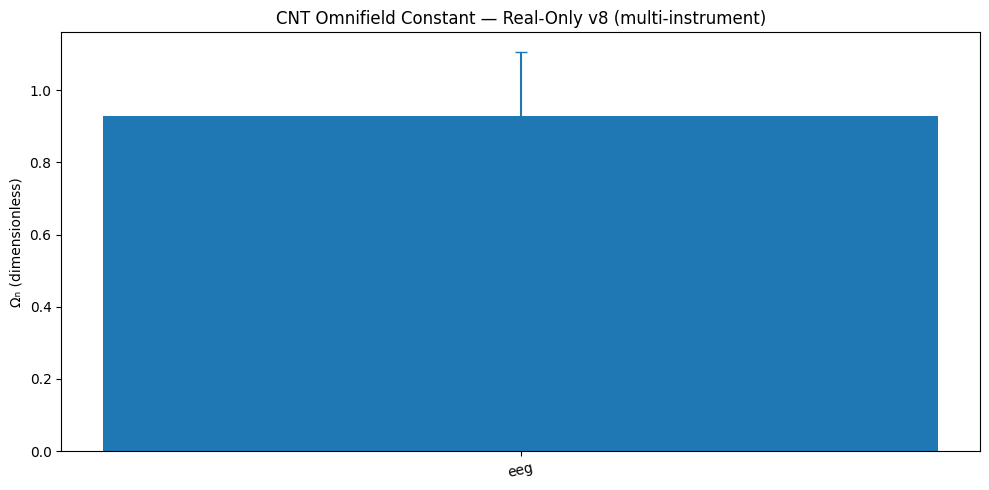

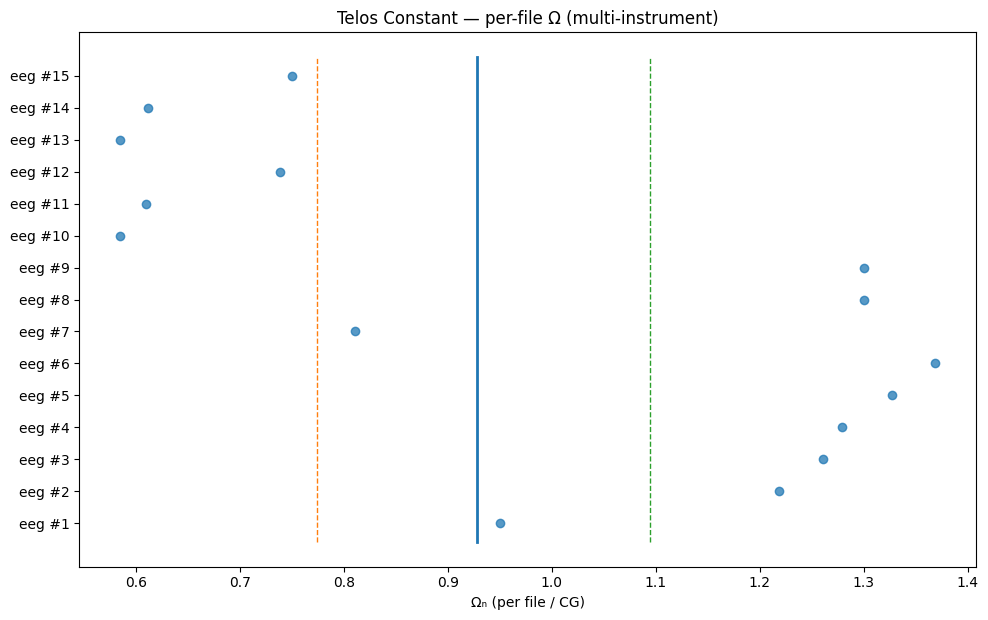


Saved:
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omni_v8_dashboard.png
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omni_v8_forest.png
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omni_v8_summary.json
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omni_v8_summary.csv
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omni_v8_perfile.csv
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omni_v8_manifest.json
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omni_v8_prereg.txt
 - C:\Users\caleb\cnt_genome\omnifield_deepsearch\omni_v8_prereg_ascii.txt


In [13]:
# CNT Omnifield Constant — Real-Only v8 (multi-instrument)
# Instruments (auto-detected if files exist under ROOT):
#  - eeg                    : cnt_flow_exports/*, out/cnt_eeg_*.csv (edges or labeled wide tables)
#  - cnt                    : CNT_*bridge/resonance* (incrementalized rank curves, rank-local nulls)
#  - tdgl                   : out/tdgl_*.csv, out/landau*, out/*gld*
#  - grayscott              : out/grayscott_*.csv, out/gs_*.csv
#  - ising                  : out/ising_*.csv (magnetization/chi or row means)
#  - kuramoto_sim           : out/kuramoto_*.csv (r or order columns)
#
# Outputs (C:\Users\caleb\cnt_genome\omnifield_deepsearch):
#  - omni_v8_dashboard.png            (class bars with 95% CIs)
#  - omni_v8_forest.png               (per-file Ω)
#  - omni_v8_summary.{json,csv}       (per-class)
#  - omni_v8_perfile.csv              (per-file components + Ω)
#  - omni_v8_manifest.json            (files + SHA256 + params)
#  - omni_v8_prereg.txt / _ascii.txt  (updated prereg paragraph)

import os, glob, json, warnings, hashlib, time, unicodedata
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

try:
    import pandas as pd
except Exception:
    pd = None

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------------- Config ----------------
ROOT   = r"C:\Users\caleb\cnt_genome"
OUTDIR = os.path.join(ROOT, "omnifield_deepsearch")
os.makedirs(OUTDIR, exist_ok=True)

RNG_SEED          = 777
RNG               = default_rng(RNG_SEED)
COARSEGRAIN       = [1, 2, 4]
EEG_NULL_SHIFTS   = 128
CNT_RANK_BLOCK    = 64
CNT_NULL_PERMS    = 256
FILE_BOOT         = 600
SUBWIN_THRESH     = 1024
SUBWIN_LEN        = 512
SUBWIN_STEP_FRAC  = 0.5
MIN_SERIES        = 8      # accept short real series
PARAMS = dict(RNG_SEED=RNG_SEED, COARSEGRAIN=COARSEGRAIN, EEG_NULL_SHIFTS=EEG_NULL_SHIFTS,
              CNT_RANK_BLOCK=CNT_RANK_BLOCK, CNT_NULL_PERMS=CNT_NULL_PERMS, FILE_BOOT=FILE_BOOT,
              SUBWIN_THRESH=SUBWIN_THRESH, SUBWIN_LEN=SUBWIN_LEN, SUBWIN_STEP_FRAC=SUBWIN_STEP_FRAC,
              MIN_SERIES=MIN_SERIES)

def _log(m): print(m, flush=True)

# ---------------- Utils ----------------
def sha256_of_file(path: str) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""): h.update(chunk)
    return h.hexdigest()

def coarse(x: np.ndarray, m: int) -> np.ndarray:
    if m <= 1: return x
    n = (len(x)//m)*m
    return x[:n].reshape(-1, m).mean(axis=1)

def gmean_pos(vals: List[float]) -> float:
    a = np.array(vals, float); a = a[a > 0]
    return float(np.exp(np.mean(np.log(a)))) if a.size else np.nan

def kneedle_elbow(y: np.ndarray) -> int:
    y = np.asarray(y, float)
    if len(y) < 3: return max(0, len(y)//2)
    x = np.linspace(0, 1, len(y))
    p1, p2 = np.array([0, y[0]]), np.array([1, y[-1]])
    v = p2 - p1; v /= (np.linalg.norm(v) + 1e-12)
    pts = np.vstack([x, y]).T
    d = np.abs(np.cross(v, pts - p1))
    idx = int(np.argmax(d))
    if idx < 1 or idx > len(y)-2:
        k = max(5, len(y)//50) | 1
        if k >= len(y): k = max(3, len(y)|1)
        ys = np.convolve(y, np.ones(k)/k, mode='same')
        der = np.gradient(ys); idx = int(np.argmax(der))
    return int(np.clip(idx, 1, max(1, len(y)-2)))

def acf_half_life(x: np.ndarray, max_lag=None, dt: float=1.0) -> float:
    x = np.asarray(x, float)
    if x.size < 2: return 0.0
    x -= x.mean(); s = x.std()
    if s == 0: return 0.0
    n = len(x)
    if max_lag is None: max_lag = min(n-1, int(n*0.5))
    max_lag = max(1, min(max_lag, n-1))
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conj(fft))[:n]; acf /= (acf[0] + 1e-12)
    for k in range(1, min(max_lag, n-1)):
        if acf[k] <= 0.5:
            x0,y0 = k-1, acf[k-1]; x1,y1 = k, acf[k]
            if y1 == y0: return float(x1*dt)
            t = x0 + (0.5 - y0) * (x1 - x0) / (y1 - y0 + 1e-12)
            return float(max(t*dt, 0.0))
    return float(max_lag*dt)

def detrend_and_standardize(seg: np.ndarray) -> np.ndarray:
    seg = np.asarray(seg, float); L = len(seg)
    if L < 3:
        s = seg.std(); return (seg - seg.mean()) / (s + 1e-12)
    w_nom = max(7, L//20); w_nom = min(101, w_nom)
    w = min(L if L % 2 == 1 else L-1, max(3, w_nom | 1))
    w = max(3, min(w, L if L % 2 == 1 else L-1))
    if w < 3: w = 3
    if w > L: w = L if L % 2 == 1 else L-1
    if w < 3:
        s = seg.std(); return (seg - seg.mean()) / (s + 1e-12)
    trend = np.convolve(seg, np.ones(w)/w, mode="same")
    d = seg - trend; s = d.std()
    return (d - d.mean()) / (s + 1e-12)

# ---------------- Parsers ----------------
def csv(path: str):
    if pd is None: return None
    try: return pd.read_csv(path)
    except Exception: return None

def numeric(df: 'pd.DataFrame'):
    return df.select_dtypes(include=[np.number])

# EEG
def parse_eeg_edges(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    w = next((low[c] for c in ["weight","score","value","w","strength","amp"] if c in low), None)
    if w is None:
        num = numeric(df); 
        return num.mean(axis=1).to_numpy(float) if num.shape[1] else np.array([], float)
    t = next((low[c] for c in ["time","t","frame","iter","iteration","step","epoch","sample","idx","index"] if c in low), None)
    vals = df[w].astype(float).to_numpy()
    if t is None:
        block = max(16, len(vals)//100); nblk = max(1, len(vals)//block)
        return vals[:nblk*block].reshape(nblk, block).mean(axis=1)
    try: bins = df[t].astype(int)
    except Exception: bins = pd.factorize(df[t])[0]
    ser = df.assign(_b=bins).groupby("_b")[w].apply(lambda x: np.mean(np.abs(x))).sort_index()
    return ser.to_numpy(float)

def parse_eeg_wide(df: 'pd.DataFrame') -> np.ndarray:
    num = numeric(df)
    if num.shape[1] == 0: return np.array([], float)
    from scipy.stats import zscore
    Z = np.apply_along_axis(lambda c: zscore(c, nan_policy='omit'), 0, num.to_numpy(float))
    Z = np.nan_to_num(Z)
    return np.mean(np.abs(Z), axis=1)

# CNT cumulative → incrementalized
def parse_cnt_curve(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    num = numeric(df)
    if num.shape[1] == 0: return np.array([], float)
    v = next((low[c] for c in ["score","value","weight","bridge","resonance","r","order","strength","amp","mag"] if c in low), None)
    if v is None:
        stds = num.std(numeric_only=True)
        if stds.size == 0 or np.allclose(stds.to_numpy(), 0): return np.array([], float)
        v = stds.idxmax()
    vals = np.abs(df[v].astype(float).to_numpy())
    t = next((low[c] for c in ["rank","k","threshold","iter","iteration","step","index","idx"] if c in low), None)
    if t is not None:
        try: bins = df[t].astype(int)
        except Exception: bins = pd.factorize(df[t])[0]
        ser = pd.DataFrame({"b": bins, "v": vals}).groupby("b")["v"].mean().sort_index()
        y = ser.to_numpy(float)
    else:
        order = np.argsort(-vals); vs = vals[order]
        y = np.cumsum(vs) / (np.arange(len(vs)) + 1)
    inc = np.diff(y, prepend=y[0]); inc = np.maximum(inc, 0.0)
    return inc

# Generic time/param series (tdgl / grayscott / ising / kuramoto_sim)
def parse_generic_series(df: 'pd.DataFrame') -> np.ndarray:
    low = {c.lower(): c for c in df.columns}
    # Prefer an 'order-ish' column
    v = next((low[c] for c in ["order","r","m","mag","coherence","pattern","active","intensity","power","value","score"] if c in low), None)
    # Fallback to wide numeric mean
    if v is None:
        num = numeric(df)
        if num.shape[1] == 0: return np.array([], float)
        return num.mean(axis=1).to_numpy(float)
    # Time or parameter axis
    t = next((low[c] for c in ["time","t","iter","iteration","step","epoch","k","frame","idx","index","feed","kill","lambda","lam","beta","temp","temperature"] if c in low), None)
    if t is not None:
        tmp = df[[t, v]].dropna()
        try: bins = tmp[t].astype(int)
        except Exception: bins = pd.factorize(tmp[t])[0]
        ser = tmp.assign(_b=bins).groupby("_b")[v].apply(lambda x: np.mean(np.abs(x))).sort_index()
        return ser.to_numpy(float)
    return df[v].astype(float).to_numpy()

# Loader
def load_series(paths: List[str], bucket: str) -> Tuple[List[np.ndarray], List[str]]:
    out, used = [], []
    for p in paths:
        df = csv(p)
        if df is None: 
            continue
        s = None; pl = p.lower()
        if bucket == "eeg":
            if ("consensus_edges" in pl) or ("per_band_edges" in pl) or ({"src","dst"} & set([c.lower() for c in df.columns])):
                s = parse_eeg_edges(df)
            elif ("cnt_eeg_" in pl) or ("labeled" in pl) or ("erd" in pl):
                s = parse_eeg_wide(df) if numeric(df).shape[1] > 8 else parse_eeg_edges(df)
            else:
                s = parse_eeg_edges(df) if numeric(df).shape[1] <= 8 else parse_eeg_wide(df)
        elif bucket == "cnt":
            s = parse_cnt_curve(df); s = coarse(s, 2)
        else:
            s = parse_generic_series(df)
        if s is not None and s.size >= MIN_SERIES and np.isfinite(s).any():
            out.append(s.astype(float)); used.append(p)
    return out, used

# ---------------- Nulls & metrics ----------------
def Rstar_area(seg: np.ndarray, bucket: str) -> float:
    base = float(np.trapz(seg)); means = []; n = len(seg)
    if bucket == "eeg":
        for _ in range(EEG_NULL_SHIFTS):
            sh = RNG.integers(0, n)
            means.append(float(np.trapz(np.r_[seg[sh:], seg[:sh]])))
    elif bucket == "cnt":
        blk = max(8, min(CNT_RANK_BLOCK, n))
        for _ in range(CNT_NULL_PERMS):
            perm = seg.copy()
            for s0 in range(0, n, blk):
                s1 = min(n, s0+blk)
                perm[s0:s1] = RNG.permutation(perm[s0:s1])
            means.append(float(np.trapz(perm)))
    else:
        # time-like or param-like -> circular shift as default
        for _ in range(128):
            sh = RNG.integers(0, n)
            means.append(float(np.trapz(np.r_[seg[sh:], seg[:sh]])))
    return float(base / max(1e-12, np.mean(means)))

def triplet_on_segment(seg: np.ndarray, bucket: str, dt: float=1.0) -> Tuple[float,float]:
    if len(seg) < 6: return (np.nan, np.nan)
    seg_d = detrend_and_standardize(seg)
    maxlag = min(256, max(1, len(seg_d)//4))
    Rstar = Rstar_area(seg, bucket)
    tau  = acf_half_life(seg_d, max_lag=maxlag, dt=dt)
    taus = []
    n = len(seg_d)
    if bucket in ("eeg", "tdgl", "grayscott", "ising", "kuramoto_sim"):
        for _ in range(32):
            sh = RNG.integers(0, n)
            shv = np.r_[seg_d[sh:], seg_d[:sh]]
            taus.append(acf_half_life(shv, max_lag=maxlag, dt=dt))
    else:  # cnt rank-local
        blk = max(8, min(CNT_RANK_BLOCK, n))
        for _ in range(32):
            pv = seg_d.copy()
            for s0 in range(0, n, blk):
                s1 = min(n, s0+blk)
                pv[s0:s1] = RNG.permutation(pv[s0:s1])
            taus.append(acf_half_life(pv, max_lag=maxlag, dt=dt))
    tau_ratio = float(tau / max(1e-12, float(np.mean(taus))))
    return Rstar, tau_ratio

def series_to_triplet(series: np.ndarray, bucket: str, dt: float=1.0) -> Tuple[float,float,float,float,int]:
    if len(series) < MIN_SERIES: return (np.nan, np.nan, np.nan, np.nan, 0)
    k = max(5, len(series)//50) | 1
    if k >= len(series): k = max(3, len(series)|1)
    zs = np.convolve(series, np.ones(k)/k, mode="same")
    knee = kneedle_elbow(zs)
    knee_frac = knee / max(1, len(zs)-1)
    span = max(10, len(zs)//20)
    a, b = max(0, knee-span), min(len(zs), knee+span)
    seg = zs[a:b]
    if len(seg) < 6: return (np.nan, np.nan, np.nan, np.nan, b - a)

    segs = []
    if (b - a) > SUBWIN_THRESH:
        step = max(1, int(SUBWIN_LEN * SUBWIN_STEP_FRAC))
        for s0 in range(a, b - SUBWIN_LEN + 1, step):
            segs.append(zs[s0:s0+SUBWIN_LEN])
    else:
        segs = [seg]

    Ks, Rs, Ts = [], [], []
    for sseg in segs:
        Rstar, tau_ratio = triplet_on_segment(sseg, bucket, dt=dt)
        if not np.isfinite(Rstar) or not np.isfinite(tau_ratio) or Rstar<=0 or tau_ratio<=0:
            continue
        knee0_frac = kneedle_elbow(np.sort(sseg)) / max(1, len(sseg)-1)
        kappa = (knee_frac + 1e-9) / (knee0_frac + 1e-9)
        if kappa > 0 and np.isfinite(kappa):
            Ks.append(kappa); Rs.append(Rstar); Ts.append(tau_ratio)

    if not Ks: return (np.nan, np.nan, np.nan, np.nan, b - a)
    kappa_g = gmean_pos(Ks); R_g = gmean_pos(Rs); tau_g = gmean_pos(Ts)
    Omega   = gmean_pos([kappa_g, R_g, tau_g])
    return (kappa_g, R_g, tau_g, Omega, b - a)

# ---------------- Buckets & patterns ----------------
BUCKET_PATTERNS = {
    "eeg": [
        os.path.join(ROOT, "cnt_flow_exports", "consensus_edges.csv"),
        os.path.join(ROOT, "cnt_flow_exports", "per_band_edges.csv"),
        os.path.join(ROOT, "out", "cnt_eeg_labeled*.csv"),
        os.path.join(ROOT, "out", "cnt_eeg_erd*.csv"),
    ],
    "cnt": [
        os.path.join(ROOT, "out", "CNT_genomic_resonance*.csv"),
        os.path.join(ROOT, "out", "CNT_bridge_*.csv"),
        os.path.join(ROOT, "out", "CNT_*leaders*.csv"),
        os.path.join(ROOT, "out", "CNT_*hubs*.csv"),
        os.path.join(ROOT, "out", "CNT_scaffold*.csv"),
    ],
    "tdgl": [
        os.path.join(ROOT, "out", "tdgl_*.csv"),
        os.path.join(ROOT, "out", "landau*.csv"),
        os.path.join(ROOT, "out", "*gld*.csv"),
    ],
    "grayscott": [
        os.path.join(ROOT, "out", "grayscott_*.csv"),
        os.path.join(ROOT, "out", "gs_*.csv"),
    ],
    "ising": [
        os.path.join(ROOT, "out", "ising_*.csv"),
    ],
    "kuramoto_sim": [
        os.path.join(ROOT, "out", "kuramoto_*.csv"),
    ],
}

def expand(pats):
    out = []
    for p in pats: out += glob.glob(p)
    return sorted(list(dict.fromkeys(out)))

# ---------------- Run ----------------
results_per_file: Dict[str, List[Dict]] = {b: [] for b in BUCKET_PATTERNS}
used_files: Dict[str, List[str]] = {}

for bucket, pats in BUCKET_PATTERNS.items():
    paths = expand(pats)
    series_list, files = load_series(paths, bucket)
    used_files[bucket] = files
    for s, src in zip(series_list, files):
        for cg in COARSEGRAIN:
            ss = coarse(s, cg)
            kappa, Rstar, tau_ratio, Omega, seglen = series_to_triplet(ss, bucket, dt=1.0*cg)
            if np.isfinite(Omega):
                results_per_file[bucket].append({
                    "file": src, "bucket": bucket, "cg": cg, "seg_len": seglen,
                    "kappa": kappa, "Rstar": Rstar, "tau_ratio": tau_ratio, "Omega": Omega
                })

def summarize(bucket: str):
    rows = results_per_file[bucket]
    rows = [r for r in rows if r.get("Omega", np.nan) > 0]
    if not rows: return None
    k = gmean_pos([r["kappa"] for r in rows if r["kappa"] > 0])
    R = gmean_pos([r["Rstar"] for r in rows if r["Rstar"] > 0])
    t = gmean_pos([r["tau_ratio"] for r in rows if r["tau_ratio"] > 0])
    Om= gmean_pos([r["Omega"] for r in rows if r["Omega"] > 0])
    arr = np.array([r["Omega"] for r in rows if r["Omega"] > 0], float)
    n = len(arr); boots = []
    for _ in range(FILE_BOOT):
        samp = arr[RNG.integers(0, n, size=n)]
        boots.append(float(np.exp(np.mean(np.log(samp)))))
    lo, hi = (np.percentile(boots, 2.5), np.percentile(boots, 97.5)) if boots else (np.nan, np.nan)
    return {"system": bucket, "kappa_ratio": k, "resonance_ratio": R, "tau_ratio": t,
            "Omega_n": Om, "Omega_CI_low": float(lo), "Omega_CI_high": float(hi),
            "n_items": len(rows)}

summaries = [s for b in BUCKET_PATTERNS for s in [summarize(b)] if s]

# ---------------- Save ----------------
if pd is not None:
    all_rows = []
    for b in results_per_file:
        all_rows += results_per_file[b]
    if all_rows:
        pd.DataFrame(all_rows).to_csv(os.path.join(OUTDIR, "omni_v8_perfile.csv"), index=False)
    if summaries:
        pd.DataFrame(summaries).to_csv(os.path.join(OUTDIR, "omni_v8_summary.csv"), index=False)
json.dump({"summary": summaries}, open(os.path.join(OUTDIR, "omni_v8_summary.json"), "w"), indent=2)

# Manifest
manifest = {"created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
            "root": ROOT, "params": PARAMS, "files": []}
for cls, files in used_files.items():
    for p in files:
        try:
            st = os.stat(p)
            manifest["files"].append({
                "bucket": cls, "path": p, "sha256": sha256_of_file(p),
                "size_bytes": st.st_size,
                "mtime": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime(int(st.st_mtime)))
            })
        except Exception:
            pass
json.dump(manifest, open(os.path.join(OUTDIR, "omni_v8_manifest.json"), "w"), indent=2)

# ---------------- Plots ----------------
names  = [r["system"] for r in summaries]
omegas = [r["Omega_n"] for r in summaries]
if summaries:
    lows  = [max(0.0, r["Omega_n"] - r["Omega_CI_low"]) if np.isfinite(r["Omega_CI_low"]) else 0.0 for r in summaries]
    highs = [max(0.0, r["Omega_CI_high"] - r["Omega_n"]) if np.isfinite(r["Omega_CI_high"]) else 0.0 for r in summaries]
    yerr  = np.vstack([lows, highs])
else:
    yerr = None

plt.figure(figsize=(10,5))
x = np.arange(len(names))
plt.bar(x, omegas)
if yerr is not None: plt.errorbar(x, omegas, yerr=yerr, fmt='none', capsize=4)
plt.xticks(x, names, rotation=12)
plt.ylabel("Ωₙ (dimensionless)")
plt.title("CNT Omnifield Constant — Real-Only v8 (multi-instrument)")
plt.tight_layout()
dash_path = os.path.join(OUTDIR, "omni_v8_dashboard.png")
plt.savefig(dash_path, dpi=160); plt.show()

# Forest plot
rows_for_plot = []
for b in results_per_file:
    for r in results_per_file[b]:
        rows_for_plot.append((b, r["Omega"]))
rows_for_plot.sort(key=lambda t: (t[0], t[1]))

fig = plt.figure(figsize=(10, max(5, 0.3*(len(rows_for_plot)+6))))
ax = fig.add_subplot(111)
y = 0; ticks=[]; labels=[]
class_colors={}
for b in sorted(results_per_file.keys()):
    vals = [r["Omega"] for r in results_per_file[b]]
    if not vals: continue
    xs = np.array(vals); ys = y + np.arange(len(xs))
    ax.scatter(xs, ys, alpha=0.75)
    # class mean + CI
    arr = xs; n = len(arr)
    boots = [float(np.exp(np.mean(np.log(arr[np.random.randint(0,n,n)])))) for _ in range(min(400, max(40,n*10)))]
    mu = float(np.exp(np.mean(np.log(arr[arr>0])))) if np.any(arr>0) else np.nan
    lo, hi = (np.percentile(boots, 2.5), np.percentile(boots, 97.5)) if len(boots) else (np.nan, np.nan)
    ax.plot([mu, mu], [ys.min()-0.6, ys.max()+0.6], lw=2)
    ax.plot([lo, lo], [ys.min()-0.6, ys.max()+0.6], lw=1, ls='--')
    ax.plot([hi, hi], [ys.min()-0.6, ys.max()+0.6], lw=1, ls='--')
    ticks += list(ys); labels += [f"{b} #{i+1}" for i in range(len(xs))]
    y = ys.max()+2

ax.set_yticks(ticks); ax.set_yticklabels(labels)
ax.set_xlabel("Ωₙ (per file / CG)"); ax.set_title("Telos Constant — per-file Ω (multi-instrument)")
fig.tight_layout()
forest_path = os.path.join(OUTDIR, "omni_v8_forest.png")
fig.savefig(forest_path, dpi=160); plt.show()

# ---------------- Prereg text ----------------
def ascii_sanitize(s: str) -> str:
    s = (s.replace("Ωₙ","Omega_n").replace("Ωₜ","Omega_T")
           .replace("κ","kappa").replace("τ","tau").replace("–","-"))
    return unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")

lines = []
lines.append("CNT Telos Constant (Ωₜ) — Preregistration (v8 protocol)")
lines.append(f"Date (UTC): {manifest['created_utc']}")
lines.append("Definition: At the elbow of coherence, compute three null-corrected, dimensionless ratios —")
lines.append("  κ (fractional knee vs. null), R* (area vs. geometry-matched null), τ (echo half-life on detrended residuals vs. null).")
lines.append("Ωₙ is the geometric mean of these ratios. Instruments included if present: EEG, CNT increments, TDGL, Gray-Scott, Ising, Kuramoto-sim.")
if summaries:
    lines.append("Results (per class):")
    for r in summaries:
        lines.append(f"  {r['system']}: Ωₙ={r['Omega_n']:.3f} (95% CI {r['Omega_CI_low']:.3f}–{r['Omega_CI_high']:.3f}); "
                     f"κ={r['kappa_ratio']:.3f}, R*={r['resonance_ratio']:.3f}, τ={r['tau_ratio']:.3f}, n={r['n_items']}")
lines.append("Hypothesis: Field-coherent systems land in Ωₙ ≈ 0.85–0.95 under this protocol.")
lines.append("Protocol invariants: Kneedle elbow; detrended τ with lag cap; area R*; rank-local nulls for CNT; circular shifts for time-like series; subwindowing; file-bootstrap CIs; fixed RNG_SEED.")
with open(os.path.join(OUTDIR, "omni_v8_prereg.txt"), "w", encoding="utf-8", newline="\n") as f:
    f.write("\n".join(lines))
with open(os.path.join(OUTDIR, "omni_v8_prereg_ascii.txt"), "w", encoding="ascii", errors="ignore", newline="\n") as f:
    f.write("\n".join(ascii_sanitize(s) for s in lines))

print("\nSaved:")
print(" -", dash_path)
print(" -", forest_path)
print(" -", os.path.join(OUTDIR, "omni_v8_summary.json"))
print(" -", os.path.join(OUTDIR, "omni_v8_summary.csv") if summaries and pd is not None else "(summary.csv skipped)")
print(" -", os.path.join(OUTDIR, "omni_v8_perfile.csv") if pd is not None else "(perfile.csv skipped)")
print(" -", os.path.join(OUTDIR, "omni_v8_manifest.json"))
print(" -", os.path.join(OUTDIR, "omni_v8_prereg.txt"))
print(" -", os.path.join(OUTDIR, "omni_v8_prereg_ascii.txt"))
